### ------------------------------------------------------
#### CASE STUDY 5: 
### ------------------------------------------------------







### Use SVM and SGD to attempt to model and predict the class of an internet connection request. 

## target is action 
## everything else a feature 




### Imports

In [1]:
# from vowpalwabbit import vw -- couldnt get to download and work on the mac for the sake of time went the other route 
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

import pandas as pd  
import sweetviz as sv

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score, make_scorer

from sklearn.svm import SVC

In [2]:
# Load data logs2.csv

data = pd.read_csv('log2.csv')  # Read only the first 10,000 rows
print(data.head())   

   Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0        57222                53            54587                    53   
1        56258              3389            56258                  3389   
2         6881             50321            43265                 50321   
3        50553              3389            50553                  3389   
4        50002               443            45848                   443   

  Action  Bytes  Bytes Sent  Bytes Received  Packets  Elapsed Time (sec)  \
0  allow    177          94              83        2                  30   
1  allow   4768        1600            3168       19                  17   
2  allow    238         118             120        2                1199   
3  allow   3327        1438            1889       15                  17   
4  allow  25358        6778           18580       31                  16   

   pkts_sent  pkts_received  
0          1              1  
1         10              9  
2 

In [3]:


print(data.columns)

rename_dict = {
    'Source Port': 'SourcePort',
    'Destination Port': 'DestinationPort',
    'NAT Source Port': 'NATS',
    'NAT Destination Port': 'NATD',
    'Bytes Sent': 'BytesSent',
    'Bytes Received': 'BytesReceived',
    'Elapsed Time (sec)': 'ElapsedTime',
    'pkts_sent': 'pktssent',
    'pkts_received': 'pktsrec',
}

data.rename(columns=rename_dict, inplace=True)

# To check the changes, you can print the DataFrame's info
data.info()
print(data.shape)
print(data.dtypes)
print(data.info())

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Action', 'Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   SourcePort       65532 non-null  int64 
 1   DestinationPort  65532 non-null  int64 
 2   NATS             65532 non-null  int64 
 3   NATD             65532 non-null  int64 
 4   Action           65532 non-null  object
 5   Bytes            65532 non-null  int64 
 6   BytesSent        65532 non-null  int64 
 7   BytesReceived    65532 non-null  int64 
 8   Packets          65532 non-null  int64 
 9   ElapsedTime      65532 non-null  int64 
 10  pktssent         65532 non-null  int64 
 11  pktsrec          65532 non-null  int64 
dtypes: int64(11),

Convert categorical data into the correct data type 

In [15]:
# Need to convert ports to categorical data

change_cols = ['SourcePort', 'DestinationPort', 'NATS', 'NATD', 'Action']
for col in change_cols:
    data[col] = data[col].astype('category')
    
print(data.info())
# need to convert NATS to categorical 
# then need to scale 

# Split the data into features and target
target_full = data['Action']
features_full = data.drop('Action', axis=1)
print(features_full.head())
print(target_full.head())
print(features_full.shape)
print(target_full.shape)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SourcePort       65532 non-null  category
 1   DestinationPort  65532 non-null  category
 2   NATS             65532 non-null  category
 3   NATD             65532 non-null  category
 4   Action           65532 non-null  category
 5   Bytes            65532 non-null  int64   
 6   BytesSent        65532 non-null  int64   
 7   BytesReceived    65532 non-null  int64   
 8   Packets          65532 non-null  int64   
 9   ElapsedTime      65532 non-null  int64   
 10  pktssent         65532 non-null  int64   
 11  pktsrec          65532 non-null  int64   
dtypes: category(5), int64(7)
memory usage: 6.2 MB
None
  SourcePort DestinationPort   NATS   NATD  Bytes  BytesSent  BytesReceived  \
0      57222              53  54587     53    177         94             83   
1      56258       

Reduced Data 10k use for hyperparatmer tuning. 

Final Model use complete dataset. 

SKLEARN SVM (linearSVC and Linear Classifier) traditionally use -1 and 1 for binary classifier, but sklearns implementation internally handles 0 and 1 encoding just fine. 

SGD with sklearn has no issue working with binary classifier 1 and 0. 



In [12]:
######### FOR FULL DATASET #########
# Scale features 
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_full)

In [17]:


# Split the data into features and target
target = data['Action']
features = data.drop('Action', axis=1)
print(target.shape)
print(features.shape)


(65532,)
(65532, 11)


Because the idea was to keep the data from getting to wide, we use stratified scaler transformation before reducing it to just a random collection of 10000 samples to use for hyperparameter tuning. 

We use the package Startify to startify our data before reducing it to 10k samples. 

the final model will use SVMCLASSIFIER, the selected hyperparameters, and the full dataset

In [23]:
######### FOR REDUCED DATASET #########

import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming 'data' is your original large dataframe
# and 'target_column' is the name of your target variable

# Calculate the fraction needed to get approximately 10,000 samples
fraction = 10000 / len(data)

# Stratified sampling
red_data, _ = train_test_split(data, 
                               train_size=fraction, 
                               stratify=data['Action'], 
                               random_state=42)


print(red_data.shape)
print(red_data['Action'].value_counts(normalize=True))

# split data['action'] into target and features
target_red = red_data['Action']
features_red = red_data.drop('Action', axis=1)
print(target_red.shape)
print(features_red.shape)

(10000, 12)
Action
allow         0.5744
deny          0.2287
drop          0.1961
reset-both    0.0008
Name: proportion, dtype: float64
(10000,)
(10000, 11)


Lets look at the number of features first with Sweetviz - create cutoffs for those that are outliers to reduce the dimensions 

                                             |                                                                …


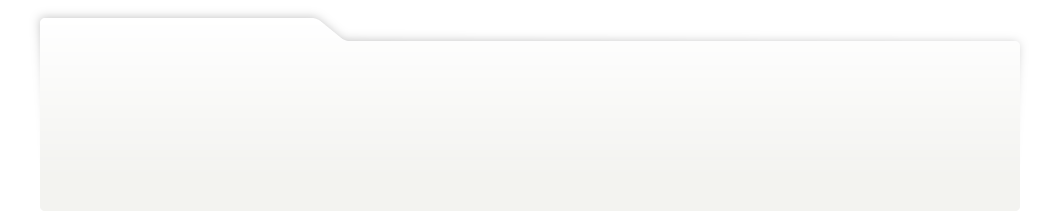
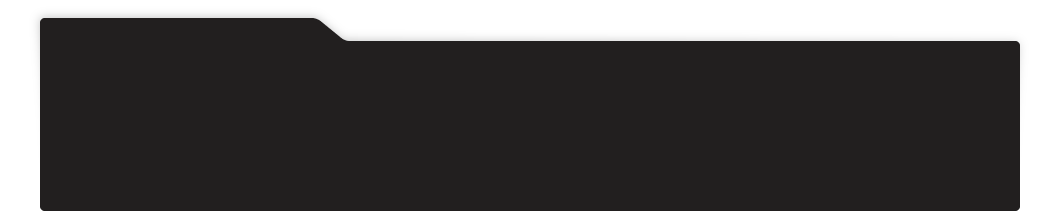
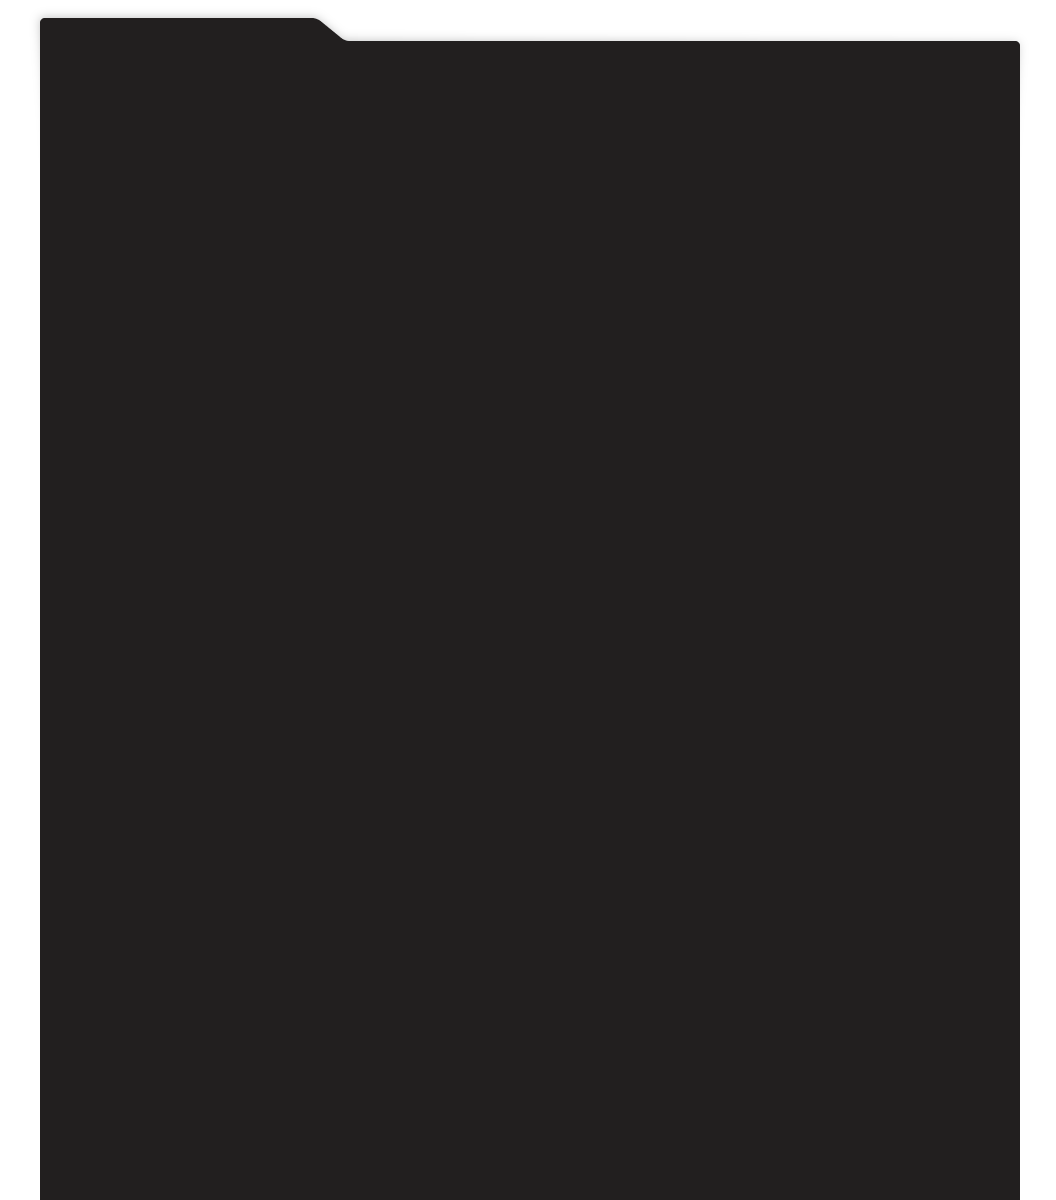
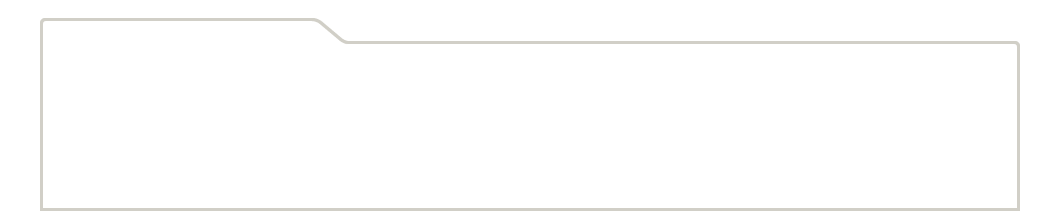
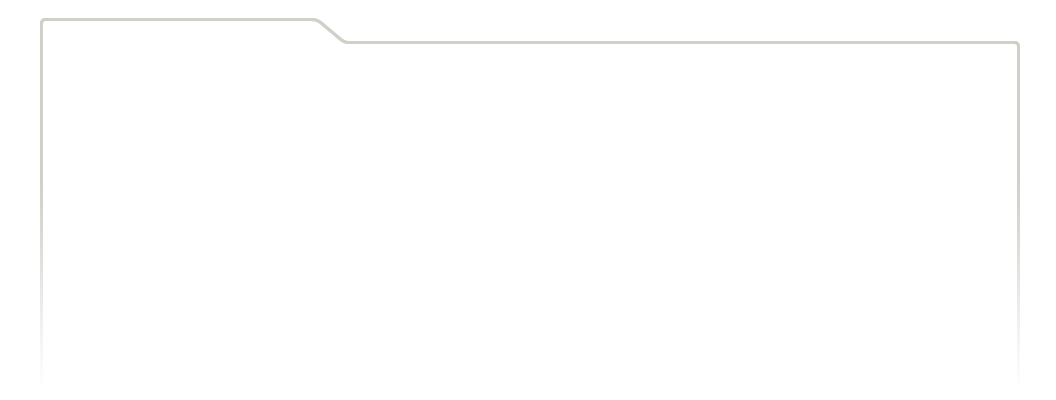
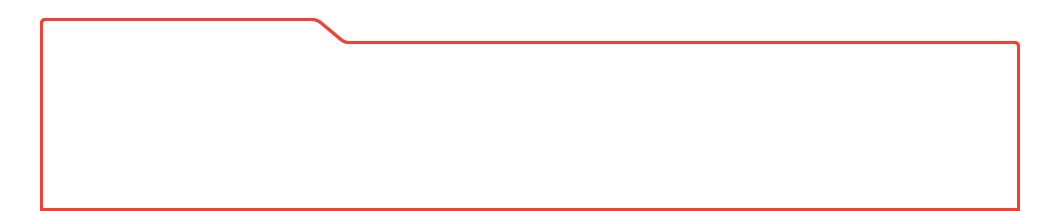
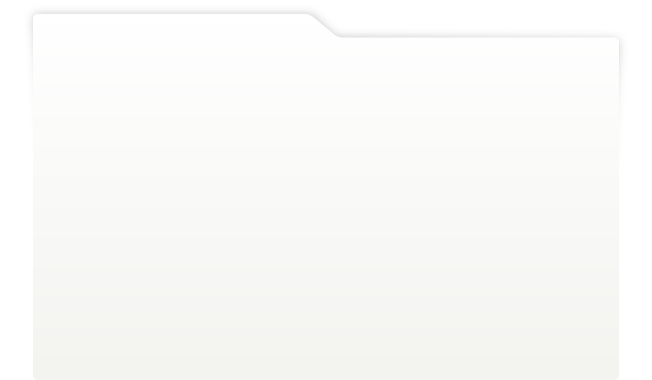
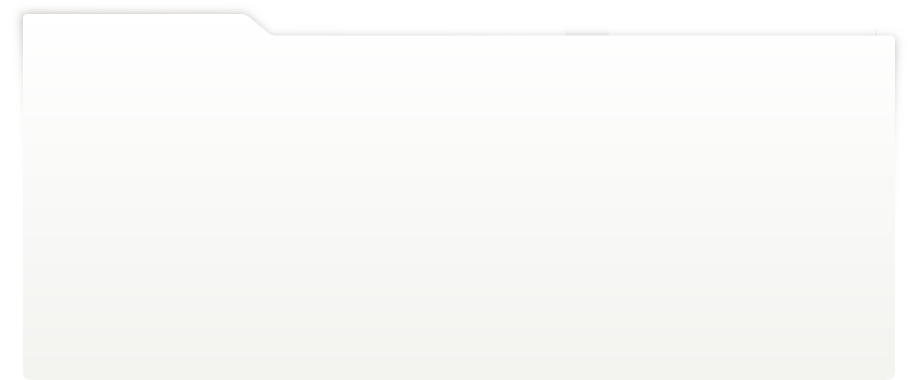
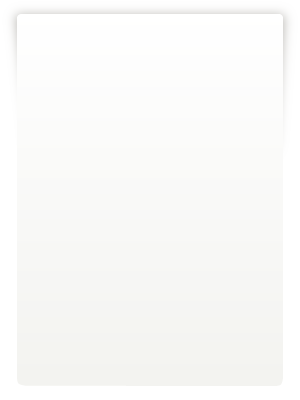
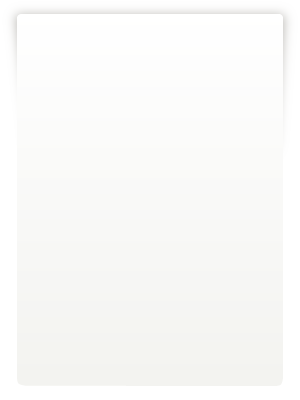
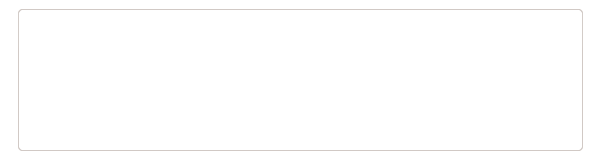
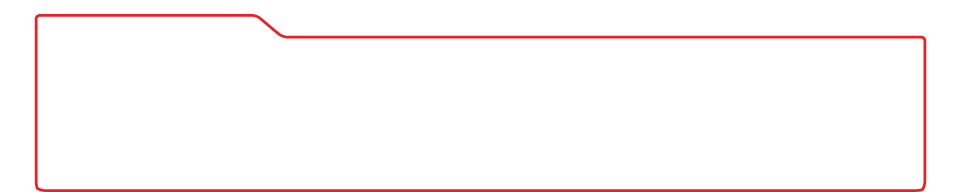
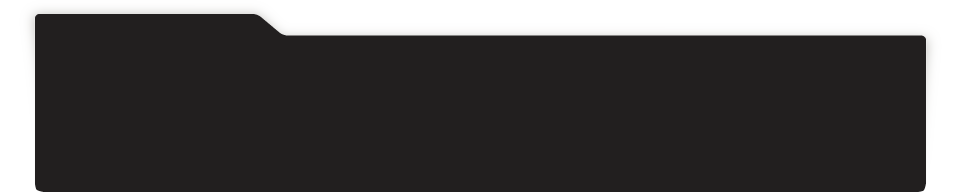
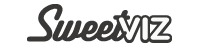
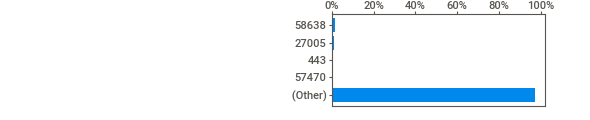
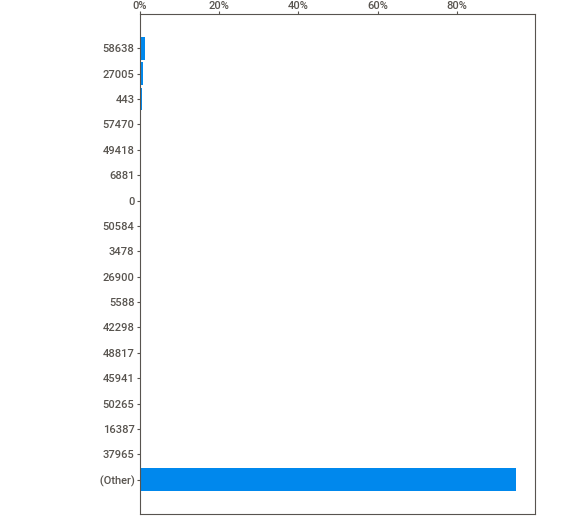
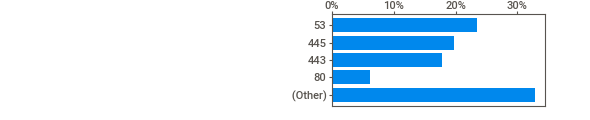
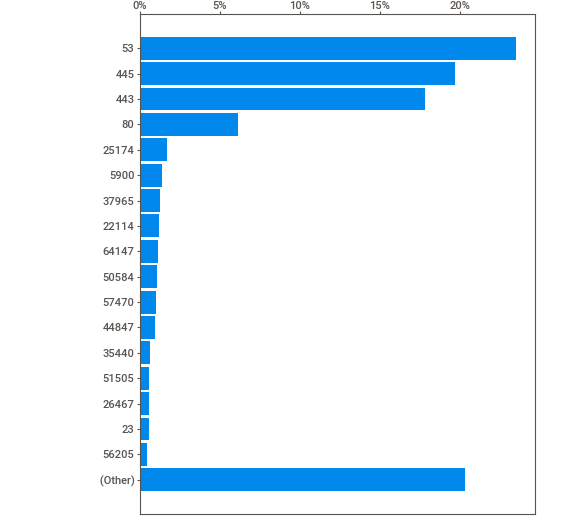
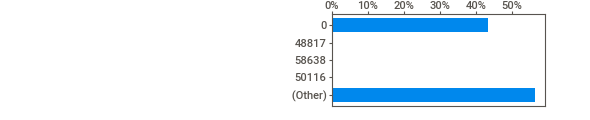
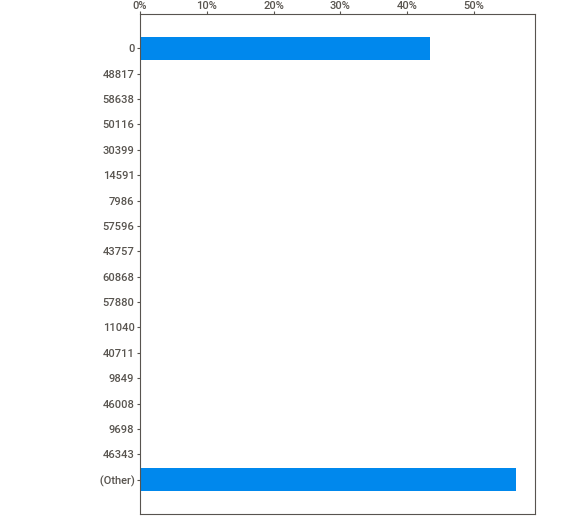
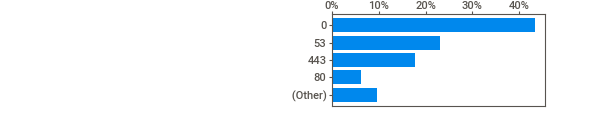
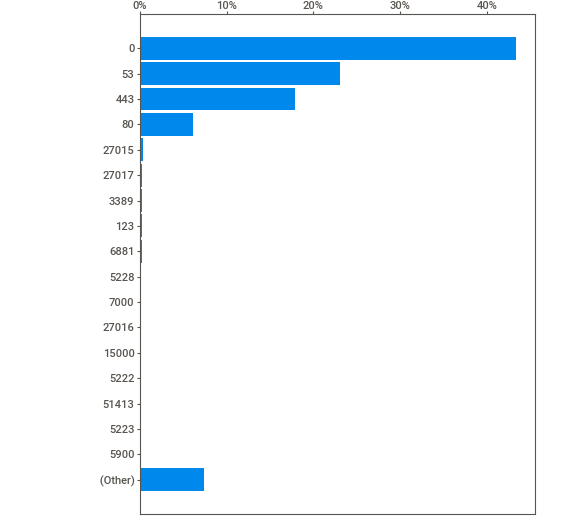
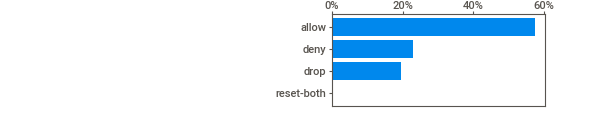
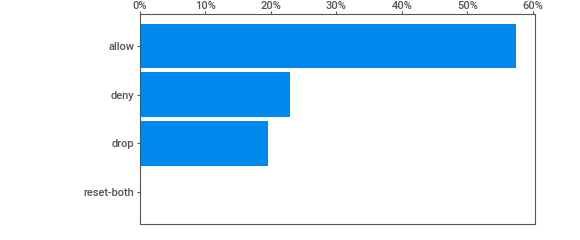
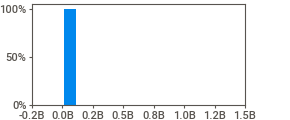
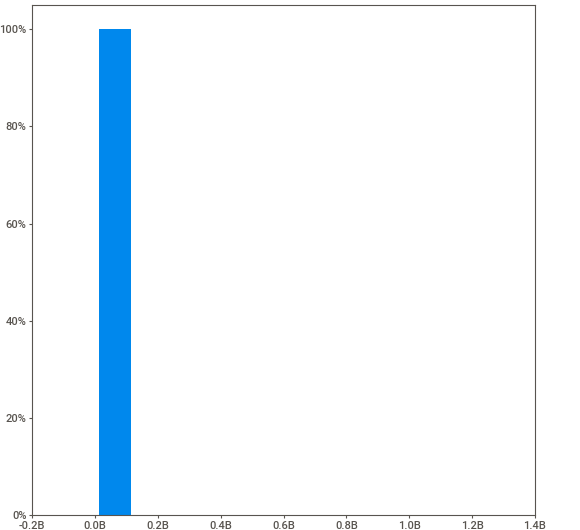
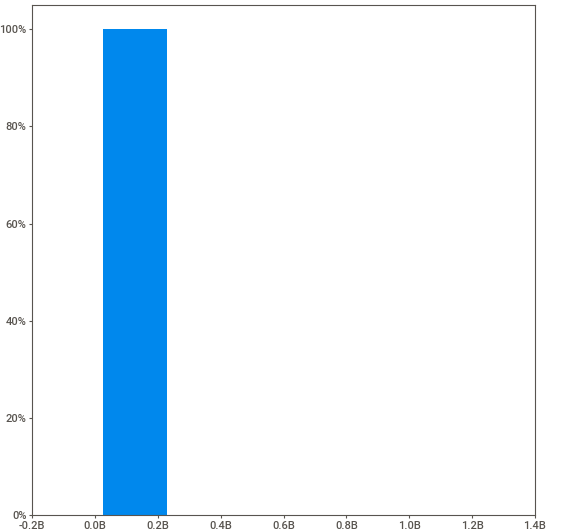
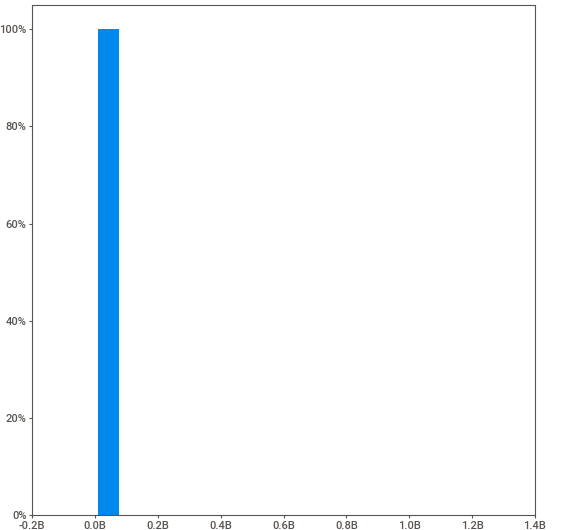
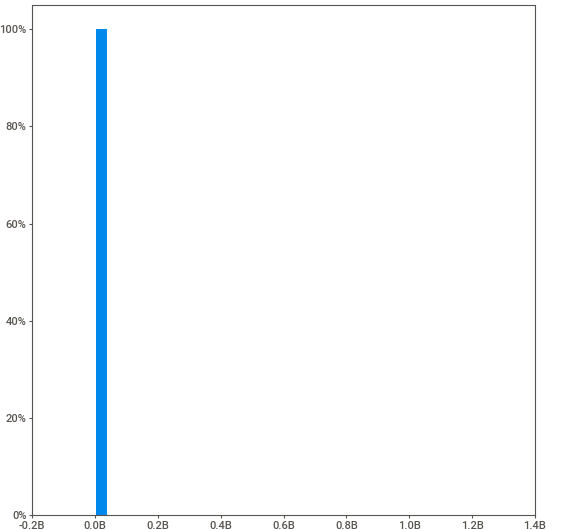
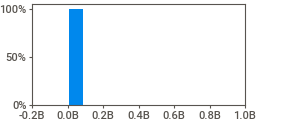
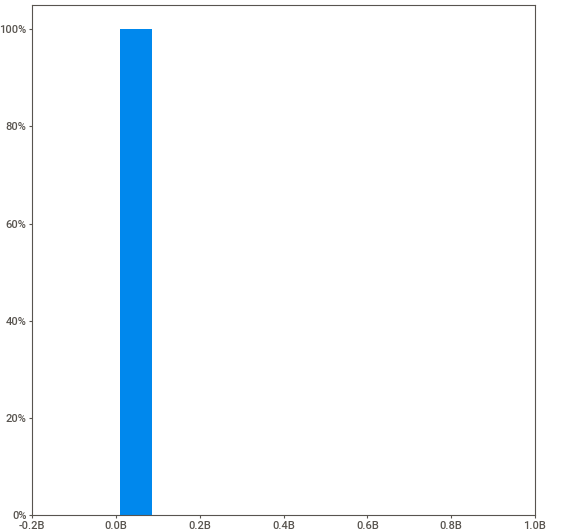
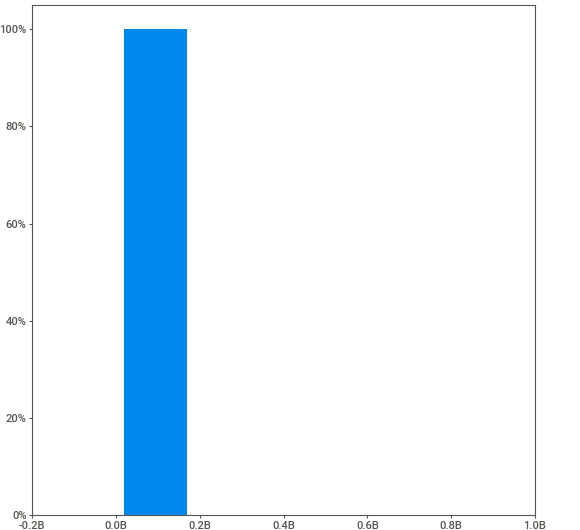
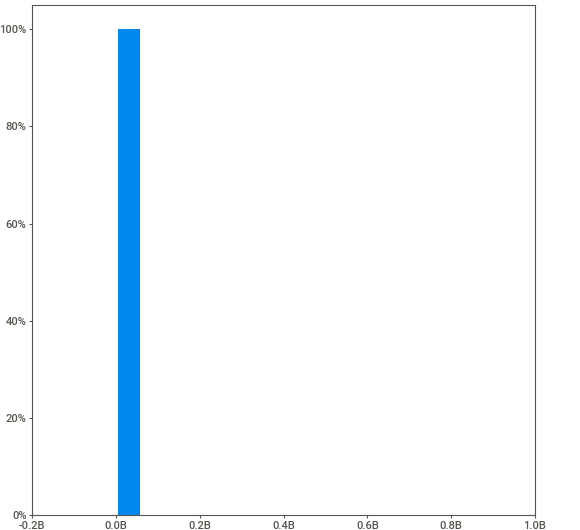
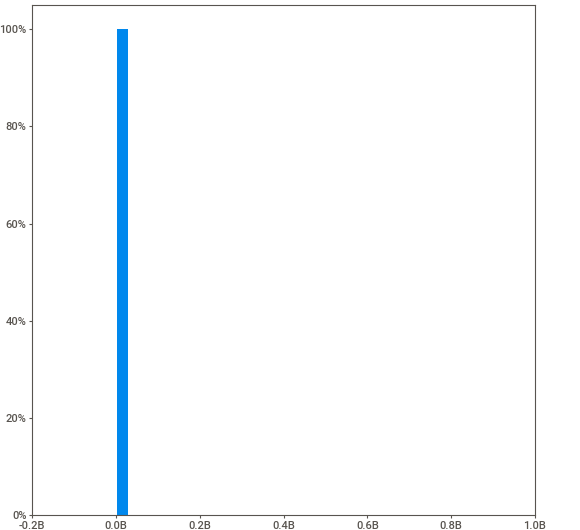
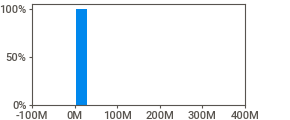
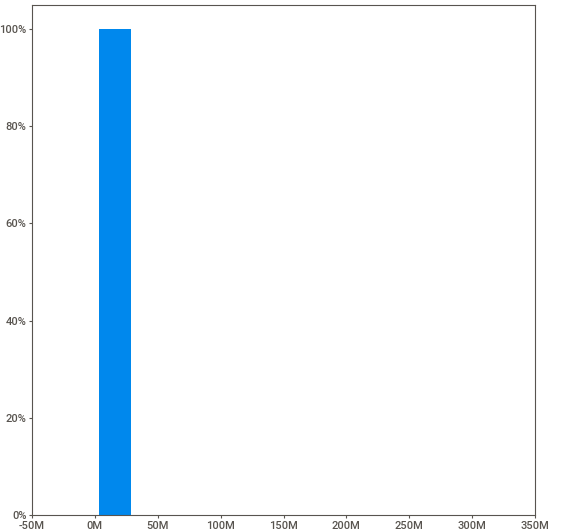
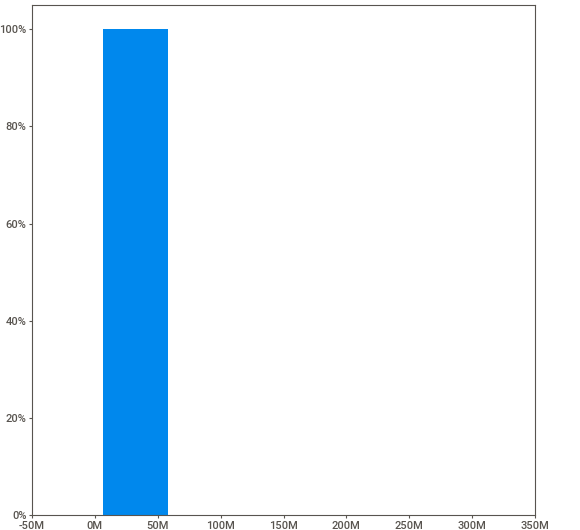
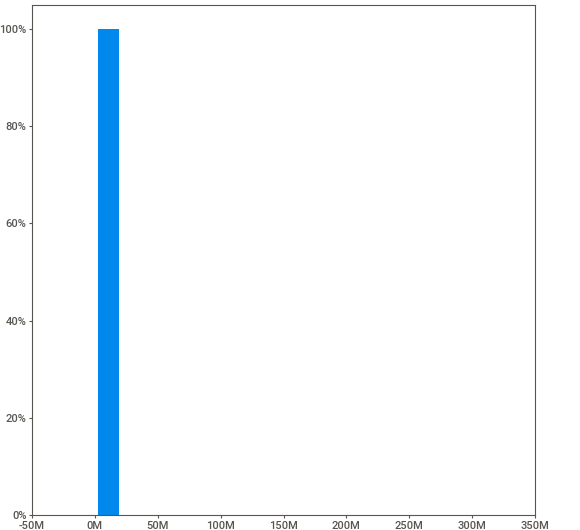
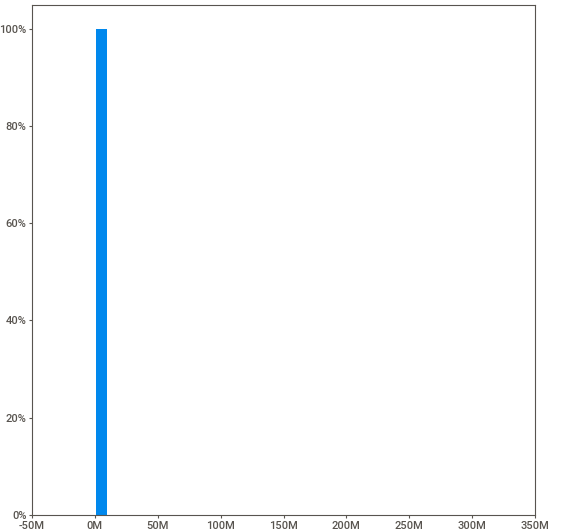
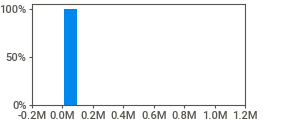
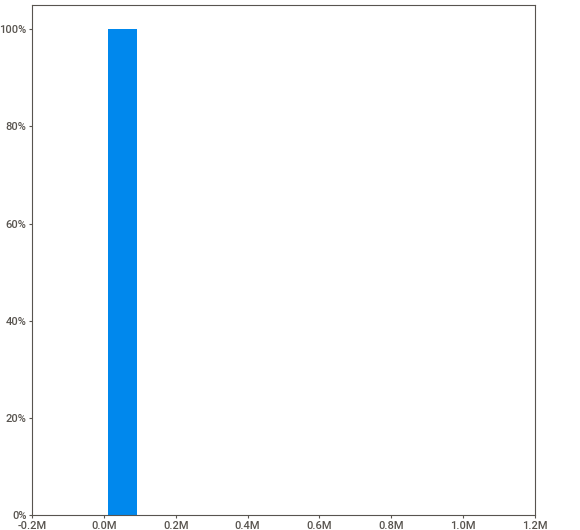
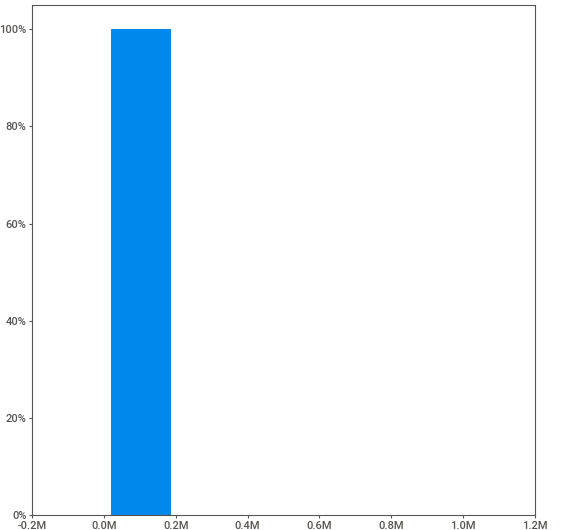
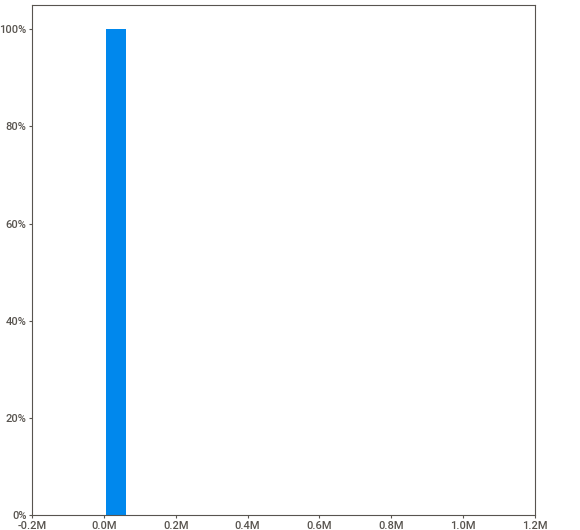
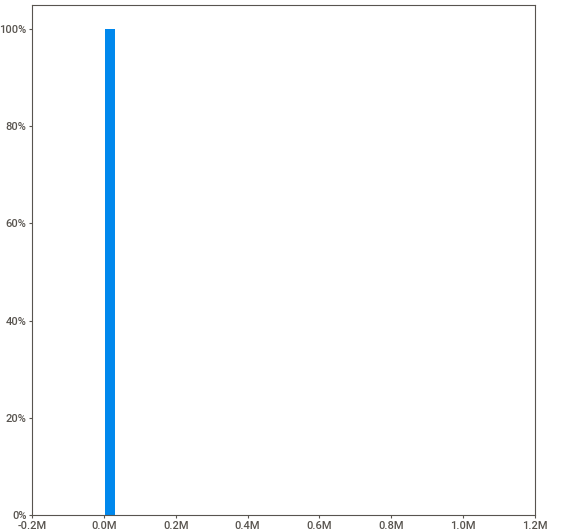
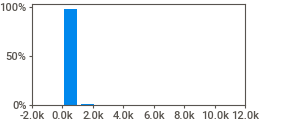
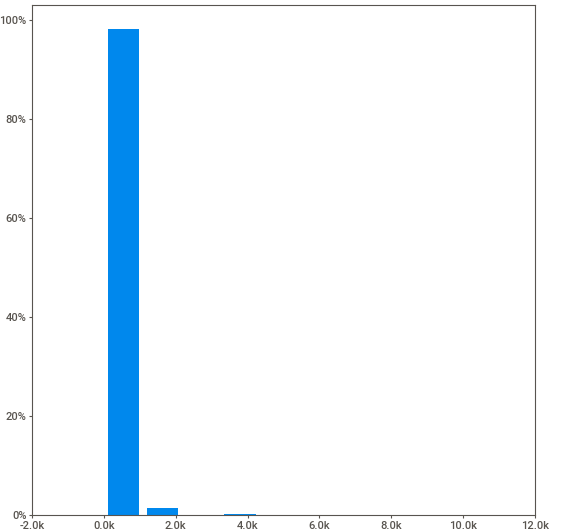
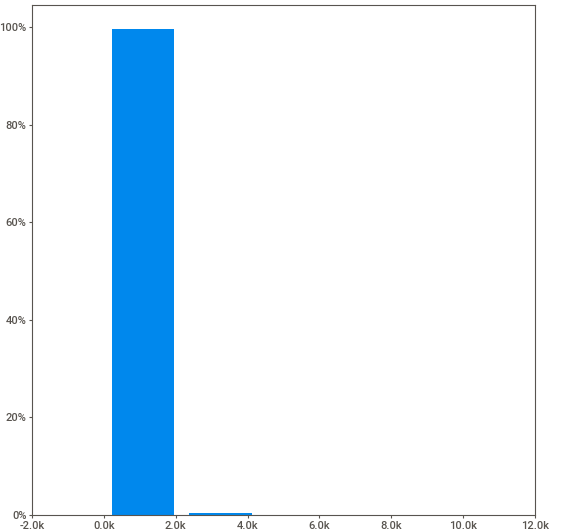
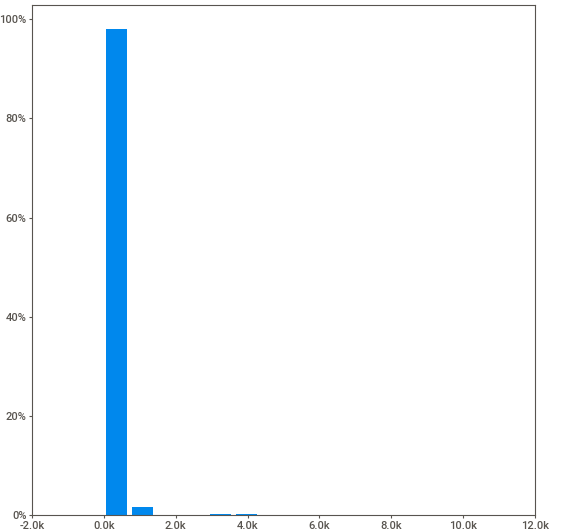
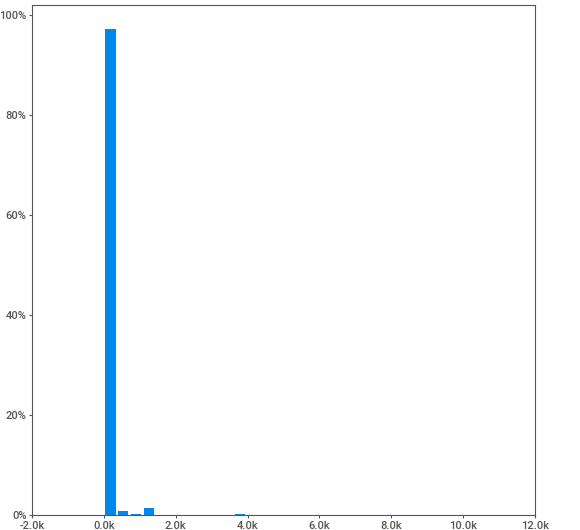
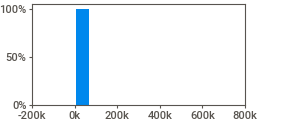
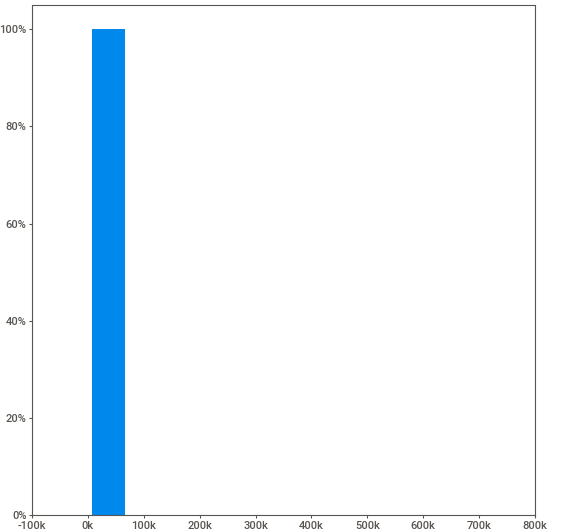
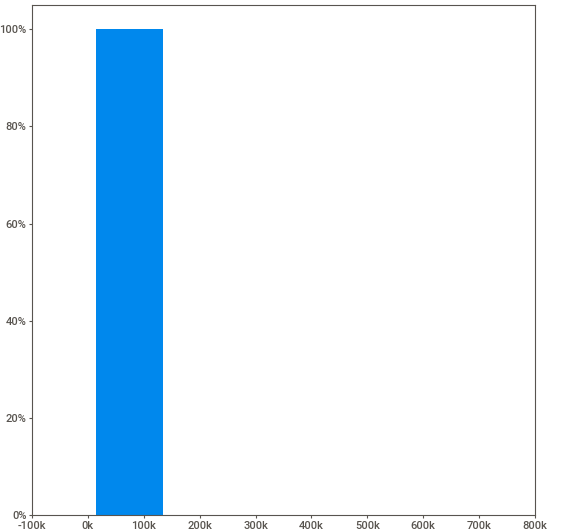
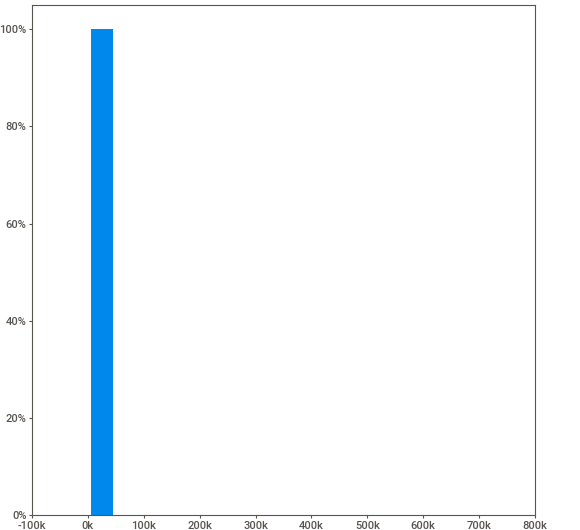
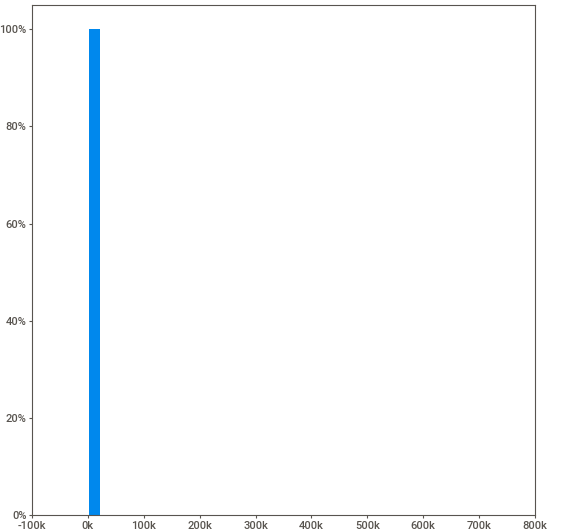
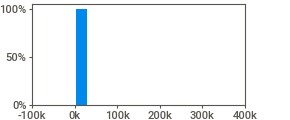
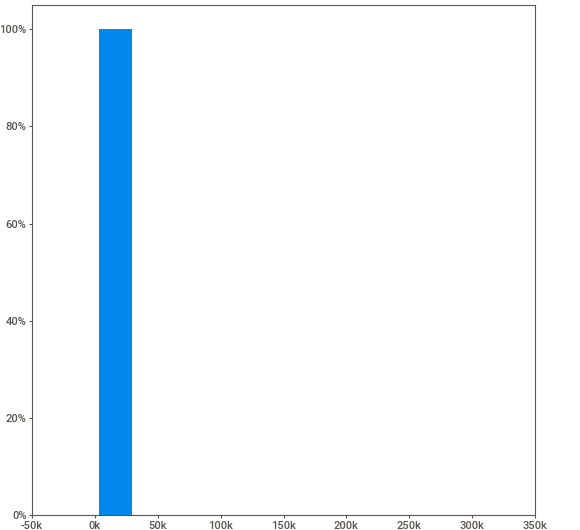
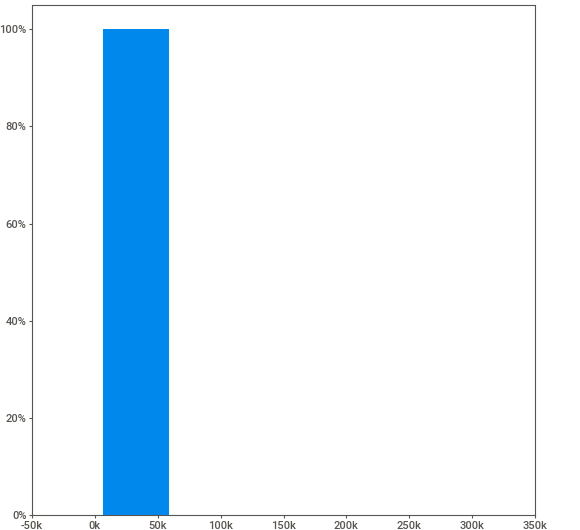
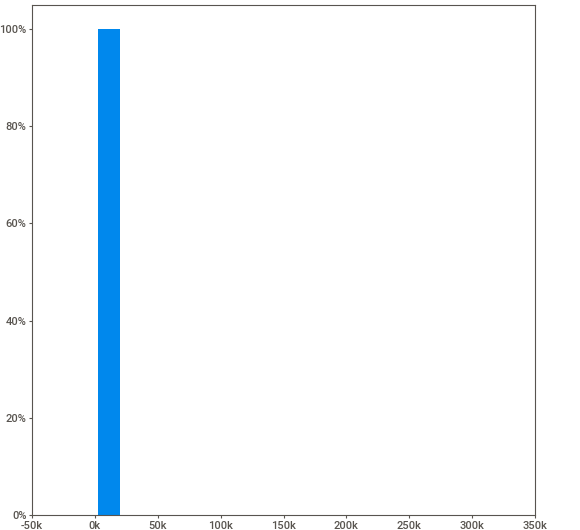
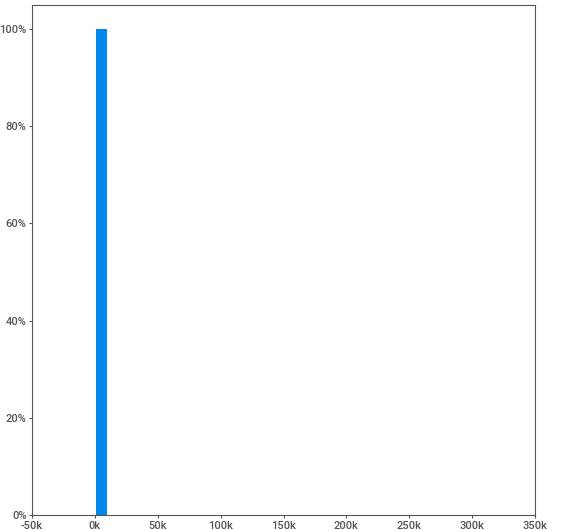
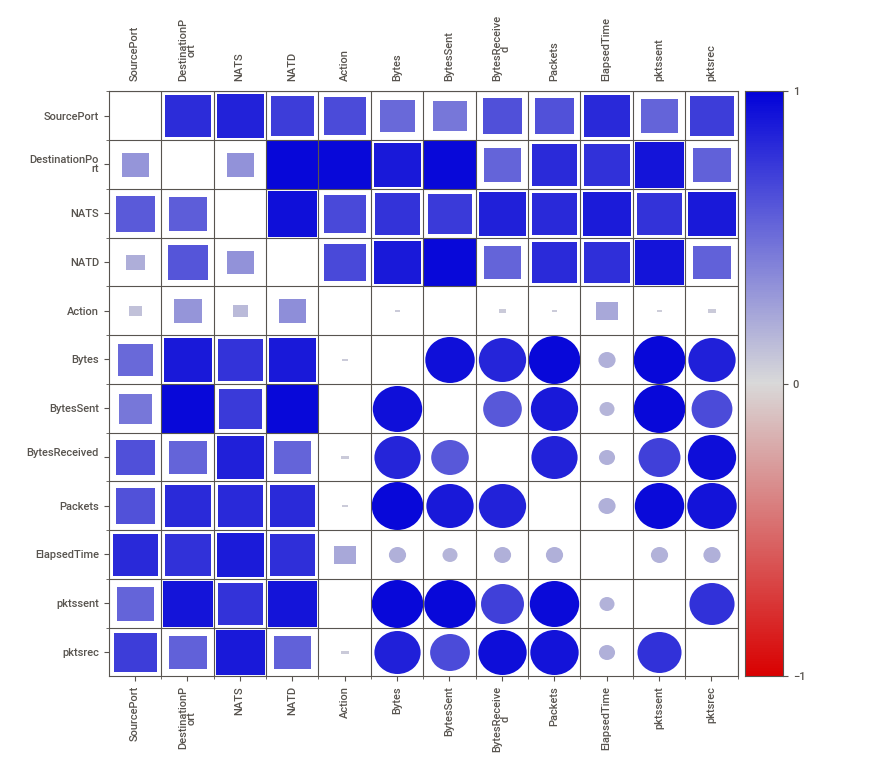
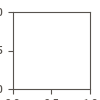

In [24]:
# FULL DATASET 

report = sv.analyze(data)
report.show_notebook()

Source Port: Categorical in nature but has 22k distinct values and vast majority were an "other" category and everything else was 1% or less. To prevent the data from getting to wide the column was categorized into Rare and Common so that we can create a binary 0/1 hot encoding and not widen our dataset unnessarily. 

In [48]:
####### CREATE A COPY OF ORIGINAL DATA FOR IMPUTING ########
# Create a copy of the original data
data_copy = data.copy()


In [49]:
# Create categories for Source Port 
# IT has 22k unique values and the distribution is skewed to "Other". Creating three categories for Source Port: Other, <1% and 1%


# Calculate the frequency of each unique value
value_counts = data_copy['SourcePort'].value_counts()

# Calculate the percentage of occurrences for each value
value_percentages = value_counts / len(data_copy) * 100

# Define a threshold (e.g., 1% of the data)
threshold = 1

# Create a mapping dictionary
mapping = {value: ('rare' if percentage >= threshold else 'Other') for value, percentage in value_percentages.items()}

# Apply the mapping to the SourcePort column
data_copy['SourcePort'] = data_copy['SourcePort'].map(mapping)

# Print the distribution of categories
print(data_copy['SourcePort'].value_counts(normalize=True))

# Print unique values to verify
print(data_copy['SourcePort'].unique())




SourcePort
Other    0.987182
rare     0.012818
Name: proportion, dtype: float64
['Other' 'rare']



1 Destination Port: Categorical in nature but has ~3k distinct values. The sprad seemed to indicate 6 categories were manageable with the 5 highest having their own categories and a ‘not_common’ category all below 5% of the data. 


In [52]:
import pandas as pd
import numpy as np


# Define the specific categories we want to keep
specific_categories = ['53', '445', '443', '80']

# Calculate the frequency of each unique value
value_counts = data_copy['DestinationPort'].value_counts()

# Calculate the percentage of occurrences for each value
value_percentages = value_counts / len(data_copy) * 100

# Define a threshold for 'not_common' (e.g., 1% of the data)
threshold = 1

# Create a mapping function
def categorize_destination(value):
    value_str = str(value)
    if value_str in specific_categories:
        return value_str
    elif value_percentages[value] >= threshold:
        return 'not_common'
    else:
        return 'other'

# Apply the mapping to the DestinationPort column
data_copy['DestinationPort'] = data_copy['DestinationPort'].apply(categorize_destination)

# Convert DestinationPort to categorical dtype
data_copy['DestinationPort'] = pd.Categorical(data_copy['DestinationPort'])

# Print the distribution of categories
print(data_copy['DestinationPort'].value_counts(normalize=True))

# Print unique values to verify
print(data_copy['DestinationPort'].unique())

# Verify the dtype
print(data_copy['DestinationPort'].dtype)

# Verify we have exactly 6 categories
print(f"Number of categories: {data_copy['DestinationPort'].nunique()}")

DestinationPort
other         0.240722
53            0.235213
445           0.196713
443           0.178295
not_common    0.087484
80            0.061573
Name: proportion, dtype: float64
['53', 'other', '443', '80', '445', 'not_common']
Categories (6, object): ['443', '445', '53', '80', 'not_common', 'other']
category
Number of categories: 6


SourcePort
Rare      64692
Common      840
Name: count, dtype: int64

                                             |                                                                …


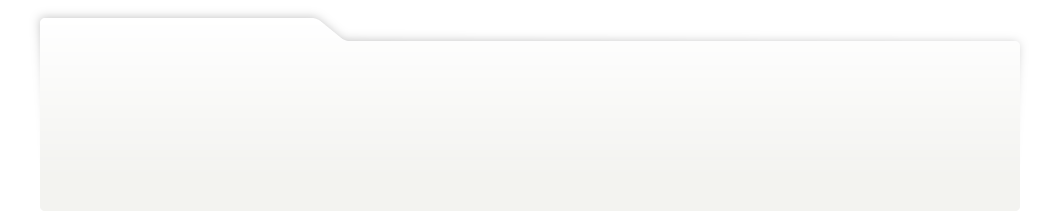
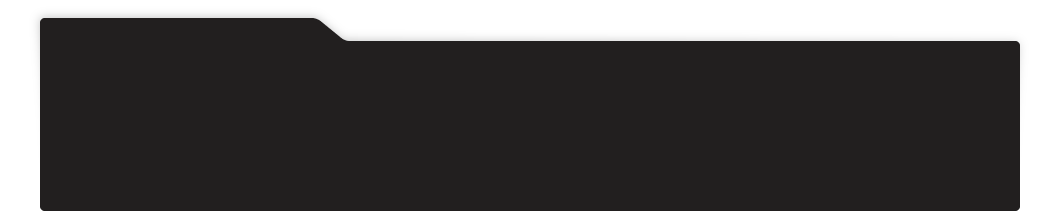
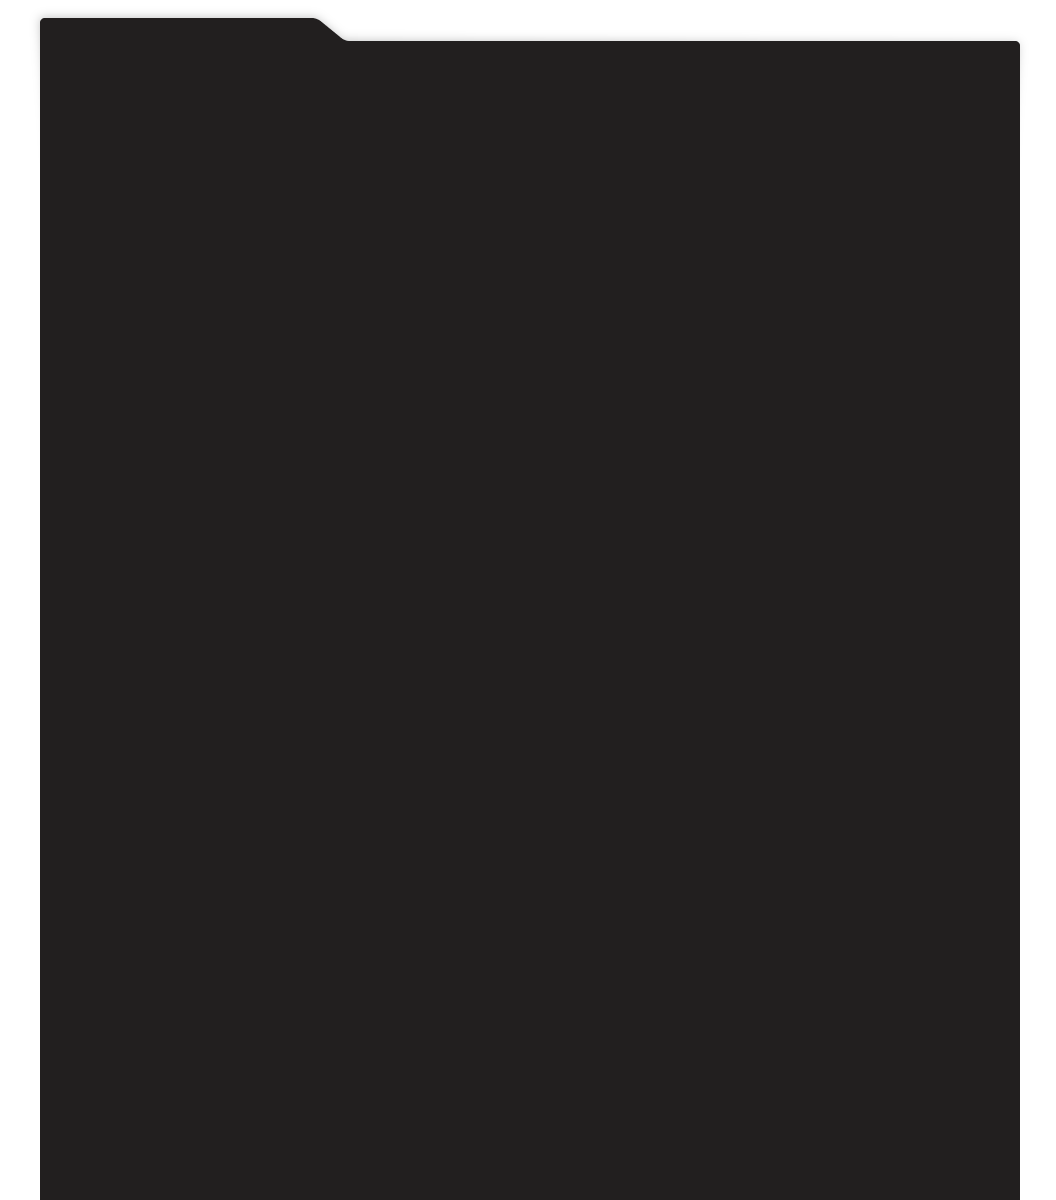
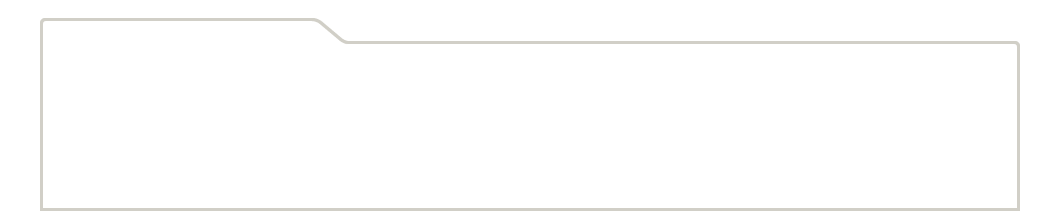
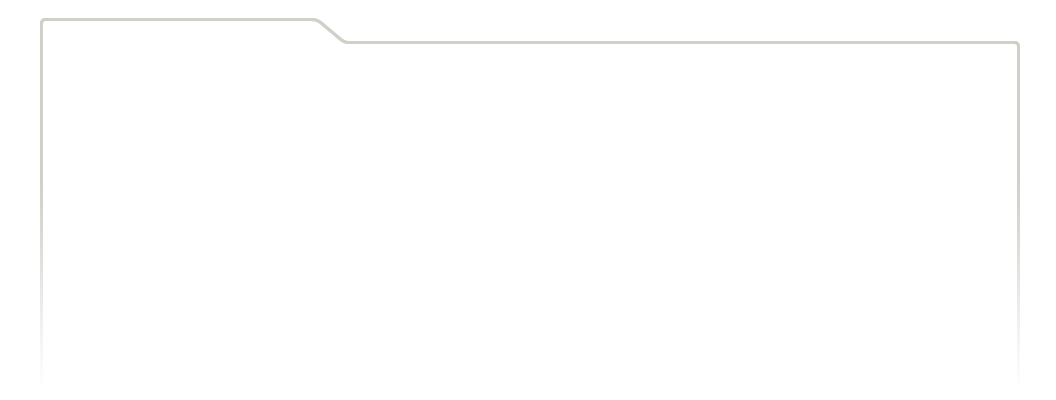
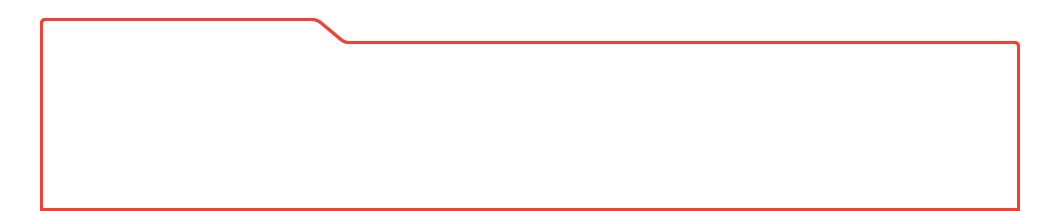
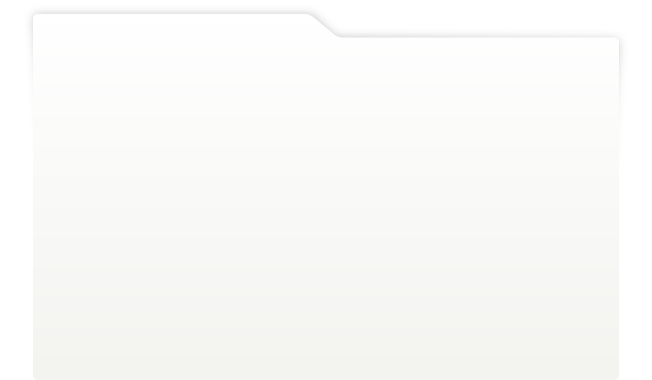
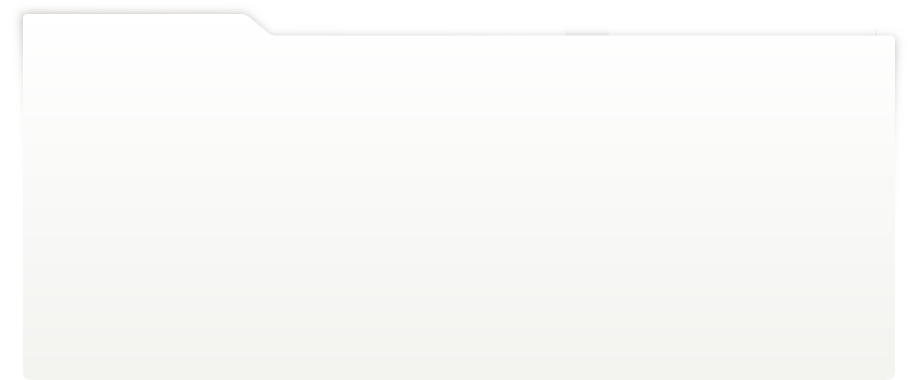
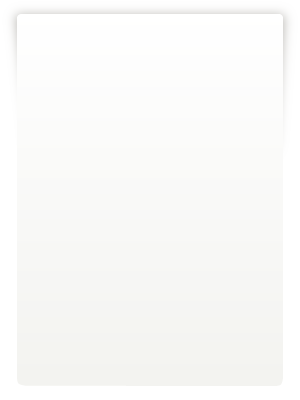
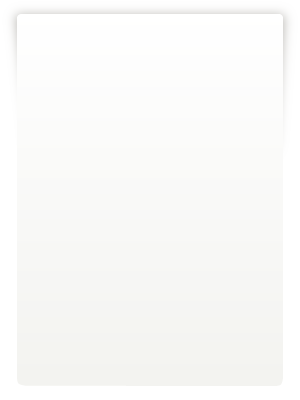
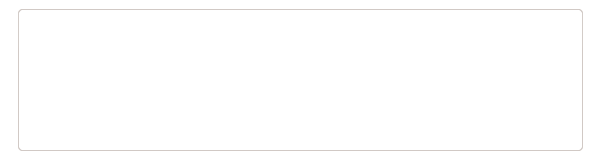
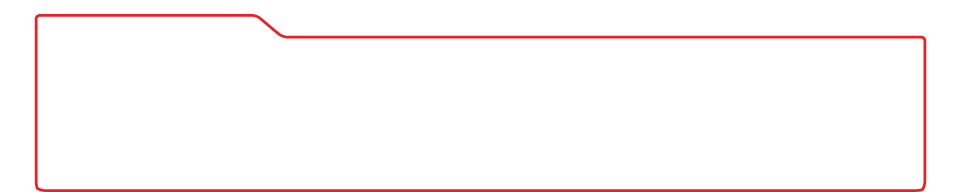
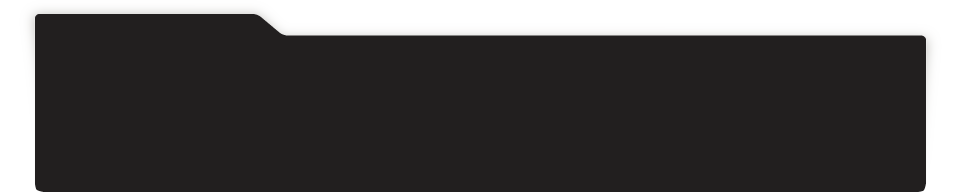
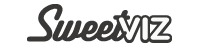
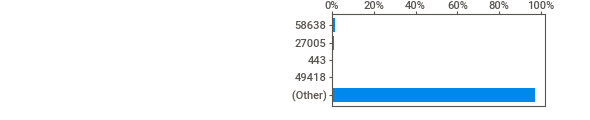
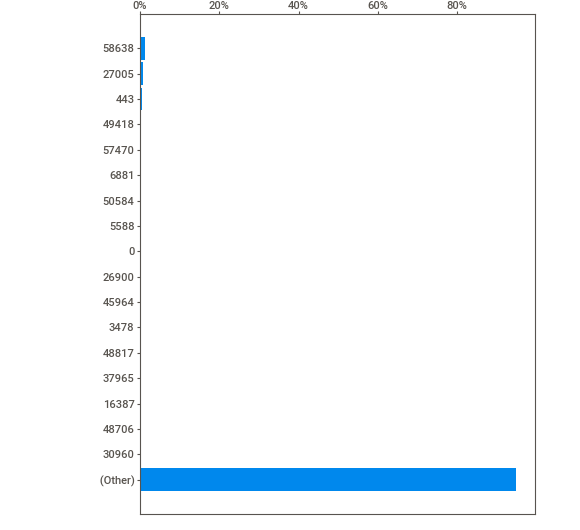
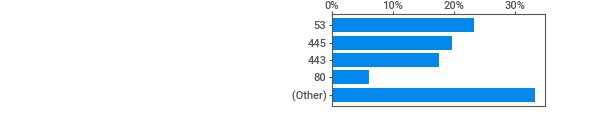
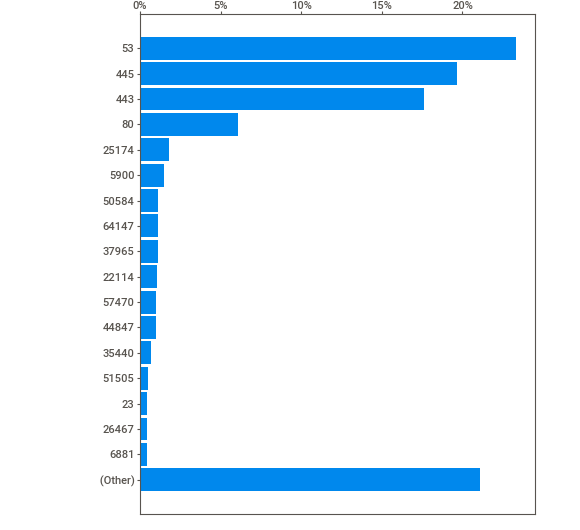
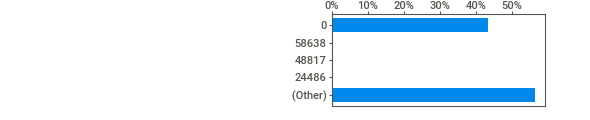
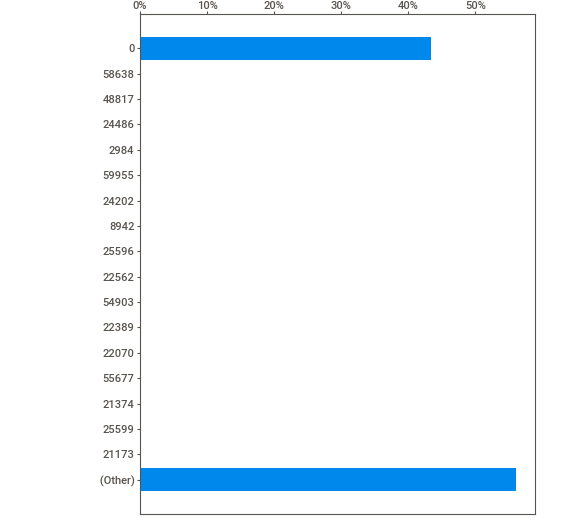
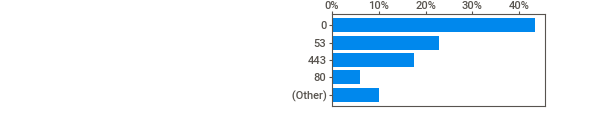
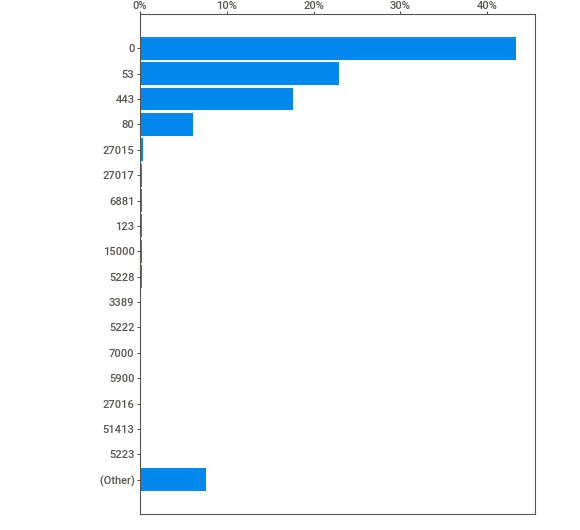
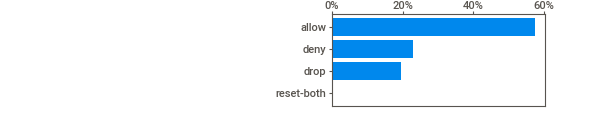
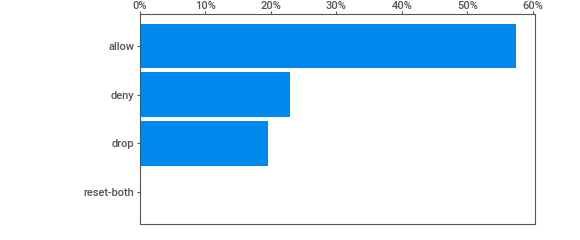
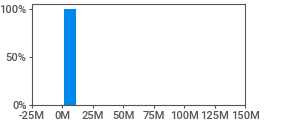
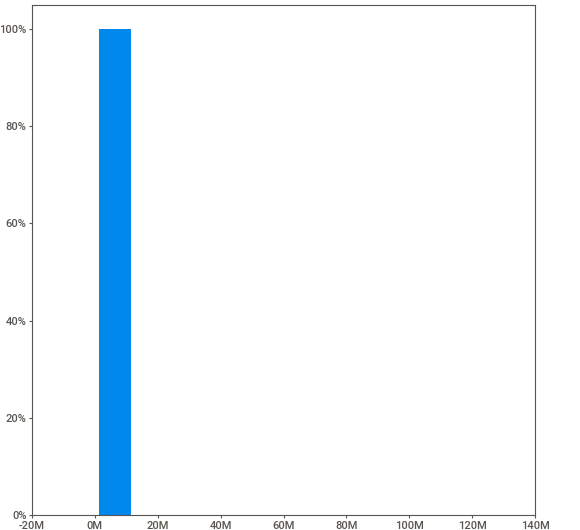
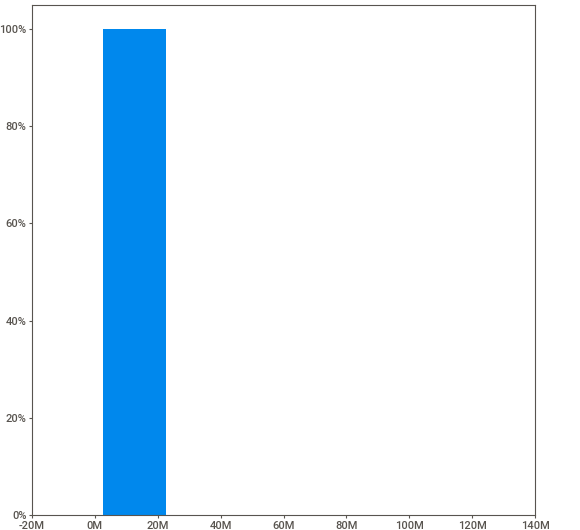
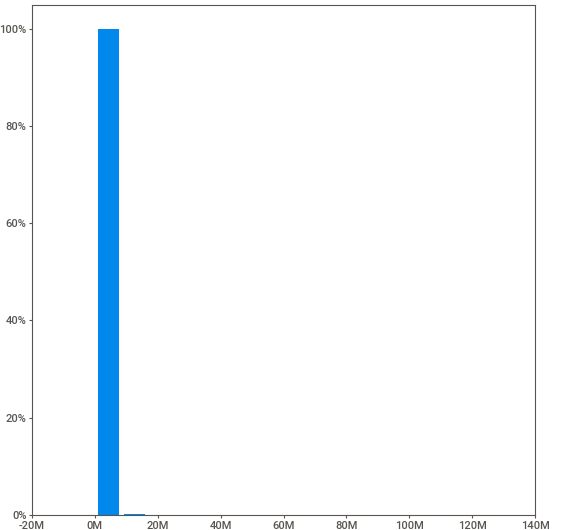
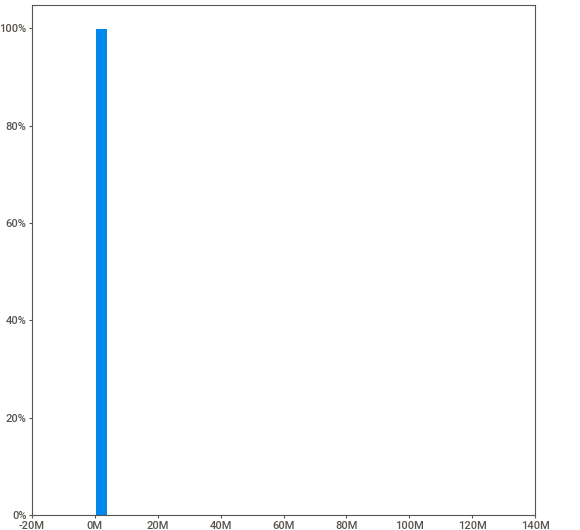
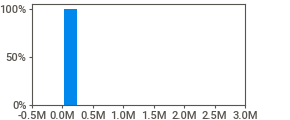
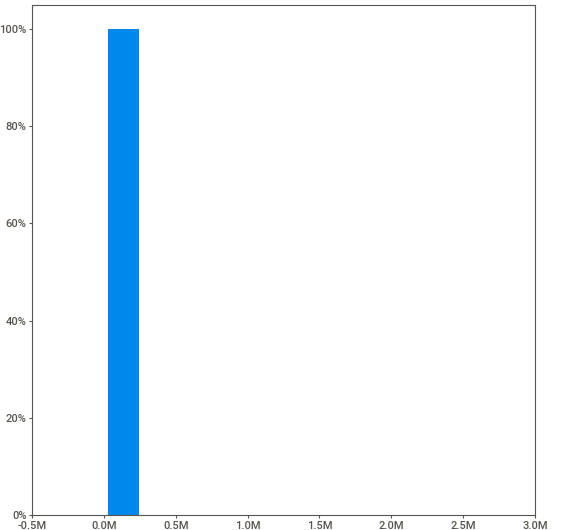
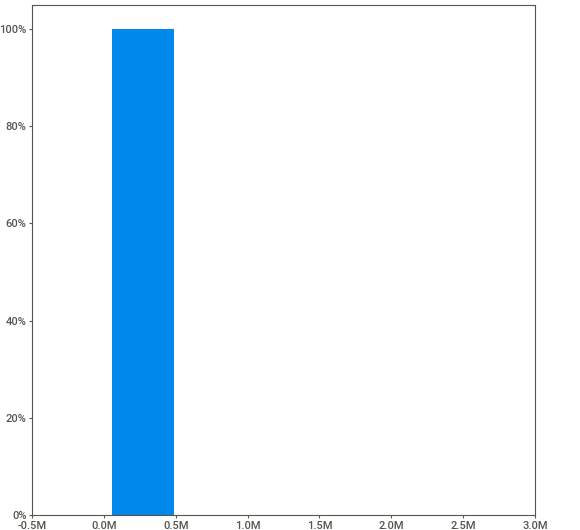
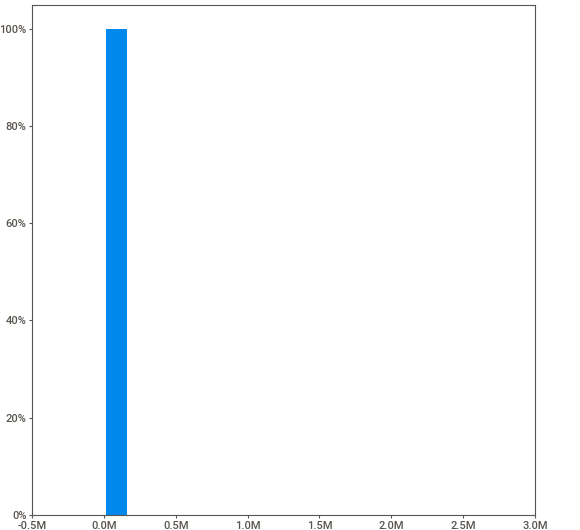
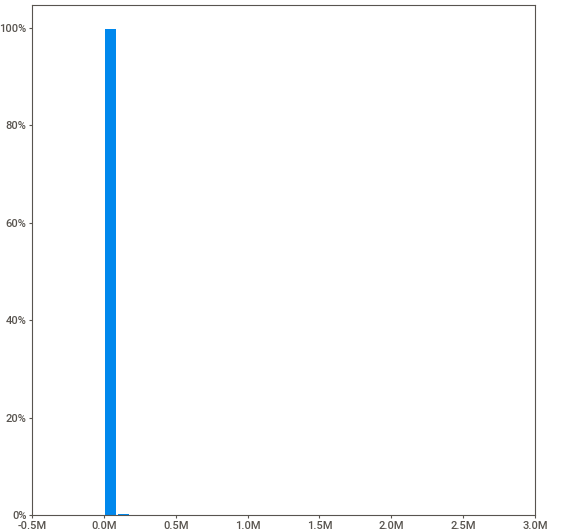
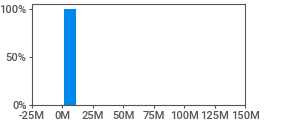
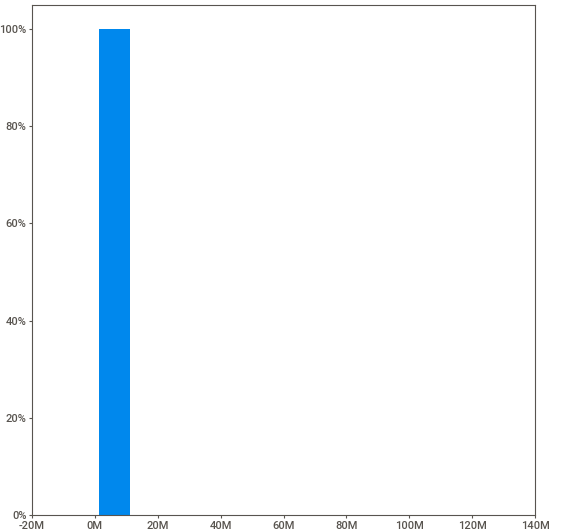
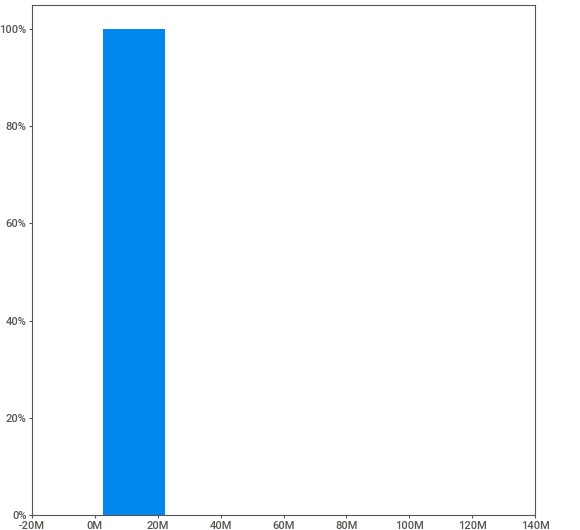
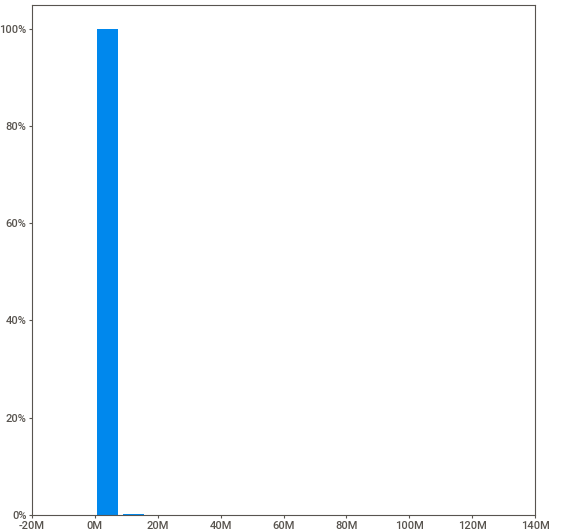
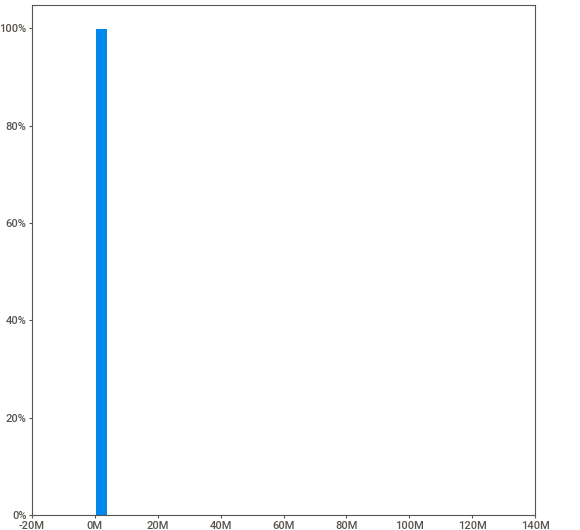
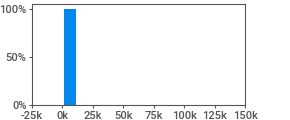
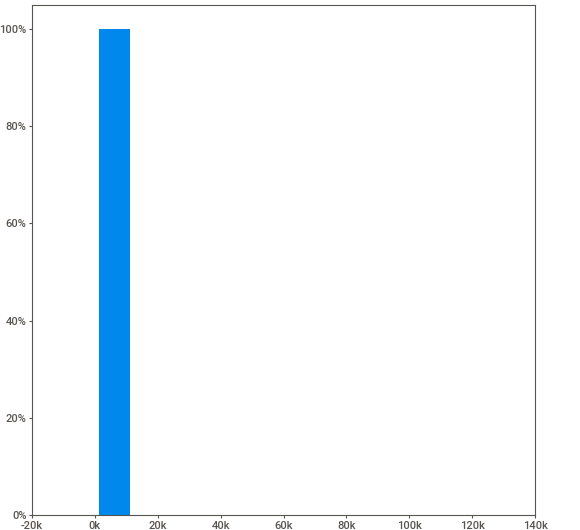
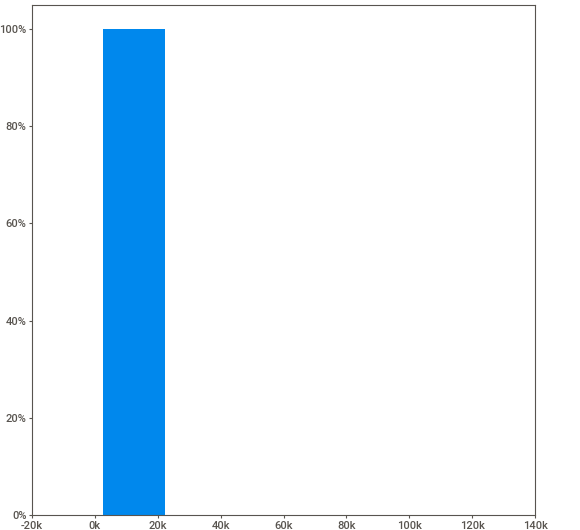
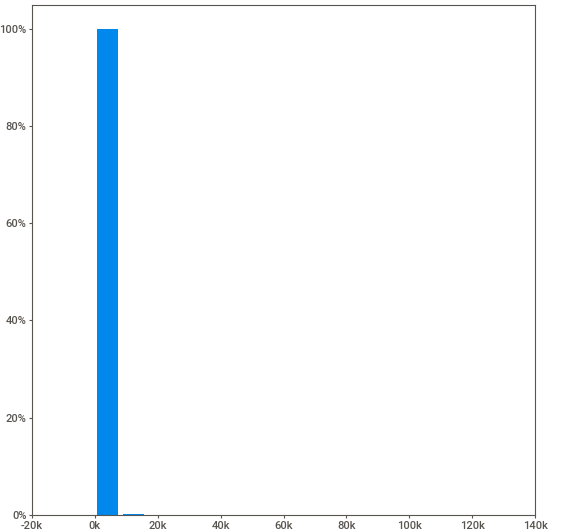
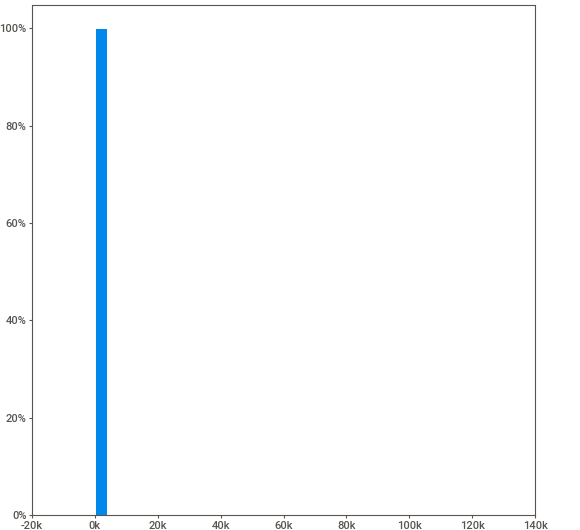
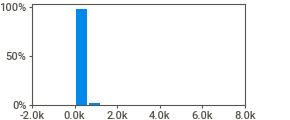
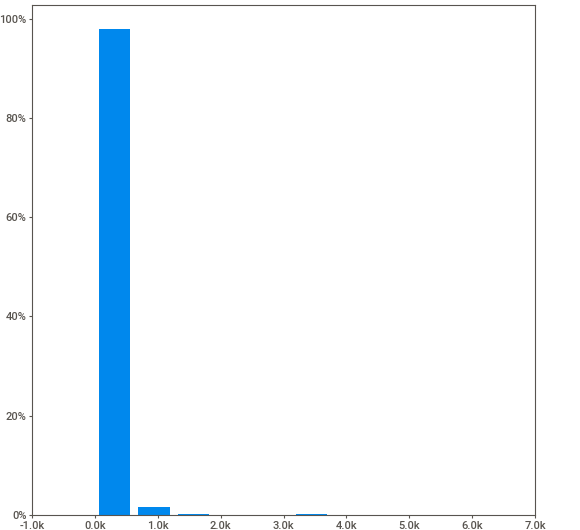
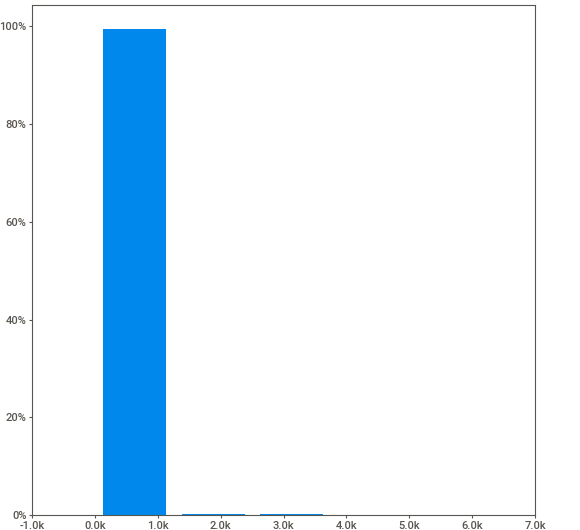
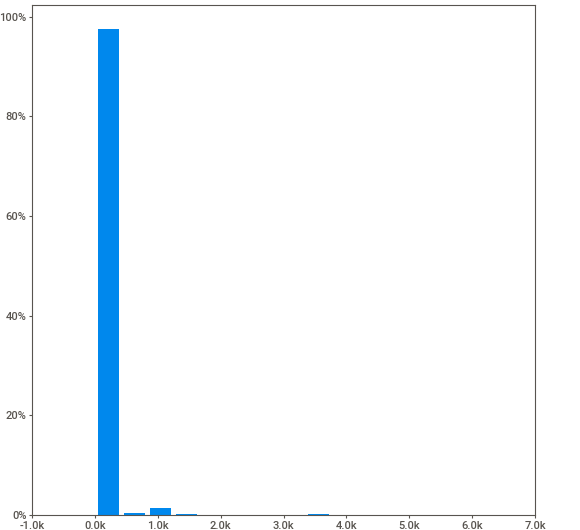
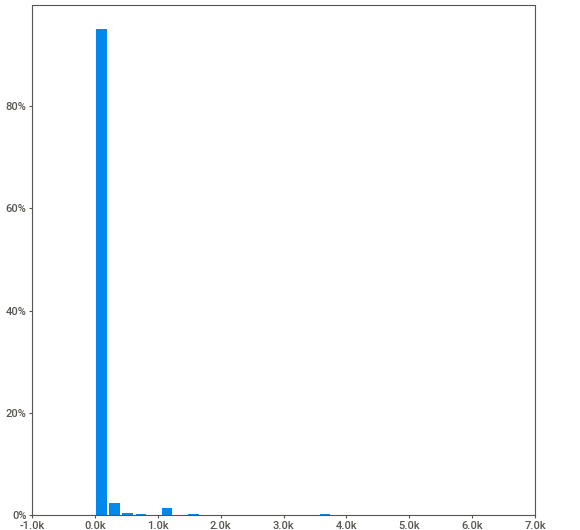
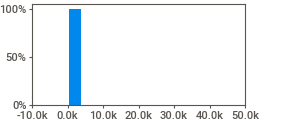
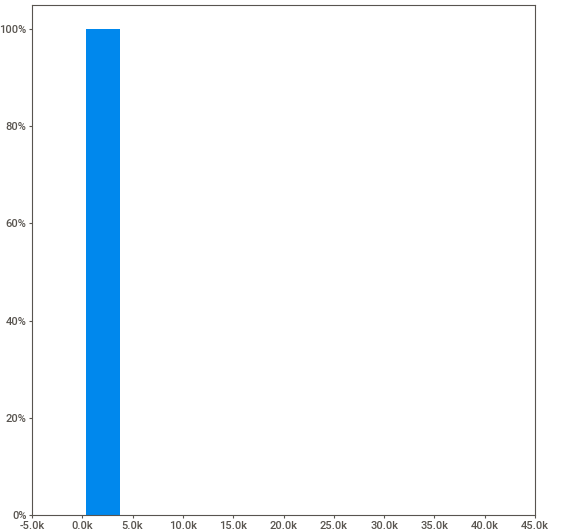
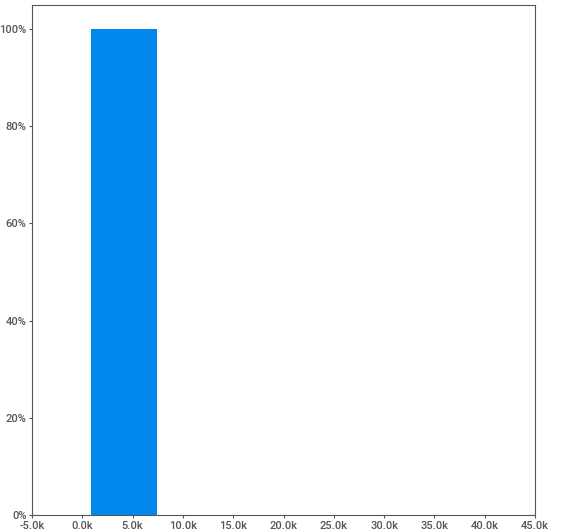
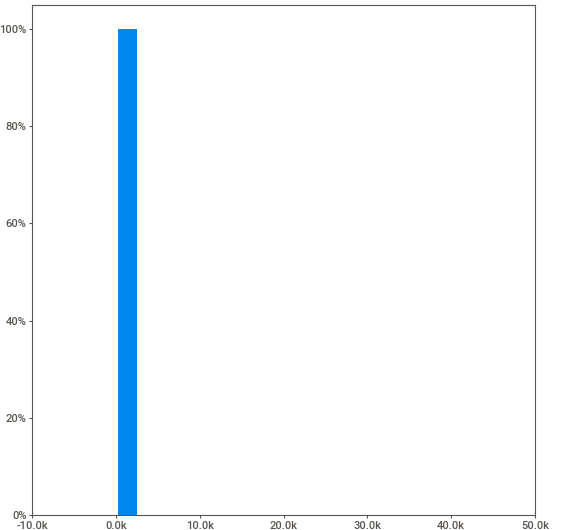
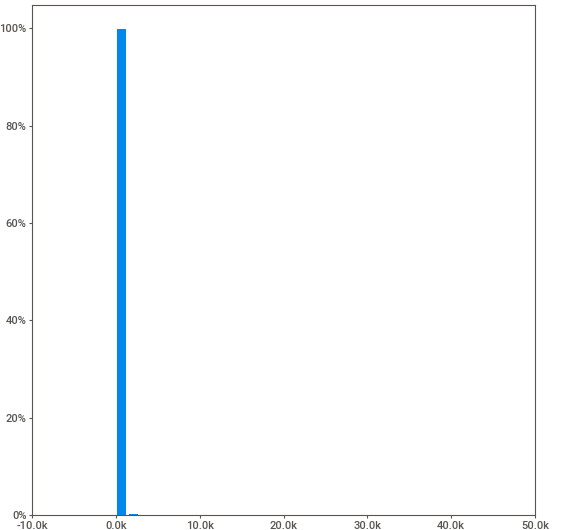
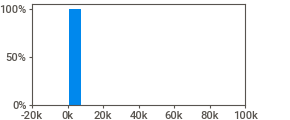
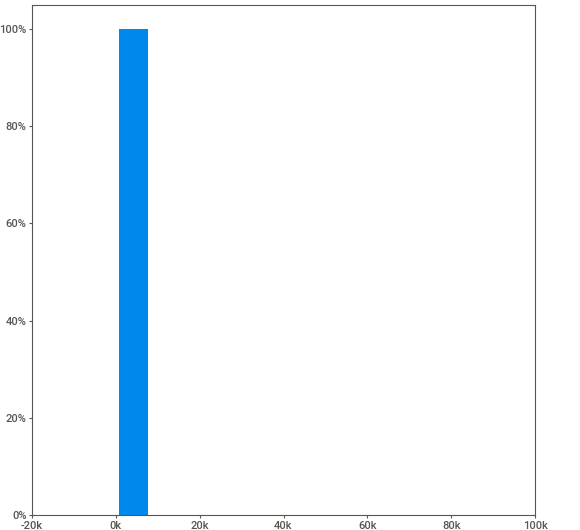
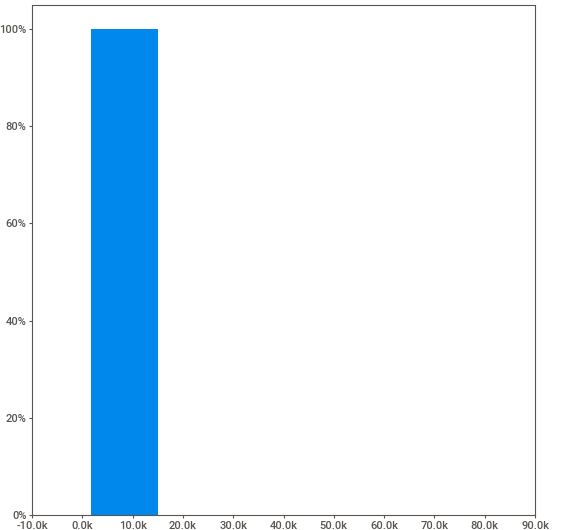
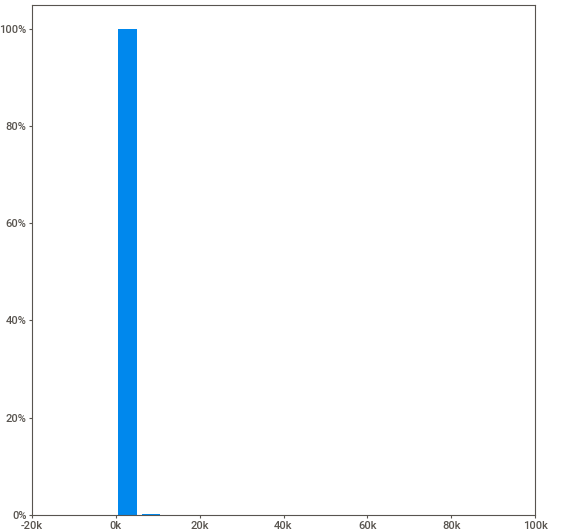
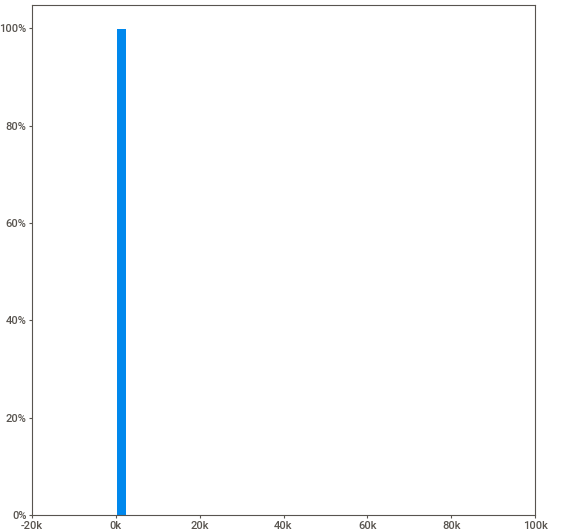
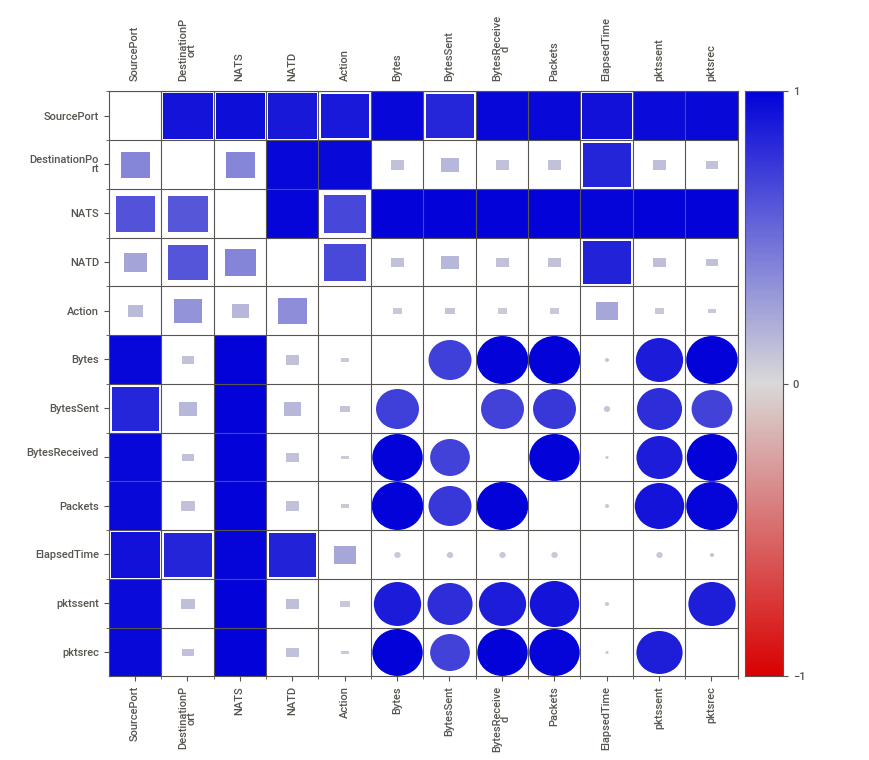
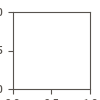

In [25]:
# REDUCED DATASET 

report = sv.analyze(red_data)
report.show_notebook()

In [ ]:
# create limits on categorical columns to prevent the data from getting to wide simplify


In [ ]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse=False)
action_encoded = onehot.fit_transform(data[['action']])
action_columns = onehot.get_feature_names(['action'])
action_df = pd.DataFrame(action_encoded, columns=action_columns)

# Combine with original dataframe if needed
data = pd.concat([data, action_df], axis=1)

In [ ]:
# LABEL ENCODE ?? or ONE HOT ENCODE  ?

# from sklearn.preprocessing import LabelEncoder

# # i think we need to one hot encode though label encoding is another option 
# le = LabelEncoder()
# data['action_encoded'] = le.fit_transform(data['action'])



In [ ]:
# Lets look at categories for each and create a cut off 

In [ ]:

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:


# Make decision what to do with ports that infrequent create a cut off 
####### rare port or lumping into a category - prevent the dataset from getting to wide 
#### use getdummies encode to 0 and 1s these are just features 
##### 
# then need to one hot encode -- but 1 -1 not 01 for SVM usage 

In [22]:
features.describe()

SourcePort  DestinationPort          NATS          NATD  \
count  10000.000000     10000.000000  10000.000000  10000.000000   
mean  -49055.806500    -10490.584600 -17707.545100  -2233.873900   
std    15105.495534     17668.385335  21982.267807   9124.156513   
min   -65534.000000    -65473.000000 -65534.000000 -65128.000000   
25%   -58149.250000    -14704.000000 -35999.250000    -80.000000   
50%   -53356.000000      -445.000000  -1851.000000    -53.000000   
75%   -49304.000000       -80.000000      0.000000      0.000000   
max        0.000000         0.000000      0.000000      0.000000   

              Bytes     BytesSent  BytesReceived       Packets   ElapsedTime  \
count  1.000000e+04  1.000000e+04   1.000000e+04  10000.000000  10000.000000   
mean  -4.495792e+04 -2.140102e+03  -4.281782e+04    -48.114200    -52.850200   
std    7.256179e+05  4.166213e+04   7.100876e+05    672.758179    274.824719   
min   -3.362552e+07 -3.850148e+06  -3.313575e+07 -29877.000000  -9851.000000   
25%   -3.632500e+02 -1.460000e+02  -1.800000e+02     -3.000000    -30.000000   
50%   -1.020000e+02 -7.800000e+01   0.000000e+00     -1.000000     -4.000000   
75%   -6.600000e+01 -6.600000e+01   0.000000e+00     -1.000000      0.000000   
max   -6.000000e+01 -6.000000e+01   0.000000e+00     -1.000000      0.000000   

           pktssent       pktsrec  
count  10000.000000  10000.000000  
mean     -15.860800    -32.253400  
std      193.028902    490.728747  
min    -7975.000000 -23074.000000  
25%       -2.000000     -1.000000  
50%       -1.000000      0.000000  
75%       -1.000000      0.000000  
max       -1.000000      0.000000

In [23]:
target.value_counts() # multi-class classification four (4) classes 

Action
allow         5105
deny          3083
drop          1804
reset-both       8
Name: count, dtype: int64

In [ ]:
# convert target to 1 , -1? ????????
# one hot encode the target variable



# PORT are unique categorical other ports are also classifiers 

# byte is a discrete variable (size of info sent) 

# bytes are sent in packets 

# bytes and packtes highlyh correlated 

Exploratory Data Analysis 

In [ ]:
import sweetviz as sv

report = sv.analyze(X_scaled)
report.show_notebook()

Model (1 SVM)

In [24]:
# LINEAR SVM TUNE THE HYPERPARAMTERS

# run svm train test split 
# linear SVC -- use this one use dual hinge - run in 15 20 min to tune the hyperparamters


SyntaxError: invalid syntax (3572717125.py, line 2)

In [ ]:
# then run svc best paramters on full dataset 
# tuning 65k samples try 10k when you find your best then you put your paramters into the whole thing - downsample for hyperparatmer for C use a splitters shuffle in sklearn test_train_split and stratifiy so that the class balance use random state for replication 


# confusion ConfusionMatrixDisplay

# classfiication report 
# dont use ROC 
# SVM use linear and rbf for you case study 


Model 2 (SVM with CV)

In [ ]:
#SGD CV with FULL DATASET - Should run fairly fast 10k train - then once tuned run on full dataset. 

# confusion ConfusionMatrixDisplay

# classfiication report 

# DO NOT DO ROC AUC SCORE

# NOT a balanced dataset 

# maybe you do have to use all the data because this is at the limit of what svm can do ? 



# SVM use linear and rbf for you case study 


 

In [ ]:
# watch 9 / 10 example walk throughs 
# watch live lecture 9 / 10 
# Remove spaces from data, basic eda 
# SVM Model for classification  -- will take time to run both
# SGD -- try either sklearn SGDClassifier, or VM for Python ?  
# write up report 
# Due July 8th Monday. 

In [ ]:
# Use only 10k rows
# Kernal needs to be adjusted
# loop over regularlization paramter 
# loop over different kernels


In [ ]:
# SGD 
# penalites, alpha (learning rate), l1 ratio, default hinge loss (assumes our target -1, 1 -- binary classification) 
# partial fit -- allows us to train on chunks of data to start a fit and repeat piece wise fit your data 
# this is useful for large datasets



In [ ]:





from vowpalwabbit import vw
pydoc vowpalwabbit
model = vw.vw(quiet=True)
model.learn('1 | a b c')
prediction = model.predict('| a b c')

In [ ]:
# Start Here.
import pandas as pd  

In [2]:
# R-File data 
# site to look at columns and their description 
# https://www.sciencedirect.com/science/article/pii/S0957417416301592
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_det.html#sphx-glr-auto-example-model-selection-plot-det-py

# the data starts after the first 69 rows. Hence we skip the first 69 rows when loading the data with pandas. 
#
file_names  = [
    '1year.arff',
    '2year.arff',
    '3year.arff',
    '4year.arff',
    '5year.arff'
]

dataframes = []
file_path = '/Users/tmc/Desktop/MS_SMU_Admin/05_2024Summer/QTW/Data_Science/Case_Study4/data/'

for filename in file_names:
    data = pd.read_csv(file_path + filename, skiprows=69, header=None)
    dataframes.append(data)


/var/folders/b9/m6ntk1l94mj0xc_5wxrc4dc40000gn/T/ipykernel_6252/4218642690.py:20: DtypeWarning: Columns (0,1,2,5,6,8,9,10,13,17,21,23,24,28,34,35,37,47,50,54,56,58) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path + filename, skiprows=69, header=None)
/var/folders/b9/m6ntk1l94mj0xc_5wxrc4dc40000gn/T/ipykernel_6252/4218642690.py:20: DtypeWarning: Columns (14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path + filename, skiprows=69, header=None)
/var/folders/b9/m6ntk1l94mj0xc_5wxrc4dc40000gn/T/ipykernel_6252/4218642690.py:20: DtypeWarning: Columns (0,1,2,5,6,7,9,10,13,14,15,16,17,21,23,24,25,28,33,34,35,37,47,49,50,56,58) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path + filename, skiprows=69, header=None)


Data 

In [3]:
dataframes[0].head()
# concatenate all the dataframes into one dataframe
all_data = pd.concat(dataframes)
all_data.head()

0        1        2       3        4        5         6        7   \
0   0.20055  0.37951  0.39641  2.0472   32.351  0.38825   0.24976   1.3305   
1   0.20912  0.49988  0.47225  1.9447   14.786        0   0.25834  0.99601   
2   0.24866  0.69592  0.26713  1.5548  -1.1523        0   0.30906  0.43695   
3  0.081483  0.30734  0.45879  2.4928   51.952  0.14988  0.092704   1.8661   
4   0.18732  0.61323   0.2296  1.4063  -7.3128  0.18732   0.18732   0.6307   

       8        9   ...        55       56       57        58      59      60  \
0  1.1389  0.50494  ...   0.12196  0.39718  0.87804  0.001924   8.416  5.1372   
1  1.6996  0.49788  ...    0.1213  0.42002    0.853         0  4.1486  3.2732   
2   1.309  0.30408  ...   0.24114  0.81774  0.76599   0.69484  4.9909   3.951   
3  1.0571  0.57353  ...  0.054015  0.14207  0.94598         0  4.5746  3.6147   
4  1.1559  0.38677  ...   0.13485  0.48431  0.86515   0.12444  6.3985  4.3158   

       61      62      63 64  
0  82.658  4.4158  7.4277  0  
1  107.35     3.4  60.987  0  
2  134.27  2.7185  5.2078  0  
3  86.435  4.2228  5.5497  0  
4  127.21  2.8692   7.898  0  

[5 rows x 65 columns]

In [4]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43405 entries, 0 to 5909
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       43405 non-null  object
 1   1       43405 non-null  object
 2   2       43405 non-null  object
 3   3       43405 non-null  object
 4   4       43405 non-null  object
 5   5       43405 non-null  object
 6   6       43405 non-null  object
 7   7       43405 non-null  object
 8   8       43405 non-null  object
 9   9       43405 non-null  object
 10  10      43405 non-null  object
 11  11      43405 non-null  object
 12  12      43405 non-null  object
 13  13      43405 non-null  object
 14  14      43405 non-null  object
 15  15      43405 non-null  object
 16  16      43405 non-null  object
 17  17      43405 non-null  object
 18  18      43405 non-null  object
 19  19      43405 non-null  object
 20  20      43405 non-null  object
 21  21      43405 non-null  object
 22  22      43405 non-null  obje

In [7]:
all_data.dtypes

0     object
1     object
2     object
3     object
4     object
       ...  
60    object
61    object
62    object
63    object
64     int64
Length: 65, dtype: object

In [5]:
all_data.shape

(43405, 65)

In [4]:
# EDA 
# Transform objects to objects to numeric datatypes
# Select columns of type 'object'
object_columns = all_data.select_dtypes(include=['object']).columns

# Convert selected columns to numeric
all_data[object_columns] = all_data[object_columns].apply(pd.to_numeric, errors='coerce')




In [7]:
all_data.describe()

0             1             2             3             4   \
count  43397.000000  43397.000000  43397.000000  43271.000000  4.331600e+04   
mean       0.035160      0.590212      0.114431      6.314702 -3.853466e+02   
std        2.994109      5.842748      5.439429    295.434425  6.124303e+04   
min     -463.890000   -430.870000   -479.960000     -0.403110 -1.190300e+07   
25%        0.003429      0.268980      0.021521      1.049500 -4.908000e+01   
50%        0.049660      0.471900      0.196610      1.569800 -1.034500e+00   
75%        0.129580      0.688320      0.403390      2.787450  5.063425e+01   
max       94.280000    480.960000     28.336000  53433.000000  1.250100e+06   

                 5             6             7             8             9   \
count  43397.000000  43397.000000  43311.000000  43396.000000  43397.000000   
mean      -0.056107      0.093478     12.640779      2.652166      0.626868   
std        7.201326      5.713075    505.894281     62.932732     14.670597   
min     -508.410000   -517.480000   -141.410000     -3.496000   -479.910000   
25%        0.000000      0.005776      0.430275      1.018500      0.295470   
50%        0.000000      0.059634      1.070400      1.195350      0.505970   
75%        0.089446      0.150880      2.615700      2.062500      0.709100   
max      543.250000    649.230000  53432.000000   9742.300000   1099.500000   

       ...            55            56            57            58  \
count  ...  4.327800e+04  43398.000000  4.332100e+04  43398.000000   
mean   ... -2.621959e+01     -0.010510  3.002644e+01      1.333288   
std    ...  5.327862e+03     13.674072  5.334454e+03    122.104445   
min    ... -1.108300e+06  -1667.300000 -1.986900e+02   -327.970000   
25%    ...  9.348500e-03      0.014649  8.753200e-01      0.000000   
50%    ...  5.294300e-02      0.119670  9.509600e-01      0.006366   
75%    ...  1.290975e-01      0.284605  9.926400e-01      0.236052   
max    ...  2.931500e+02    552.640000  1.108300e+06  23853.000000   

                 59             60            61            62             63  \
count  4.125300e+04   43303.000000  4.327800e+04  43271.000000   42593.000000   
mean   4.480858e+02      17.033202  1.502328e+03      9.343074      72.788592   
std    3.234560e+04     553.049406  1.392667e+05    124.177354    2369.339482   
min   -1.244000e+01     -12.656000 -2.336500e+06     -1.543200  -10677.000000   
25%    5.545500e+00       4.510150  4.214400e+01      3.097650       2.176800   
50%    9.791700e+00       6.636300  7.132600e+01      5.087600       4.282500   
75%    2.018100e+01      10.394500  1.172200e+02      8.598850       9.776200   
max    4.818700e+06  108000.000000  2.501600e+07  23454.000000  294770.000000   

                 64  
count  43405.000000  
mean       0.048174  
std        0.214137  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 65 columns]

In [5]:
# Seperating original data from data we will impute and use for modeling 
# rename all_data to original data 
data = all_data.copy()
data.head()

0        1        2       3        4        5         6        7   \
0  0.200550  0.37951  0.39641  2.0472  32.3510  0.38825  0.249760  1.33050   
1  0.209120  0.49988  0.47225  1.9447  14.7860  0.00000  0.258340  0.99601   
2  0.248660  0.69592  0.26713  1.5548  -1.1523  0.00000  0.309060  0.43695   
3  0.081483  0.30734  0.45879  2.4928  51.9520  0.14988  0.092704  1.86610   
4  0.187320  0.61323  0.22960  1.4063  -7.3128  0.18732  0.187320  0.63070   

       8        9   ...        55       56       57        58      59      60  \
0  1.1389  0.50494  ...  0.121960  0.39718  0.87804  0.001924  8.4160  5.1372   
1  1.6996  0.49788  ...  0.121300  0.42002  0.85300  0.000000  4.1486  3.2732   
2  1.3090  0.30408  ...  0.241140  0.81774  0.76599  0.694840  4.9909  3.9510   
3  1.0571  0.57353  ...  0.054015  0.14207  0.94598  0.000000  4.5746  3.6147   
4  1.1559  0.38677  ...  0.134850  0.48431  0.86515  0.124440  6.3985  4.3158   

        61      62       63  64  
0   82.658  4.4158   7.4277   0  
1  107.350  3.4000  60.9870   0  
2  134.270  2.7185   5.2078   0  
3   86.435  4.2228   5.5497   0  
4  127.210  2.8692   7.8980   0  

[5 rows x 65 columns]

In [6]:
# There are missing values in the dataset, we are going to have to impute and justify how we imputed the missing values
pd.set_option('display.max_rows', None)

if any(data.isnull().sum()):
    print('There are missing values in the data')   
else:
    print('There are no missing values in the data')
data.isnull().sum()  



There are missing values in the data


0         8
1         8
2         8
3       134
4        89
5         8
6         8
7        94
8         9
9         8
10       44
11      134
12      127
13        8
14       36
15       95
16       94
17        8
18      128
19      127
20     5854
21        8
22      127
23      922
24        8
25       95
26     2764
27      812
28        8
29      127
30      127
31      368
32      134
33       94
34        8
35        8
36    18984
37        8
38      127
39      134
40      754
41      127
42      127
43      127
44     2147
45      135
46      297
47        9
48      127
49       94
50        8
51      301
52      812
53      812
54        1
55      127
56        7
57       84
58        7
59     2152
60      102
61      127
62      134
63      812
64        0
dtype: int64

In [7]:
#make copy of data frame to new variable all_data

# Get all columns with missing values
columns_with_missing = data.columns[data.isnull().any()].tolist()
# columns_with_missing

for column in columns_with_missing: 
    mean_value_feature = data[column].mean()
    data[column].fillna(mean_value_feature, inplace=True)
    # Check if imputation was successful
    if data[column].isnull().sum() == 0:
        print(f"Imputed {column} with mean value {mean_value_feature:.2f}")  # Format the mean to 2 decimal places for better readability
    else:
        print(f"Warning: {column} still has {all_data[column].isnull().sum()} missing values after imputation")


Imputed 0 with mean value 0.04
Imputed 1 with mean value 0.59
Imputed 2 with mean value 0.11
Imputed 3 with mean value 6.31
Imputed 4 with mean value -385.35
Imputed 5 with mean value -0.06
Imputed 6 with mean value 0.09
Imputed 7 with mean value 12.64
Imputed 8 with mean value 2.65
Imputed 9 with mean value 0.63
Imputed 10 with mean value 0.13
Imputed 11 with mean value 1.13
Imputed 12 with mean value 0.81
Imputed 13 with mean value 0.09
Imputed 14 with mean value 1991.89
Imputed 15 with mean value 1.41
Imputed 16 with mean value 13.80
Imputed 17 with mean value 0.10
Imputed 18 with mean value 0.16
Imputed 19 with mean value 243.02
Imputed 20 with mean value 3.88
Imputed 21 with mean value 0.11
Imputed 22 with mean value 0.14
Imputed 23 with mean value 0.27
Imputed 24 with mean value 0.39
Imputed 25 with mean value 1.26
Imputed 26 with mean value 1107.90
Imputed 27 with mean value 6.00
Imputed 28 with mean value 4.01
Imputed 29 with mean value 7.37
Imputed 30 with mean value 0.18
Impu

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43405 entries, 0 to 5909
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       43405 non-null  float64
 1   1       43405 non-null  float64
 2   2       43405 non-null  float64
 3   3       43405 non-null  float64
 4   4       43405 non-null  float64
 5   5       43405 non-null  float64
 6   6       43405 non-null  float64
 7   7       43405 non-null  float64
 8   8       43405 non-null  float64
 9   9       43405 non-null  float64
 10  10      43405 non-null  float64
 11  11      43405 non-null  float64
 12  12      43405 non-null  float64
 13  13      43405 non-null  float64
 14  14      43405 non-null  float64
 15  15      43405 non-null  float64
 16  16      43405 non-null  float64
 17  17      43405 non-null  float64
 18  18      43405 non-null  float64
 19  19      43405 non-null  float64
 20  20      43405 non-null  float64
 21  21      43405 non-null  float64
 22  22  

In [9]:
# convert target variable column 64 to name target and already one and zero so we dont need to encode it, we can just convert it to categorical
data.rename(columns={64: 'target'}, inplace=True)
# covert target variable to categorical dtype 
data['target'] = data['target'].astype('category')
# check if target variable is categorical
data['target'].dtype


CategoricalDtype(categories=[0, 1], ordered=False)

In [10]:
# Assign the 'target' column to y
y = data['target']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: category
Categories (2, int64): [0, 1]

In [11]:
# Drop the 'target' column from all_data_scaled and assign the result to X
X = data.drop('target', axis=1)
# X

In [12]:
X.shape
X.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63],
      dtype='object')

In [13]:
y.shape

(43405,)

In [14]:
from sklearn.preprocessing import StandardScaler
# Create the scaler
scaler = StandardScaler()
# Fit and transform X
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_scaled.head()

0         1         2         3         4         5         6   \
0  0.055244 -0.036066  0.051845 -0.014467  0.006827  0.061711  0.027358   
1  0.058107 -0.015462  0.065789 -0.014815  0.006540  0.007792  0.028860   
2  0.071314  0.018094  0.028076 -0.016137  0.006280  0.007792  0.037739   
3  0.015473 -0.048419  0.063315 -0.012957  0.007148  0.028607 -0.000136   
4  0.050825  0.003940  0.021175 -0.016640  0.006179  0.033807  0.016428   

         7         8         9   ...        54        55        56        57  \
0 -0.022382 -0.024049 -0.008312  ...  4.868103  0.004951  0.029818 -0.005470   
1 -0.023043 -0.015138 -0.008793  ... -0.076623  0.004951  0.031488 -0.005474   
2 -0.024150 -0.021345 -0.022005  ... -0.019121  0.004974  0.060576 -0.005491   
3 -0.021322 -0.025348 -0.003636  ...  0.183762  0.004939  0.011159 -0.005457   
4 -0.023766 -0.023778 -0.016368  ... -0.064033  0.004954  0.036190 -0.005472   

         58        59        60        61        62        63  
0 -0.010904 -0.013943 -0.021535 -0.010209 -0.039741 -0.027848  
1 -0.010920 -0.014078 -0.024910 -0.010031 -0.047934 -0.005028  
2 -0.005229 -0.014052 -0.023683 -0.009838 -0.053431 -0.028794  
3 -0.010920 -0.014065 -0.024292 -0.010182 -0.041298 -0.028648  
4 -0.009901 -0.014007 -0.023022 -0.009889 -0.052215 -0.027648  

[5 rows x 64 columns]

In [15]:
y.head()



0    0
1    0
2    0
3    0
4    0
Name: target, dtype: category
Categories (2, int64): [0, 1]

                                             |                                                                …


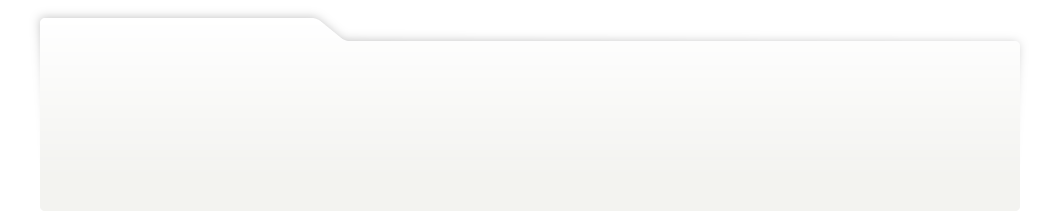
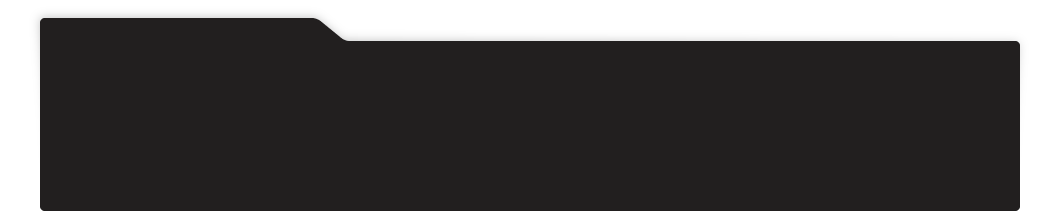
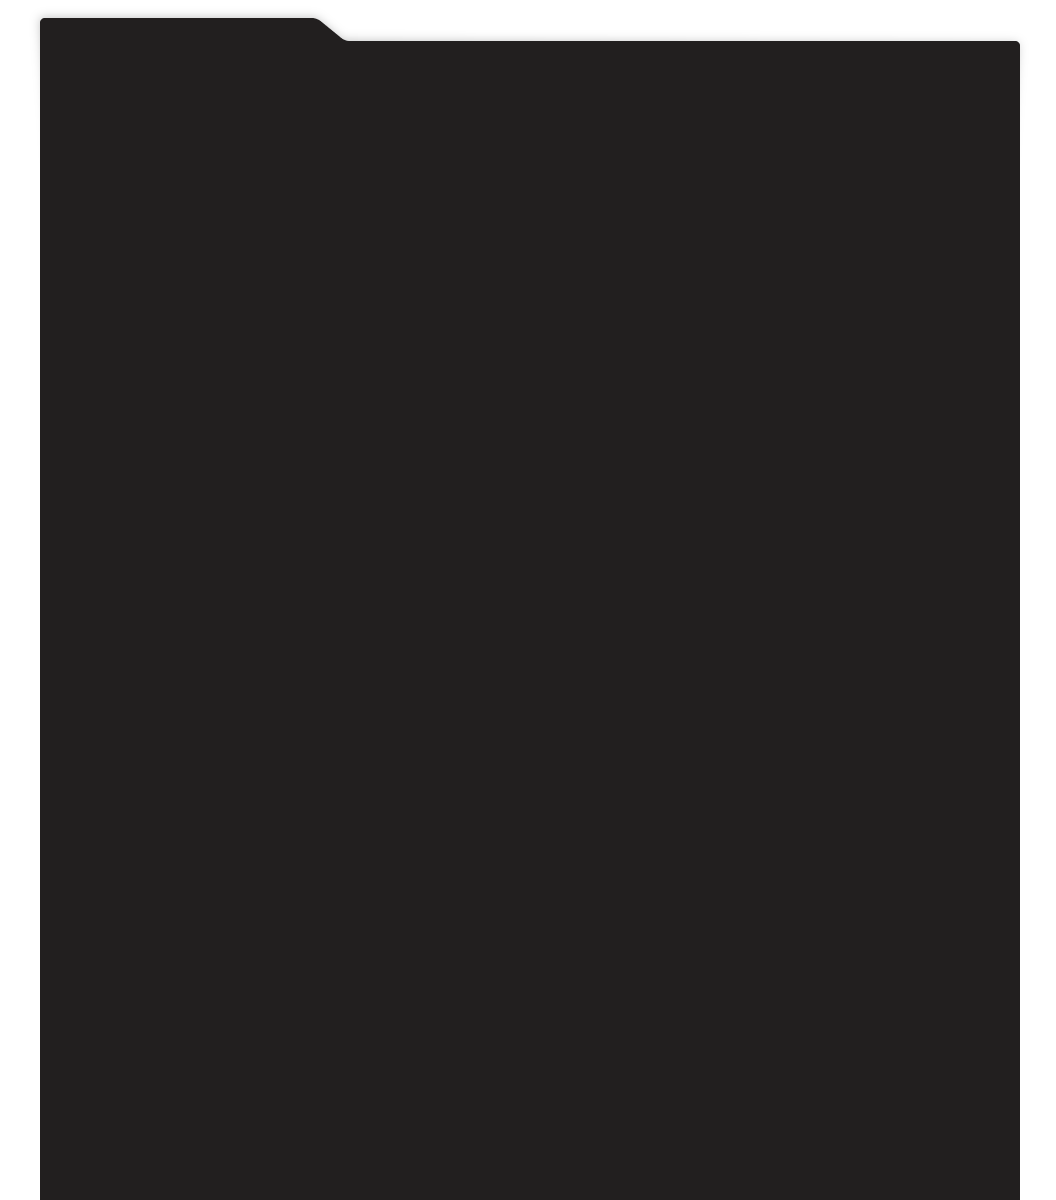
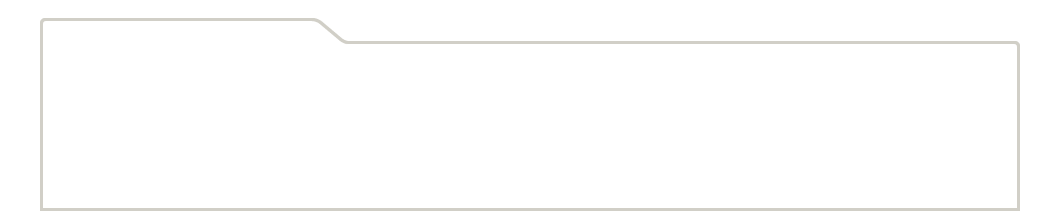
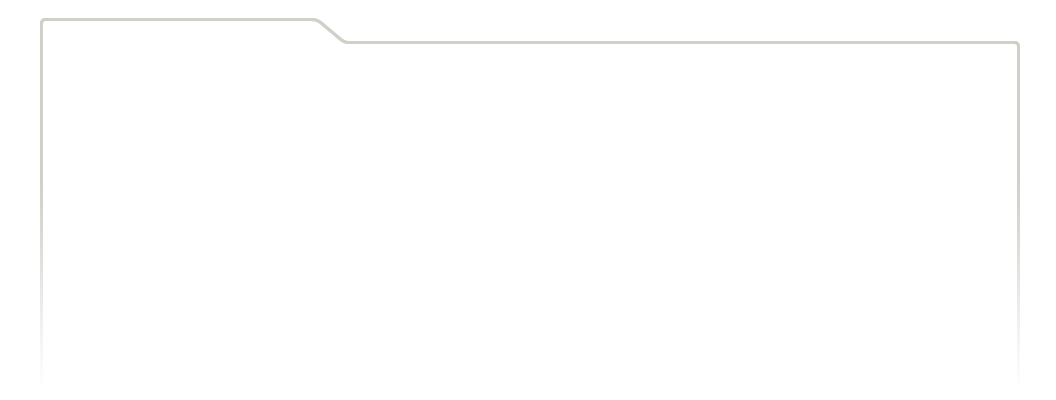
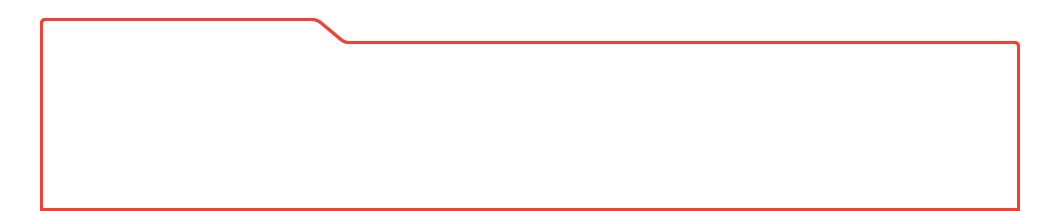
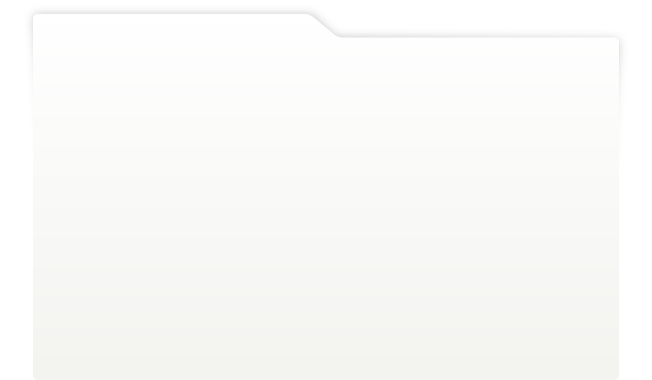
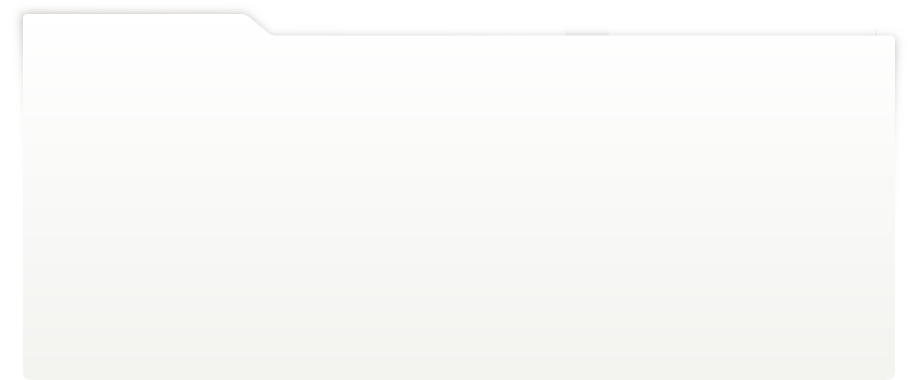
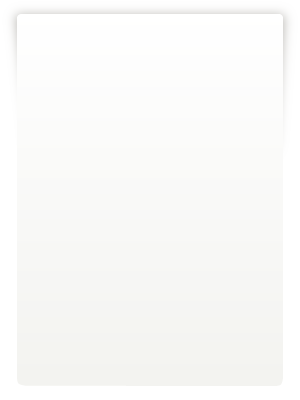
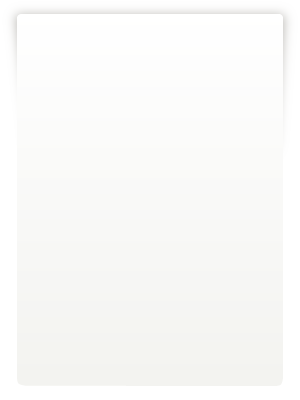
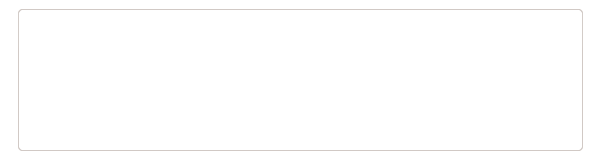
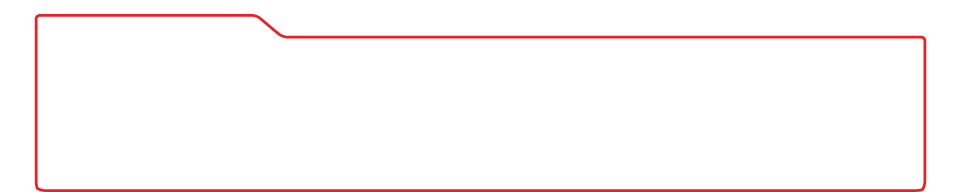
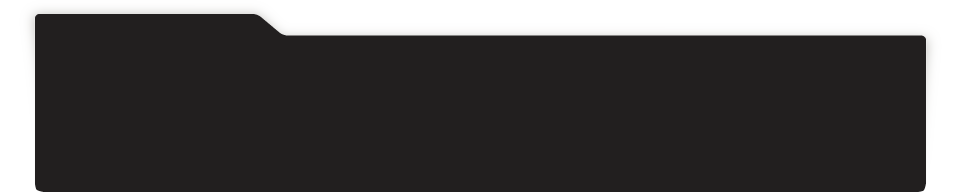
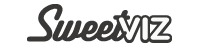
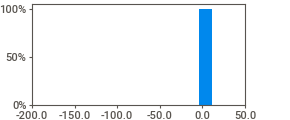
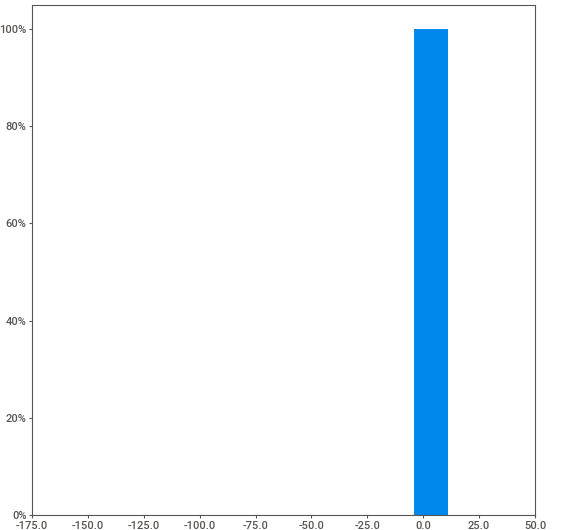
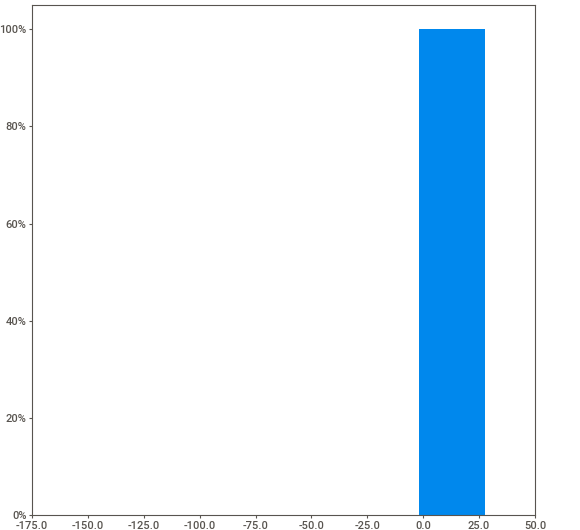
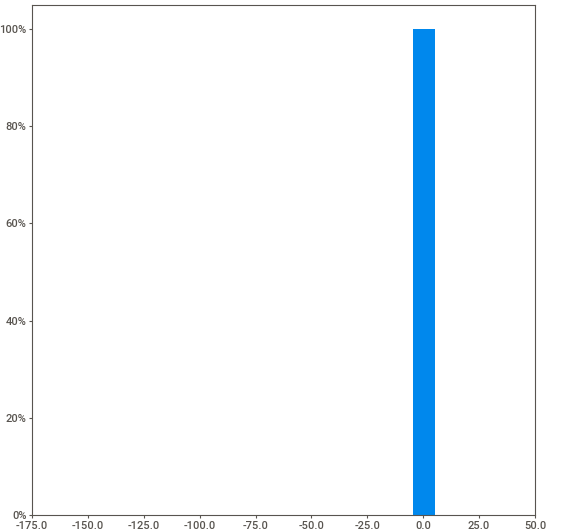
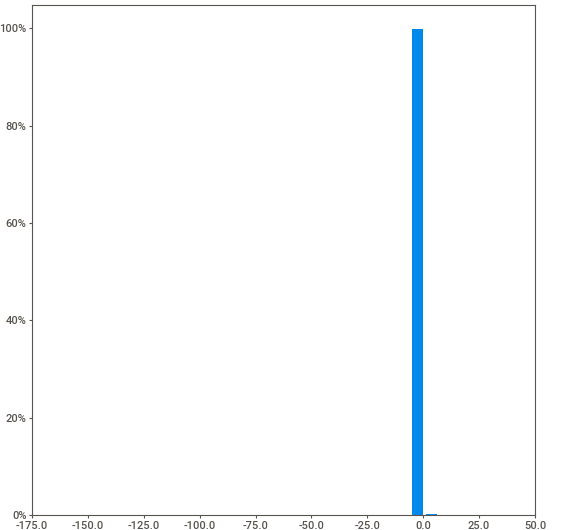
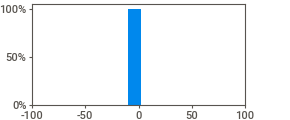
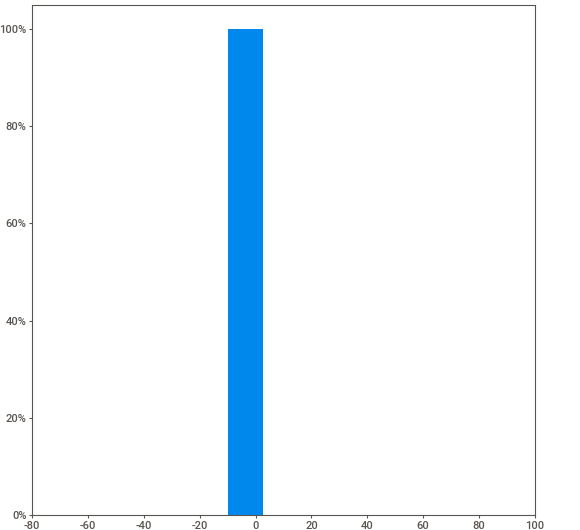
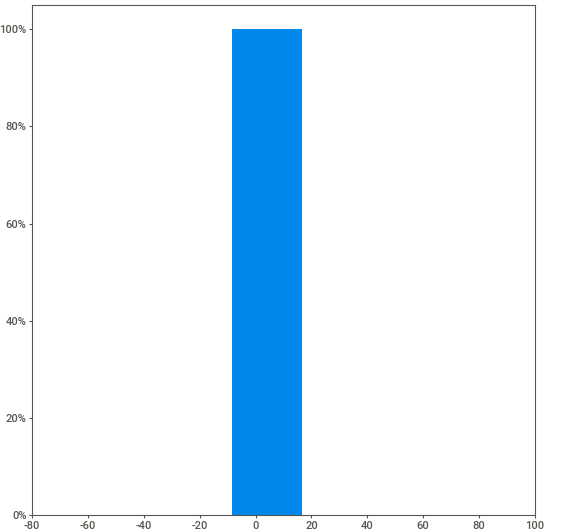
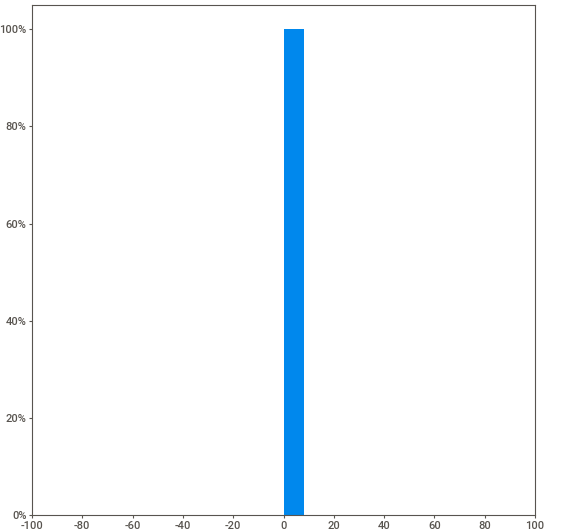
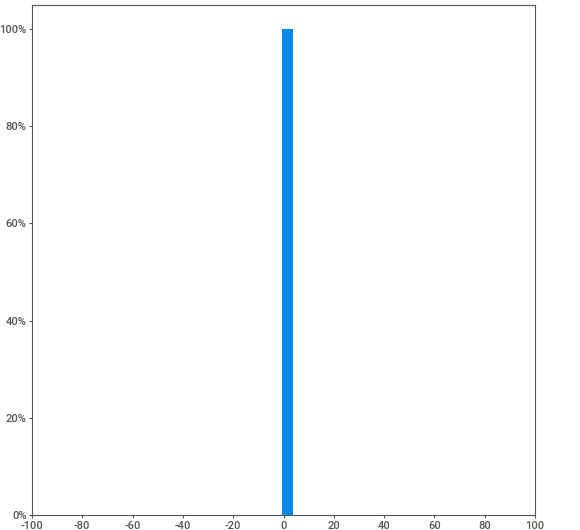
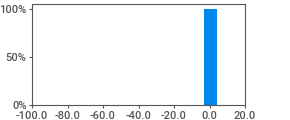
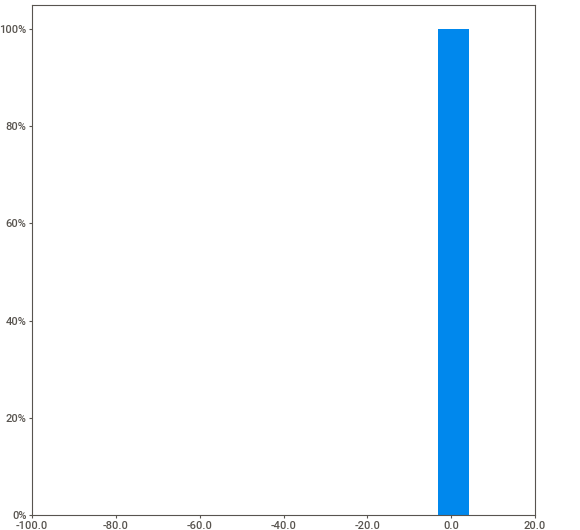
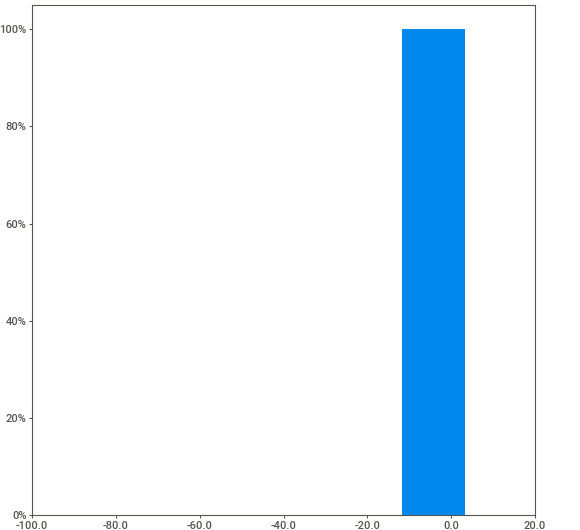
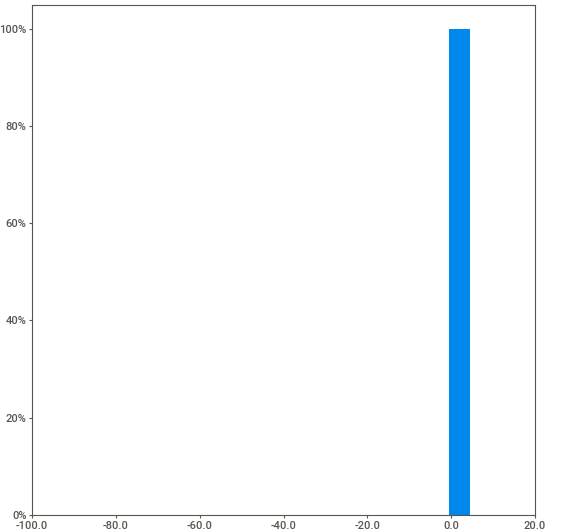
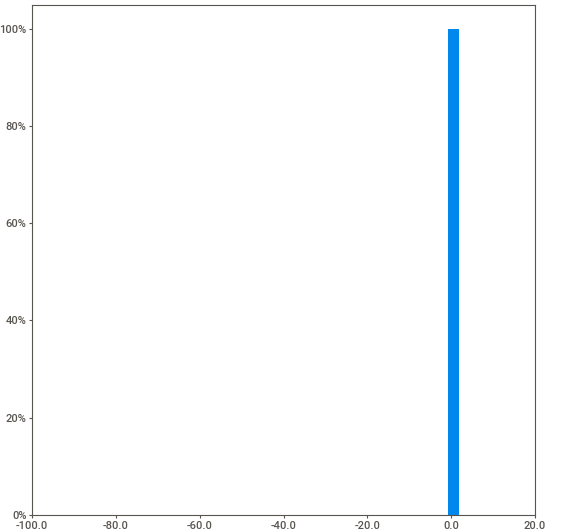
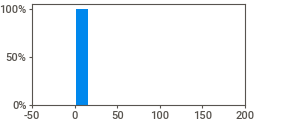
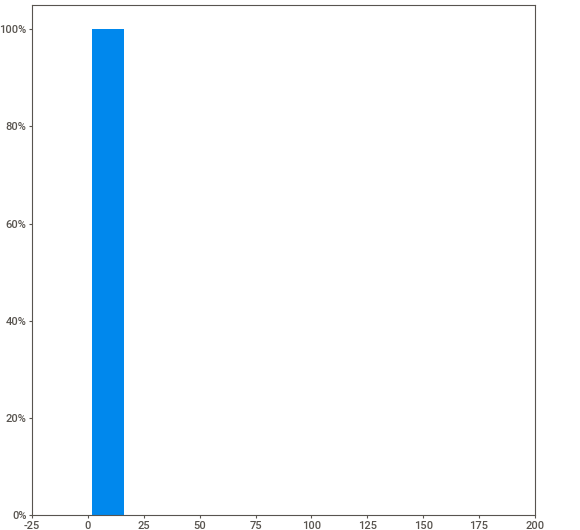
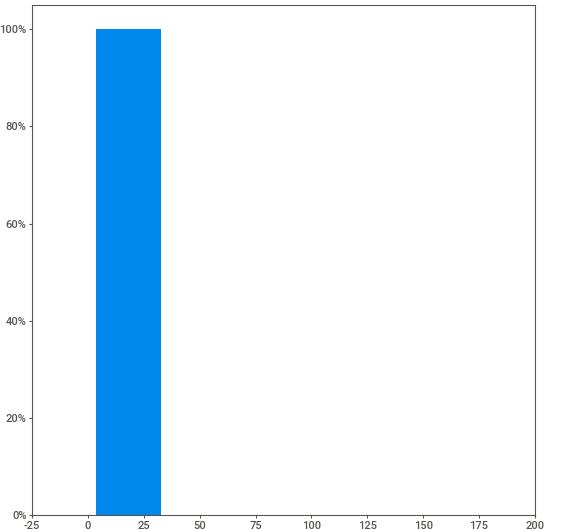
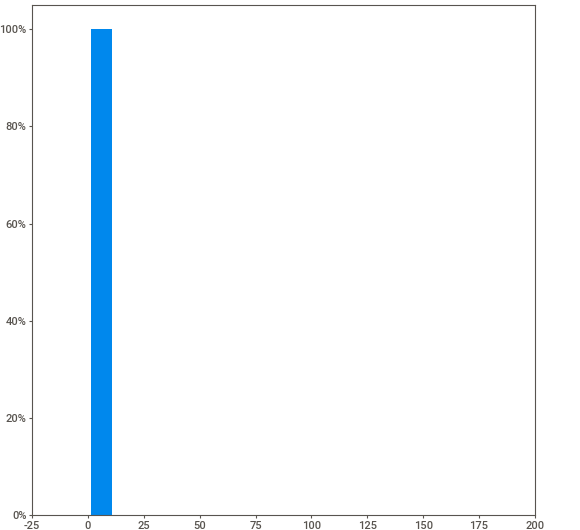
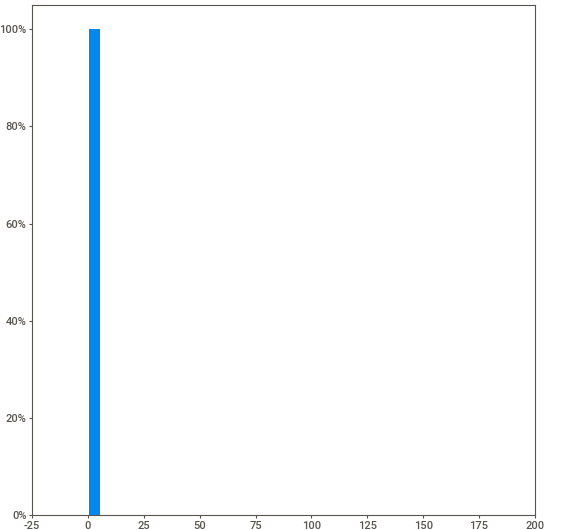
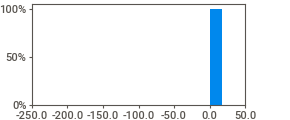
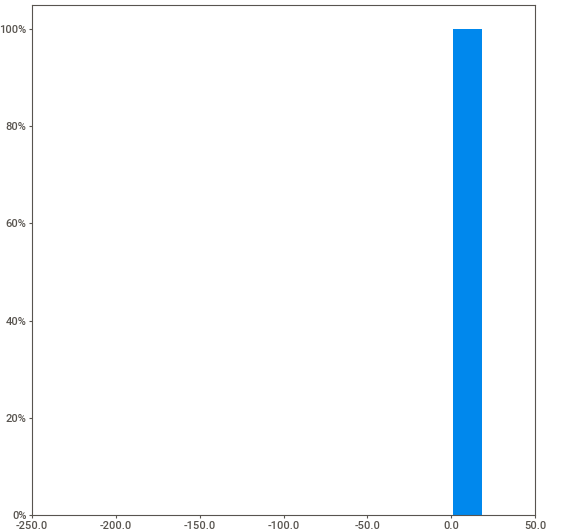
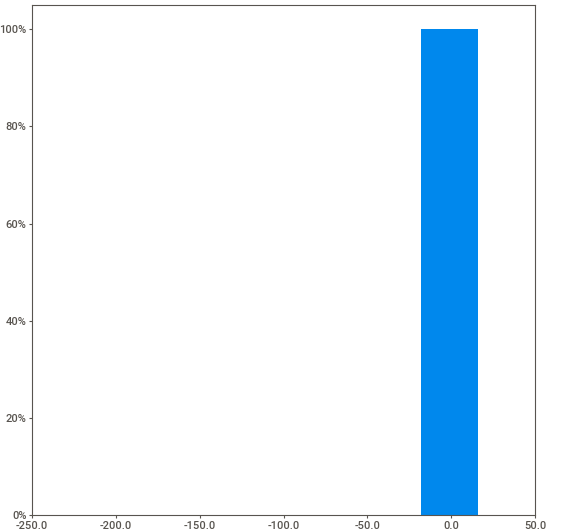
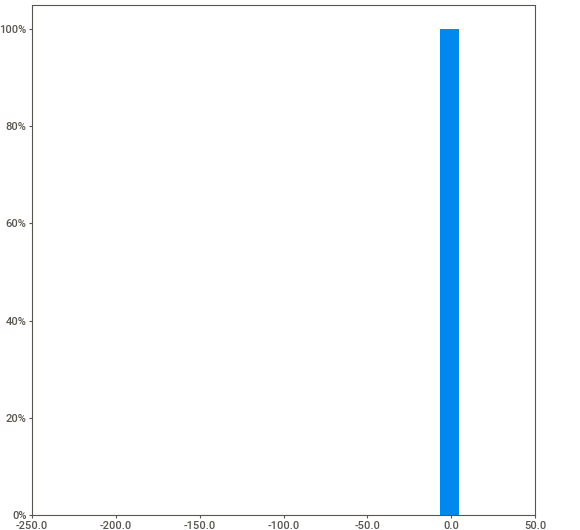
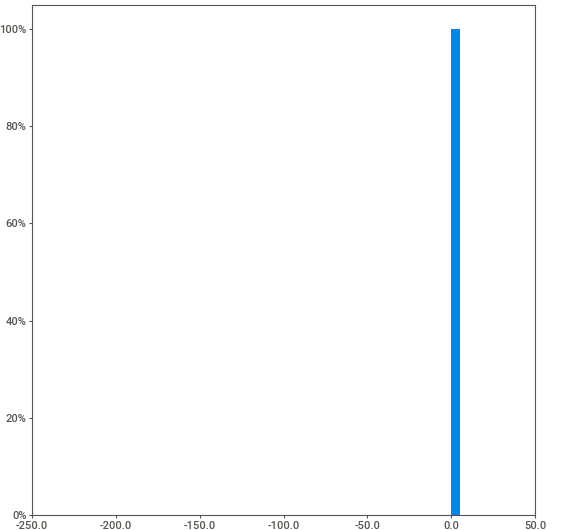
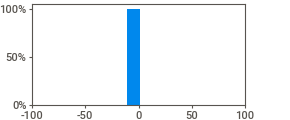
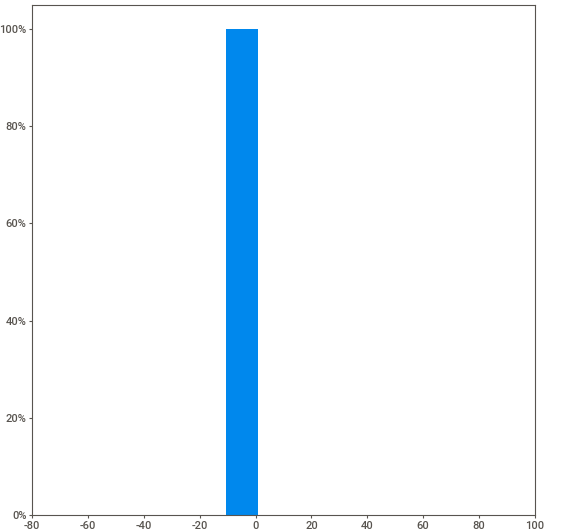
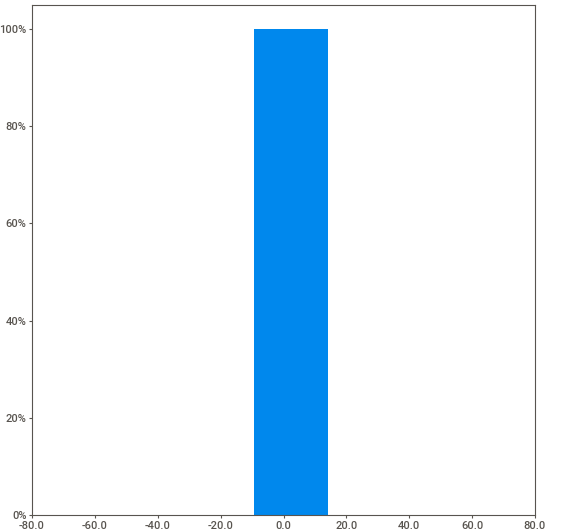
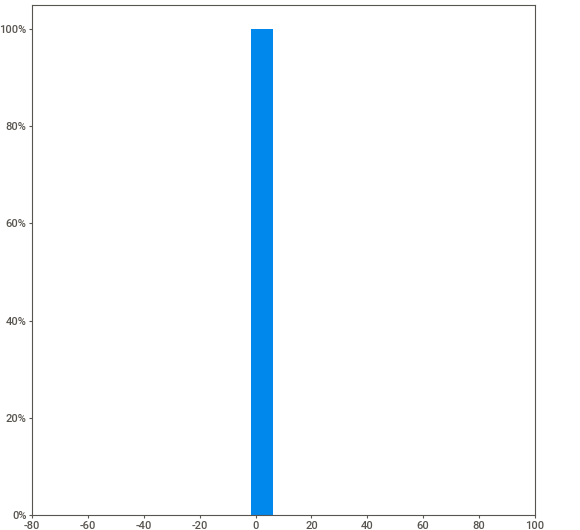
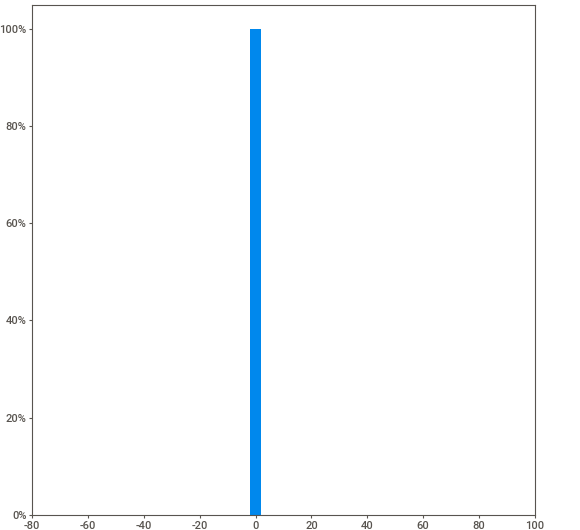
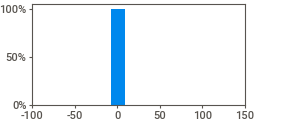
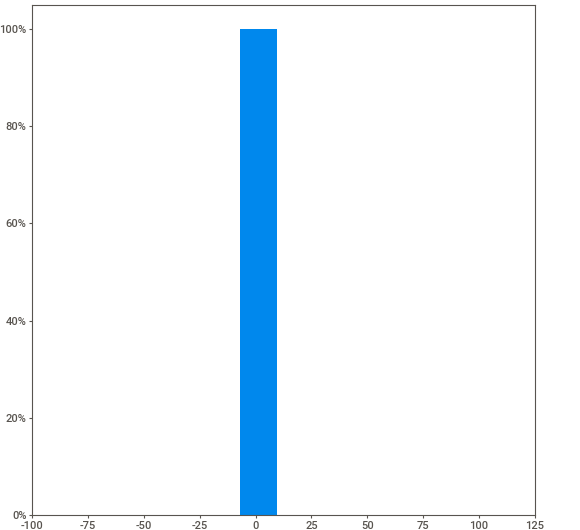
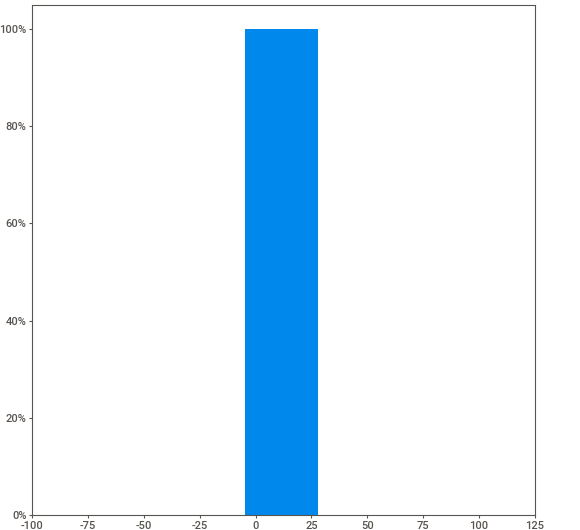
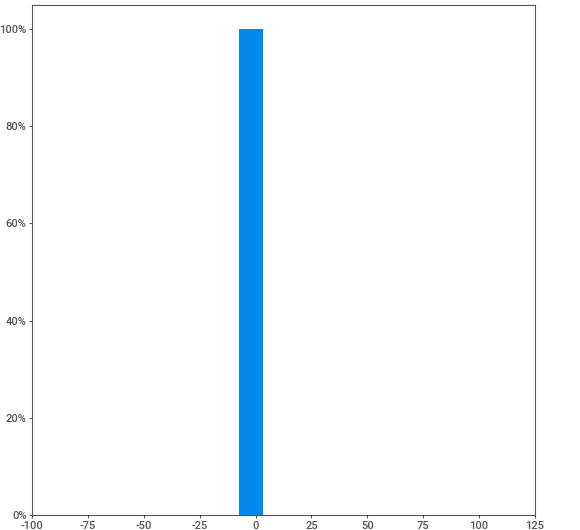
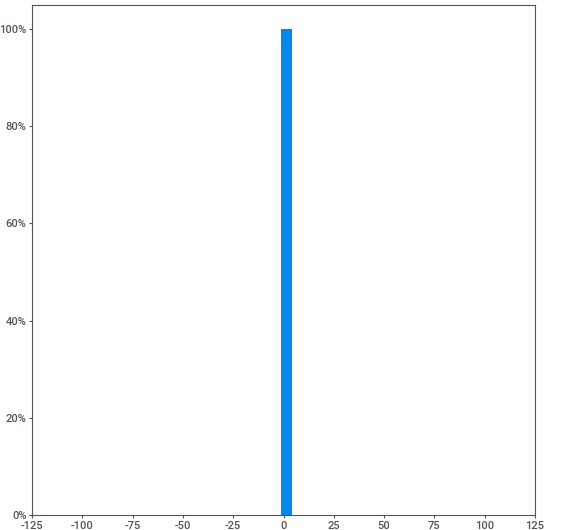
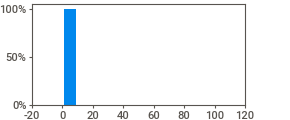
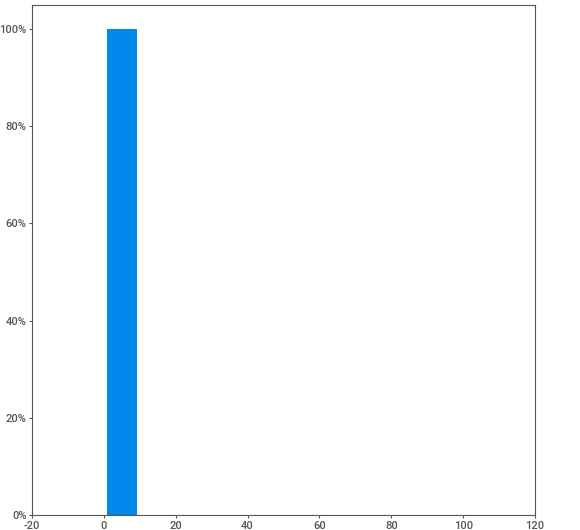
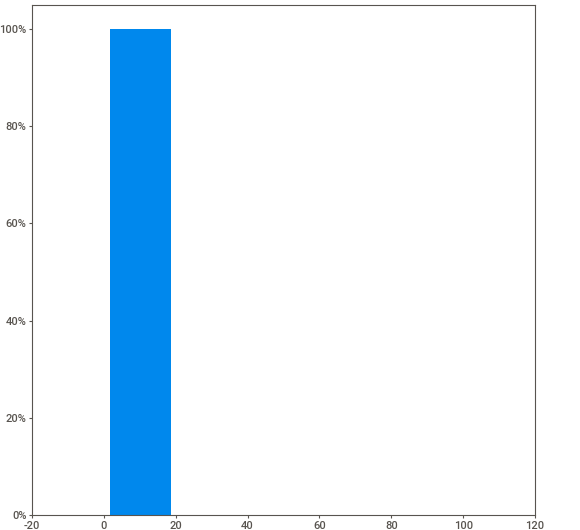
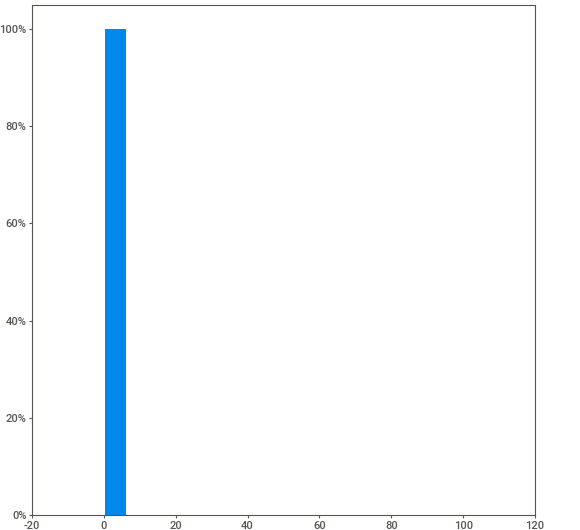
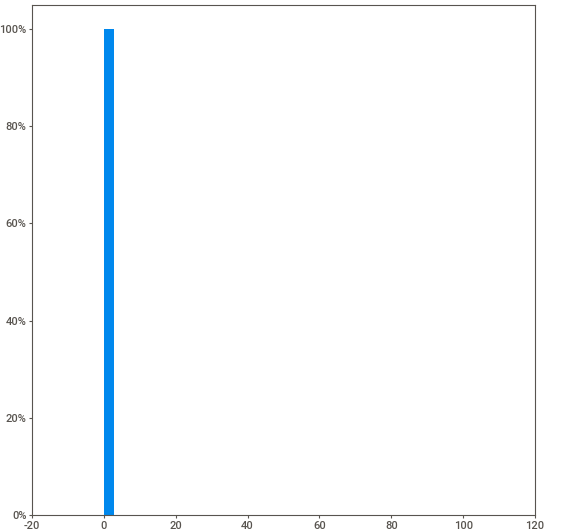
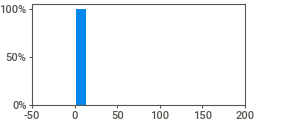
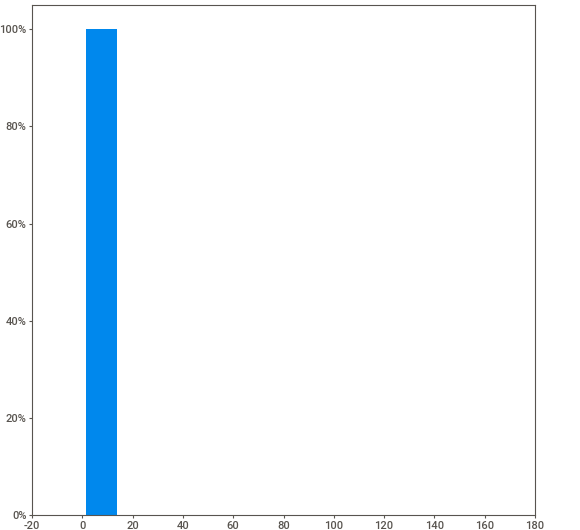
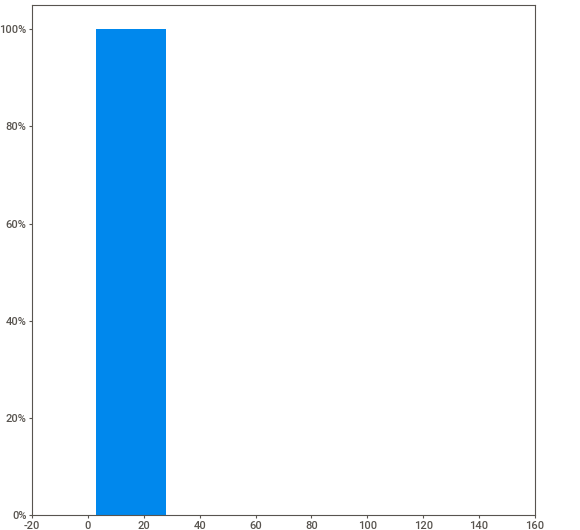
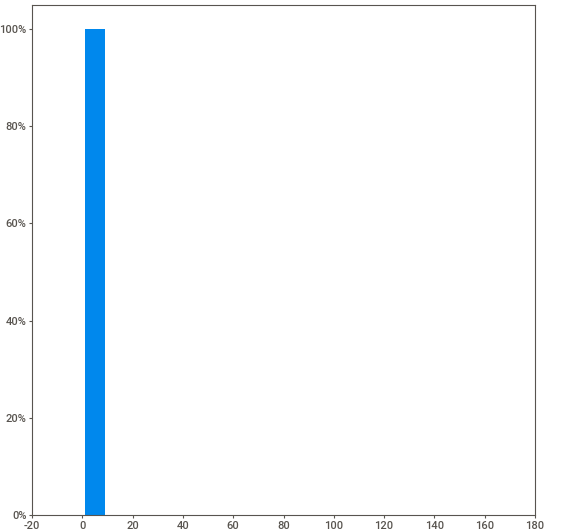
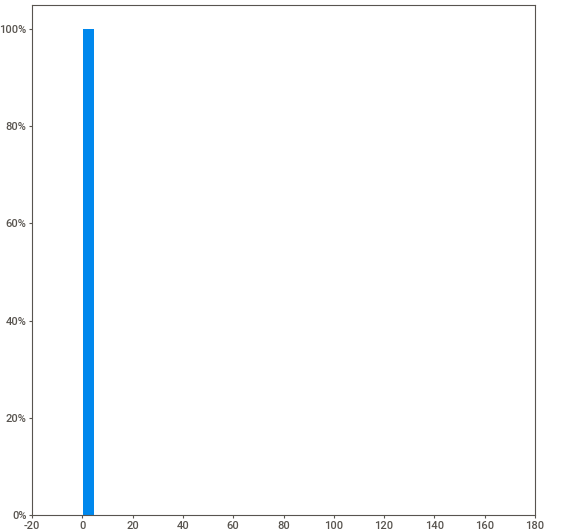
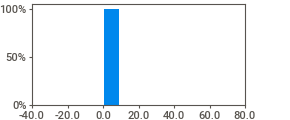
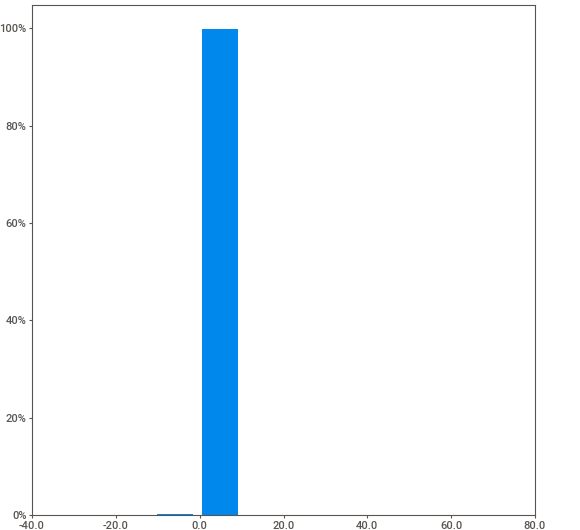
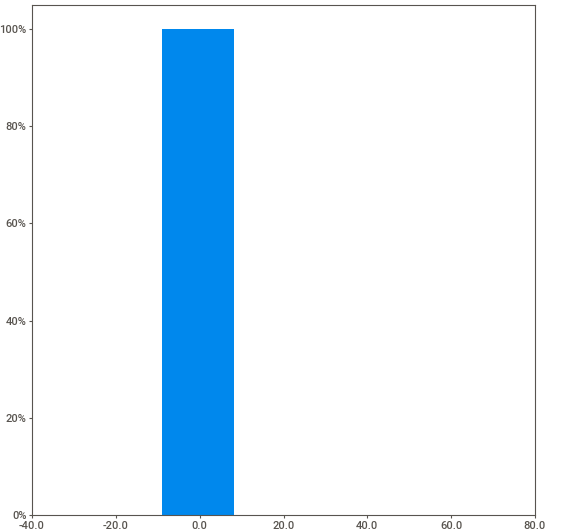
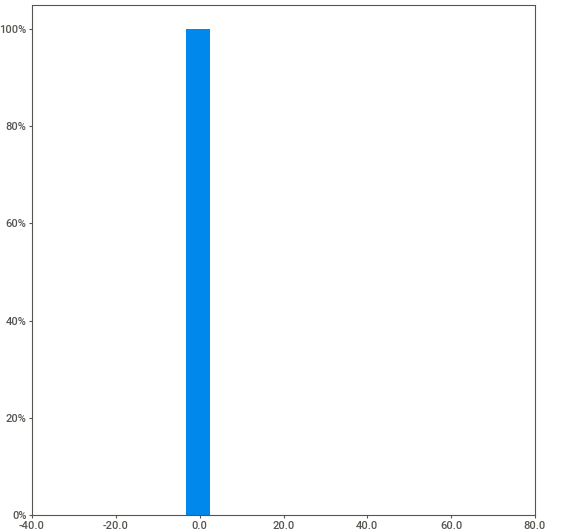
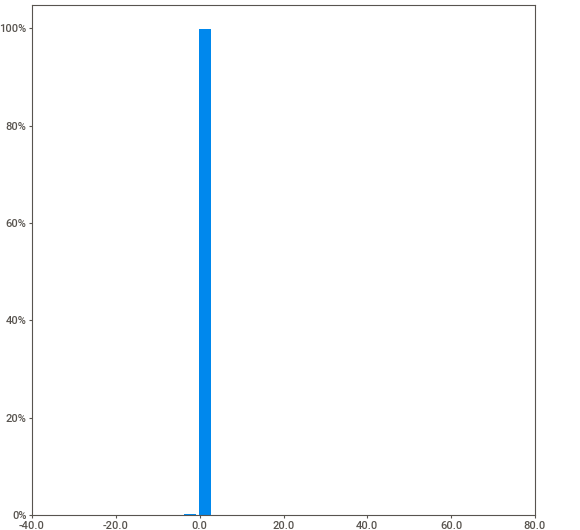
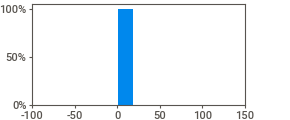
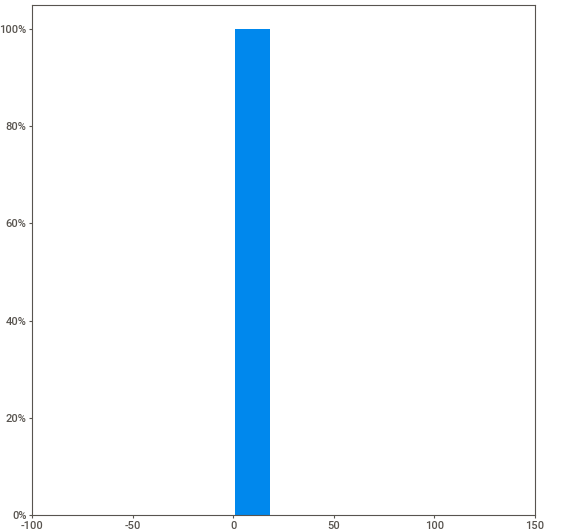
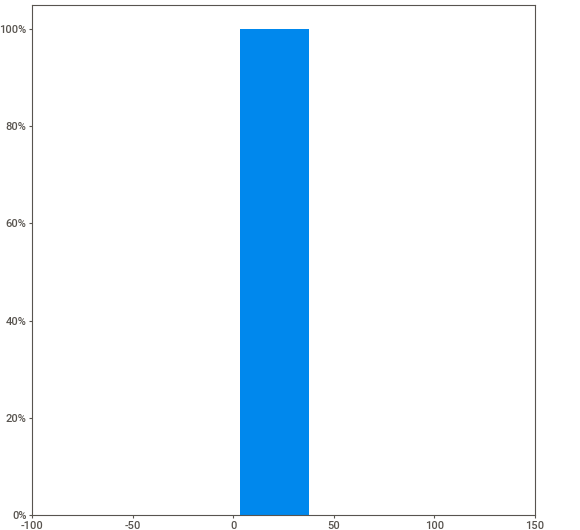
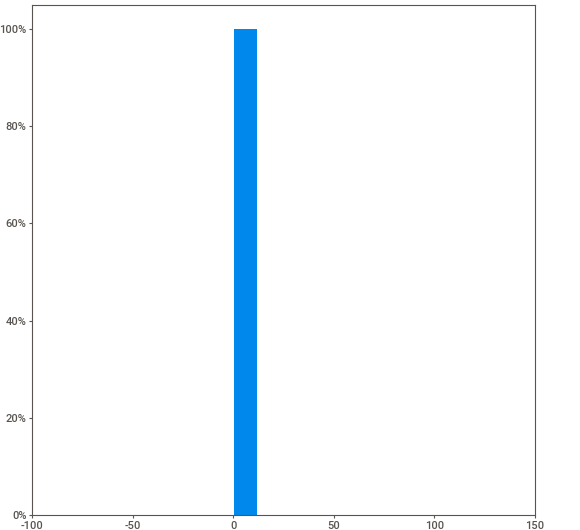
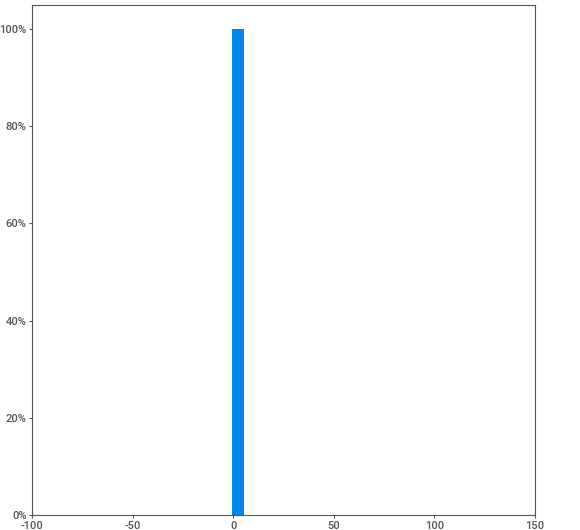
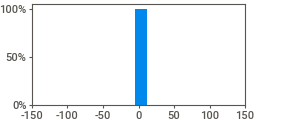
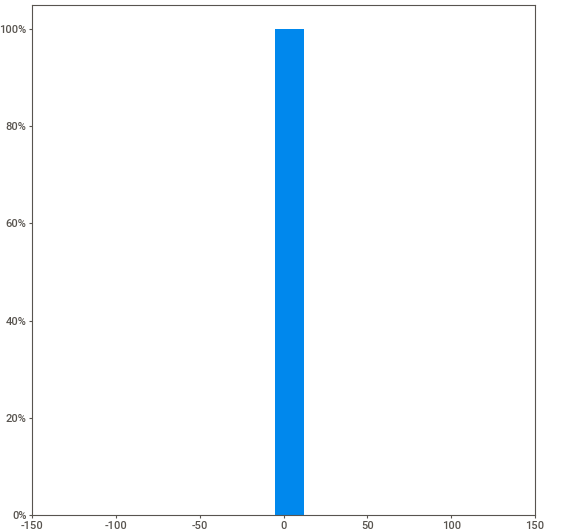
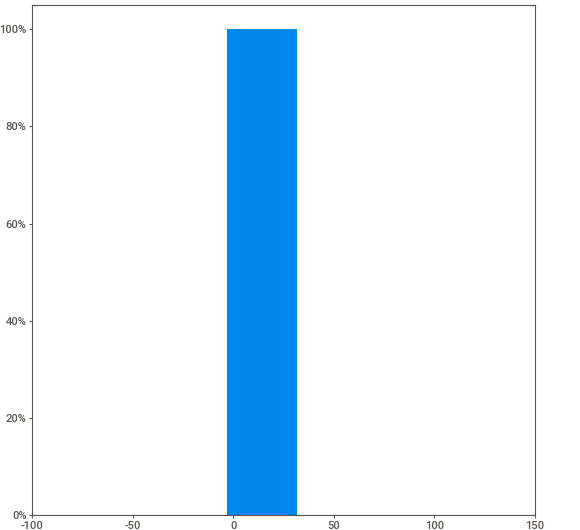
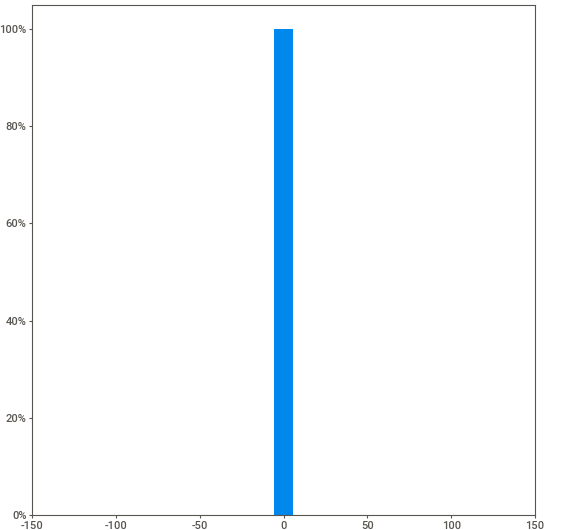
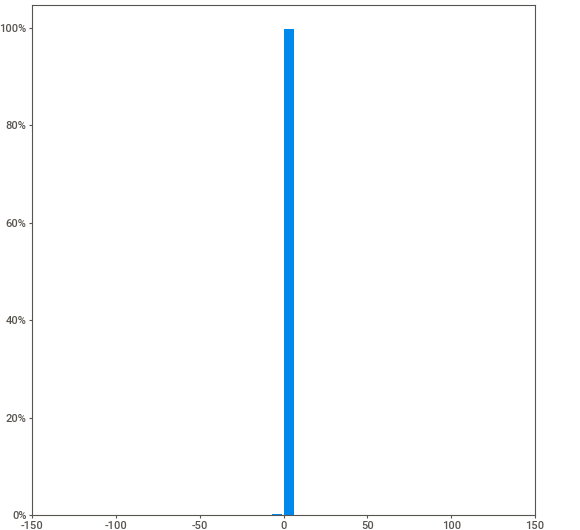
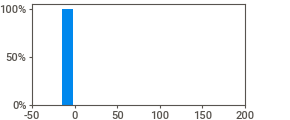
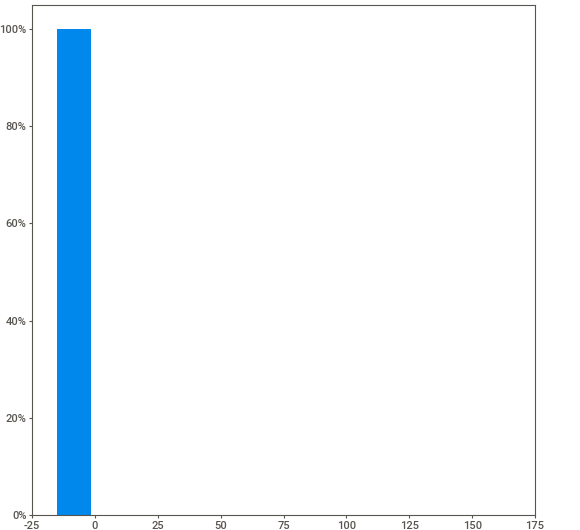
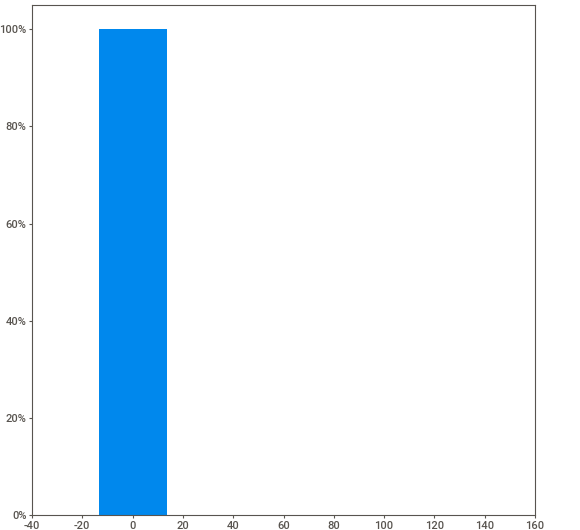
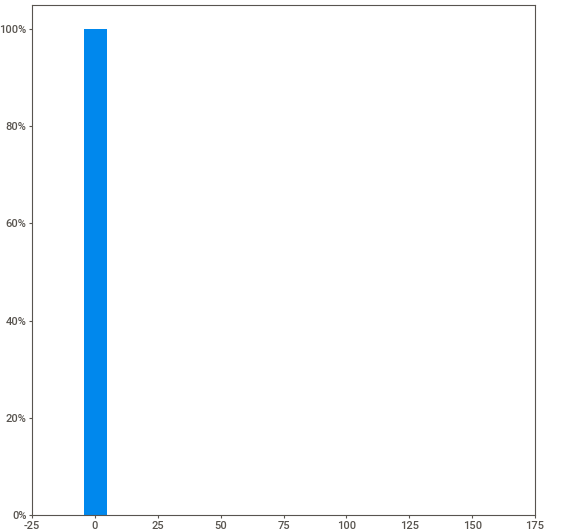
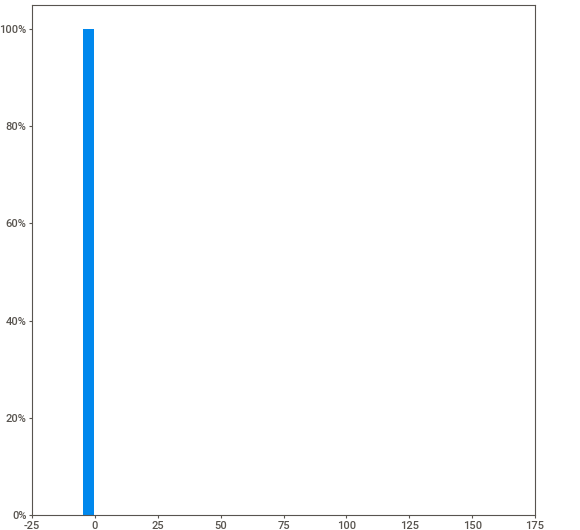
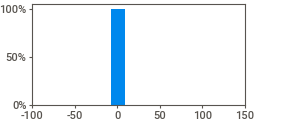
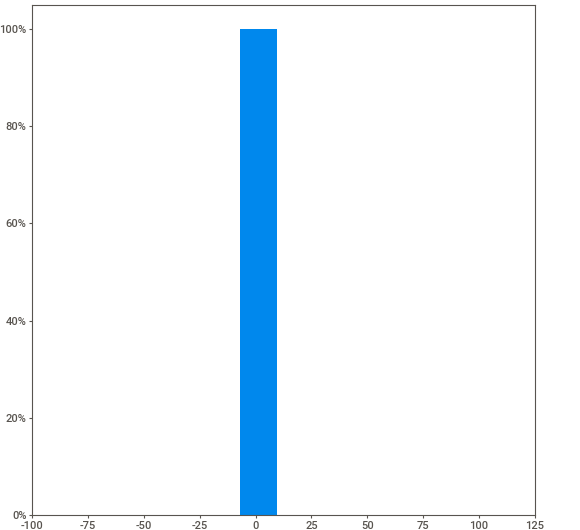
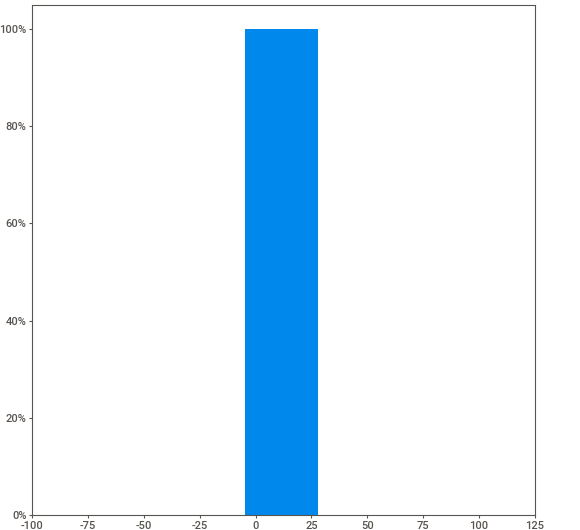
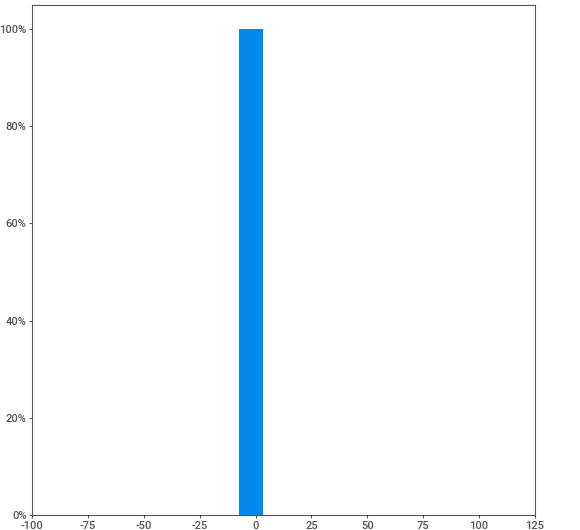
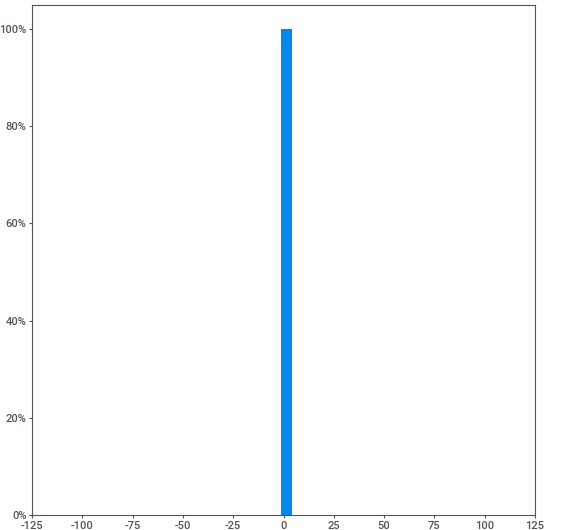
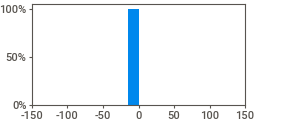
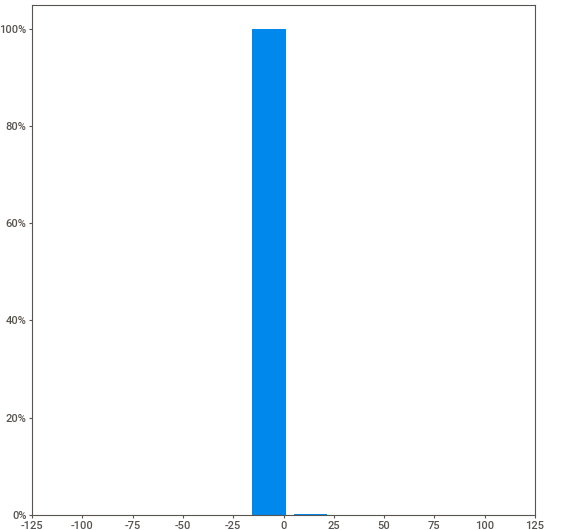
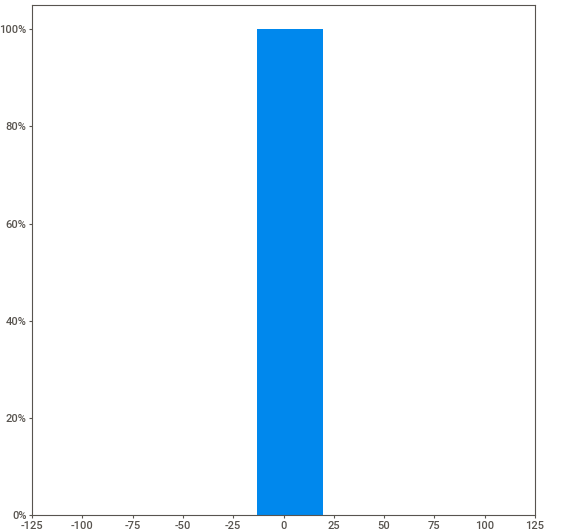
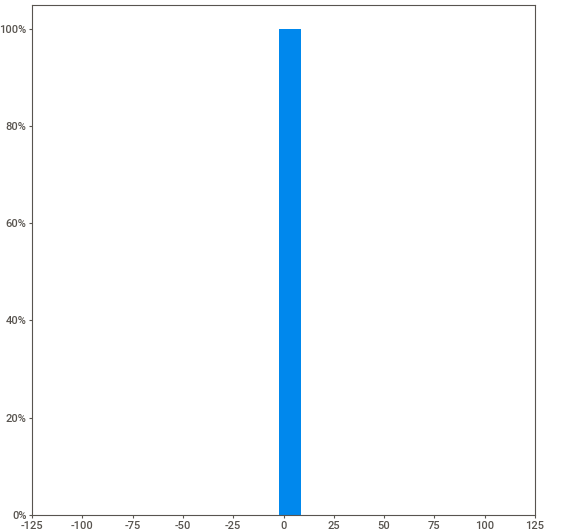
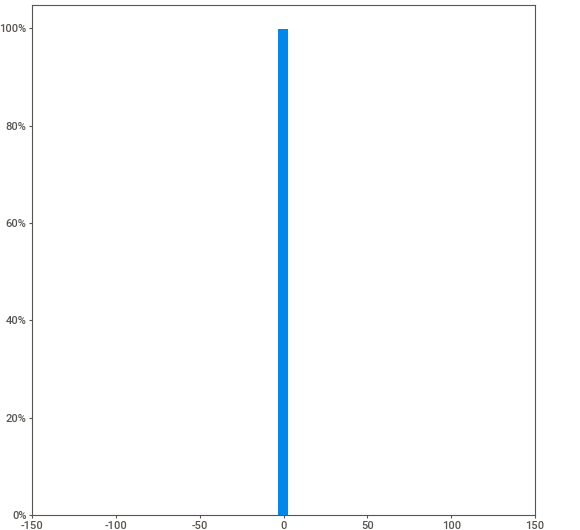
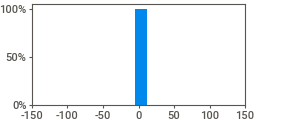
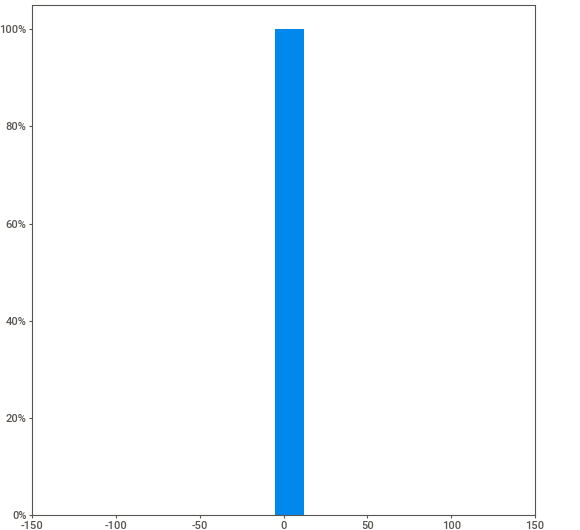
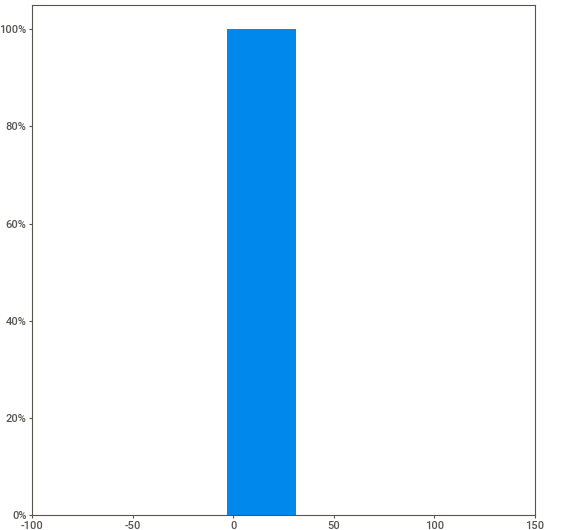
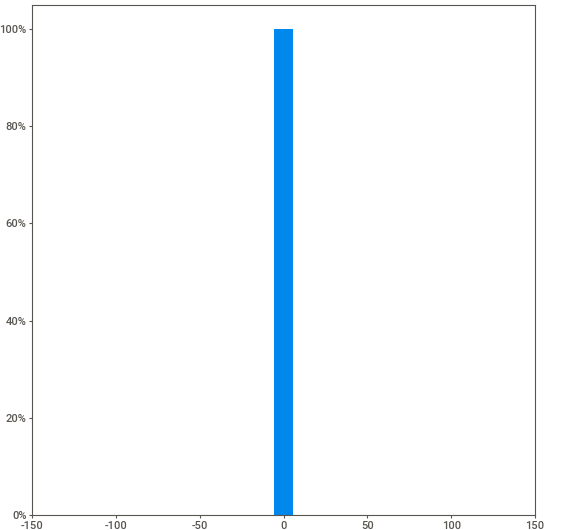
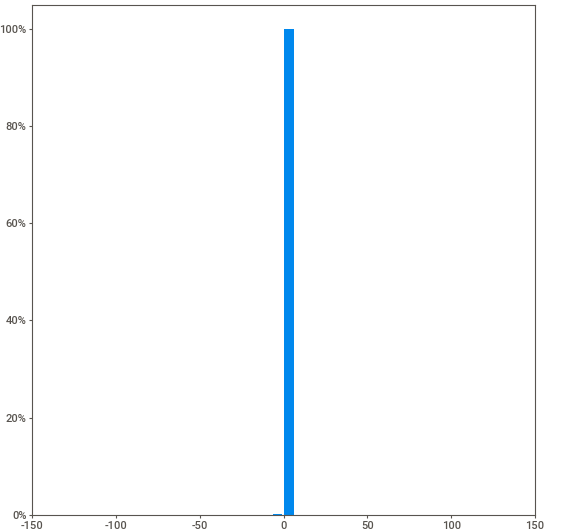
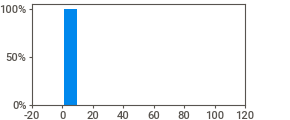
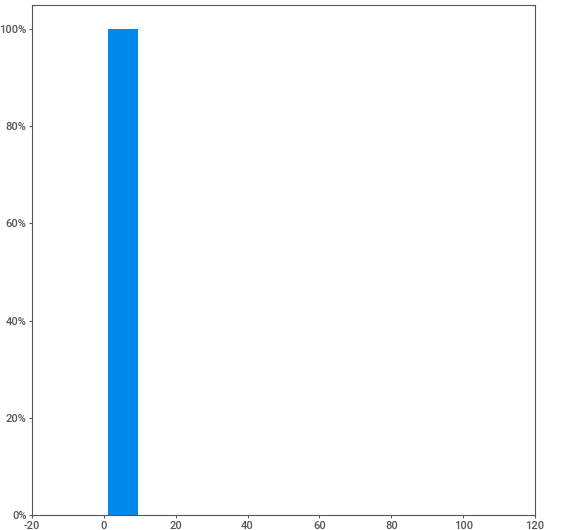
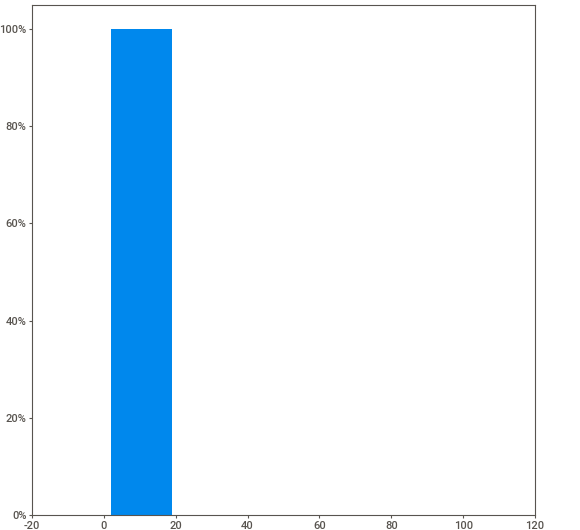
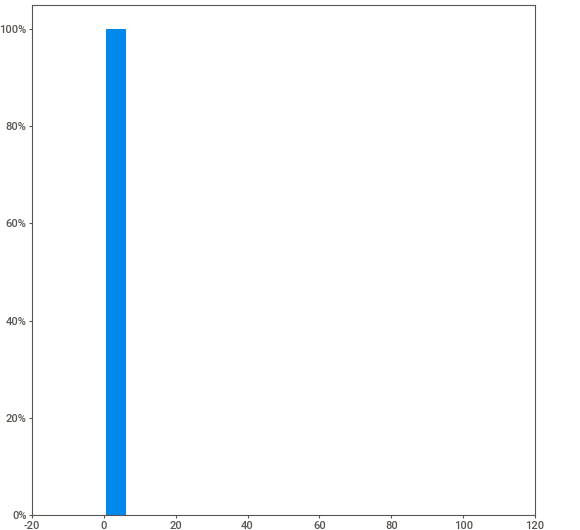
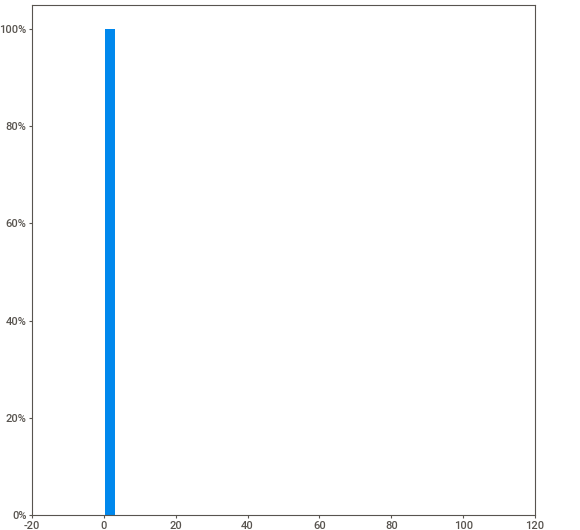
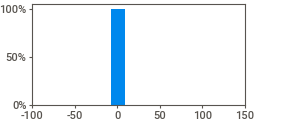
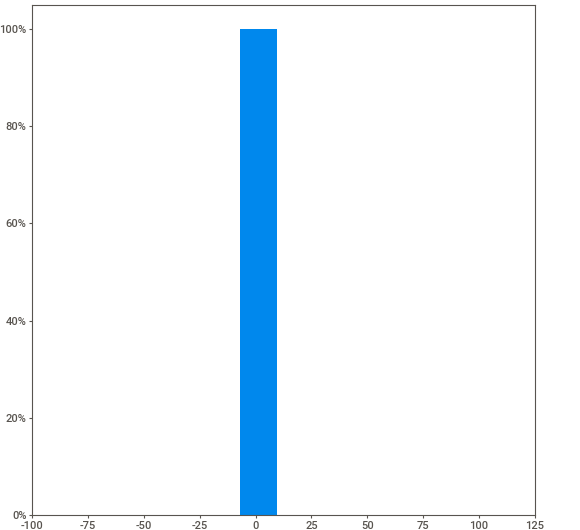
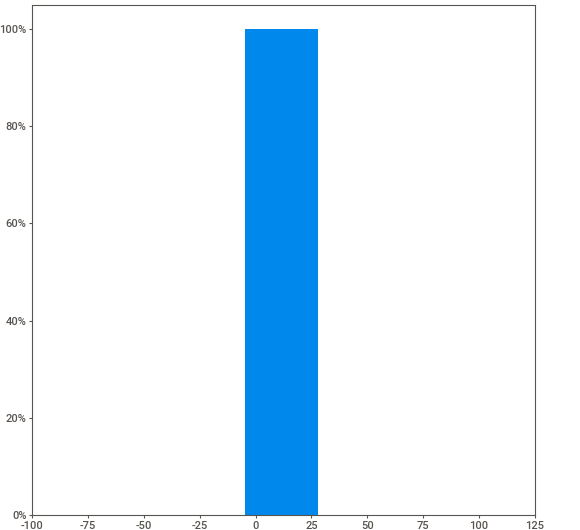
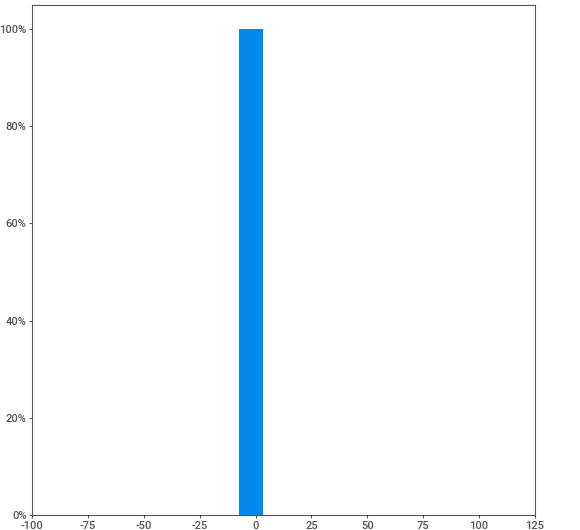
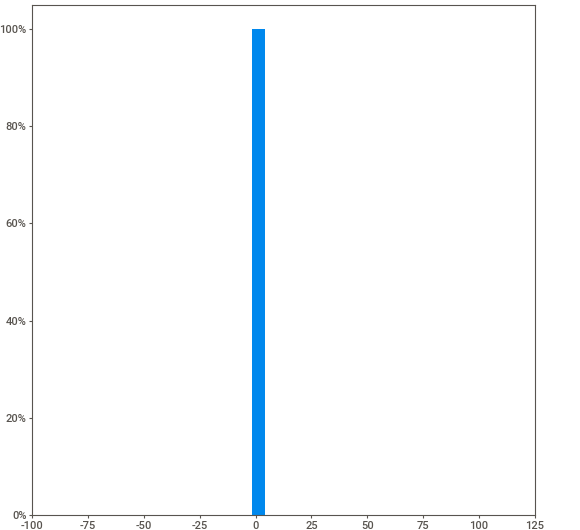
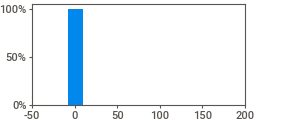
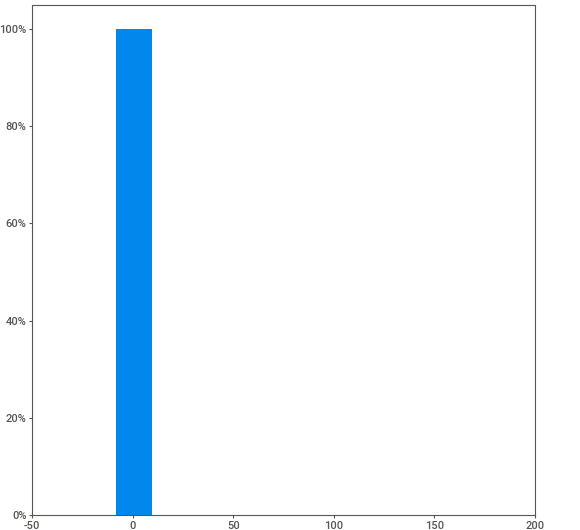
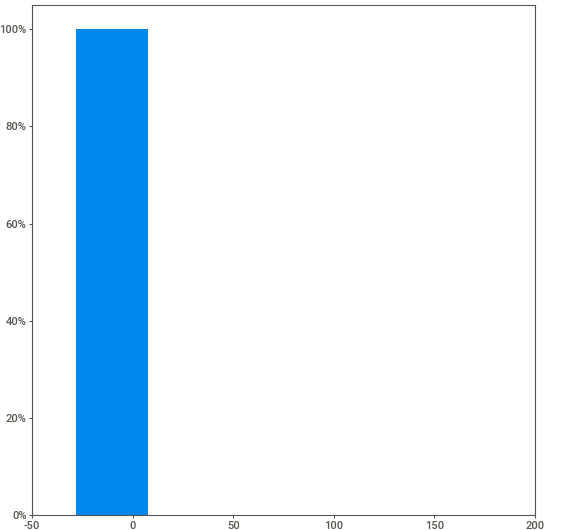
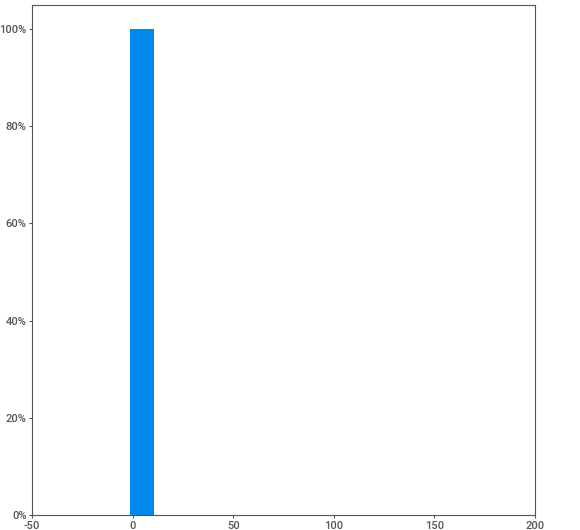
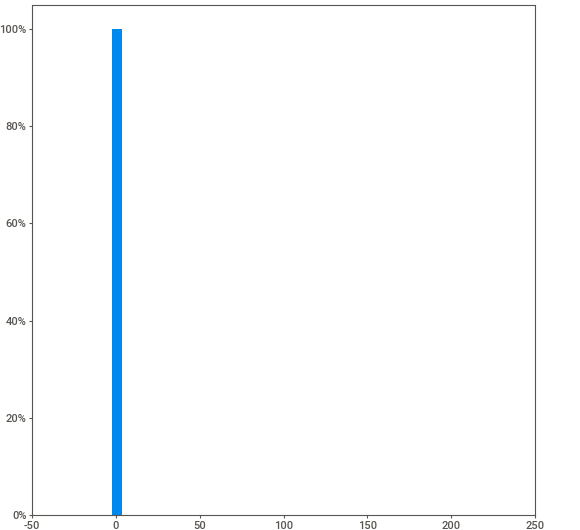
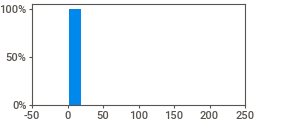
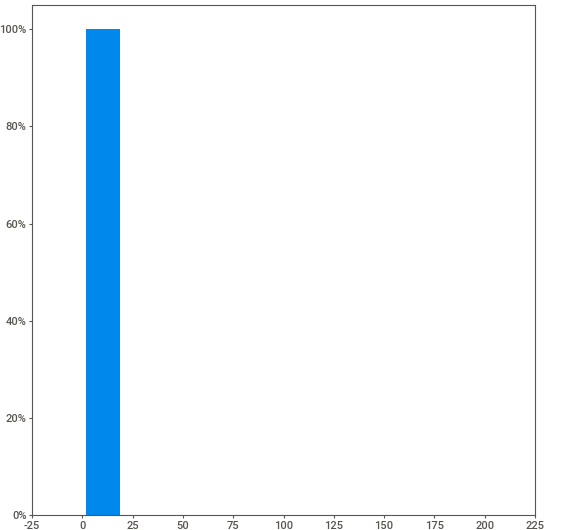
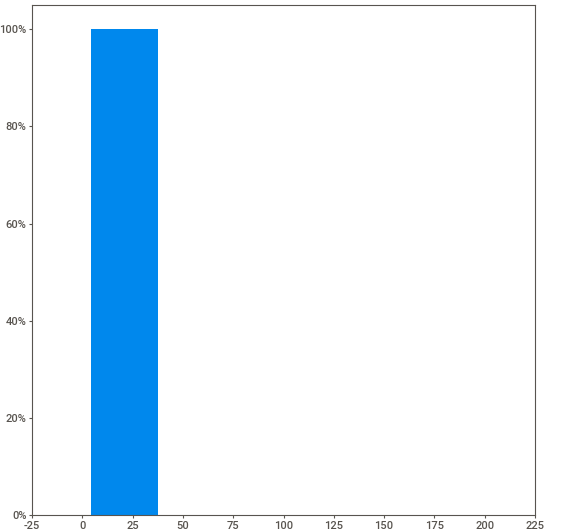
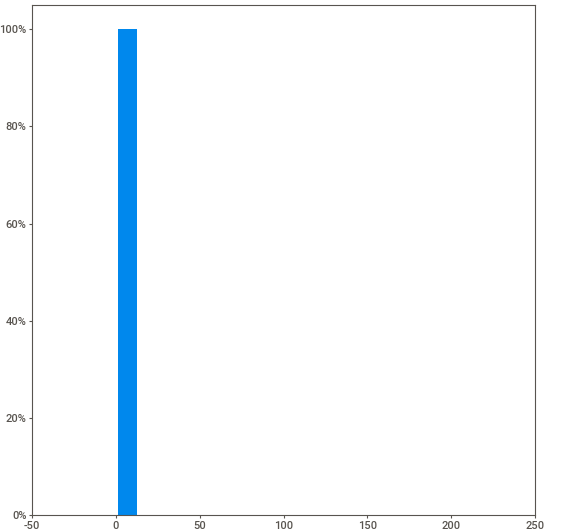
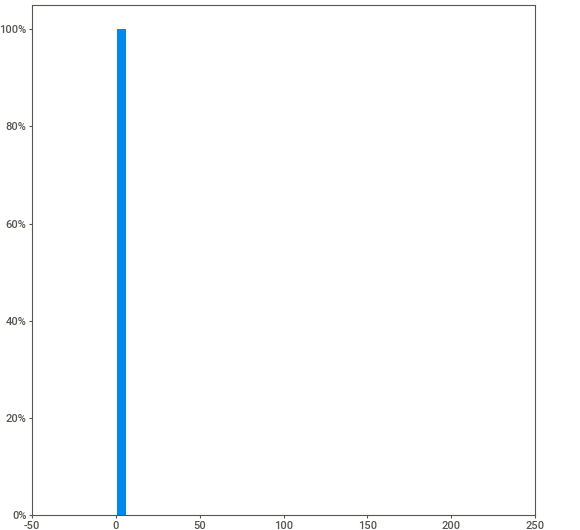
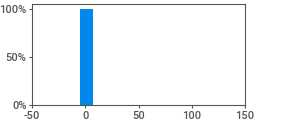
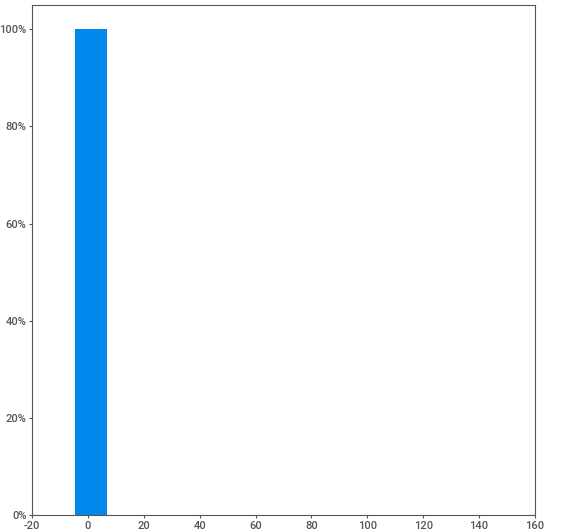
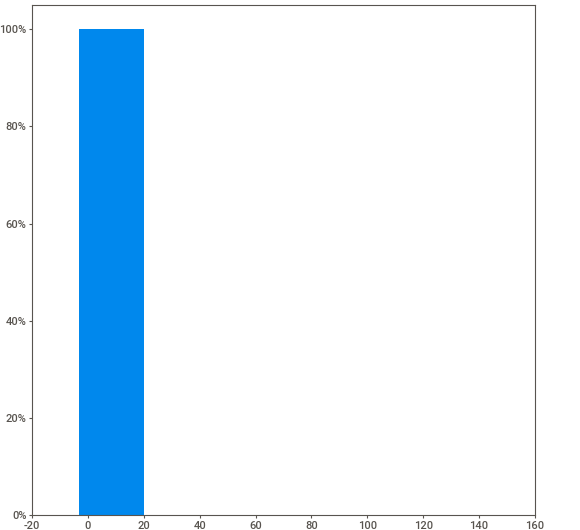
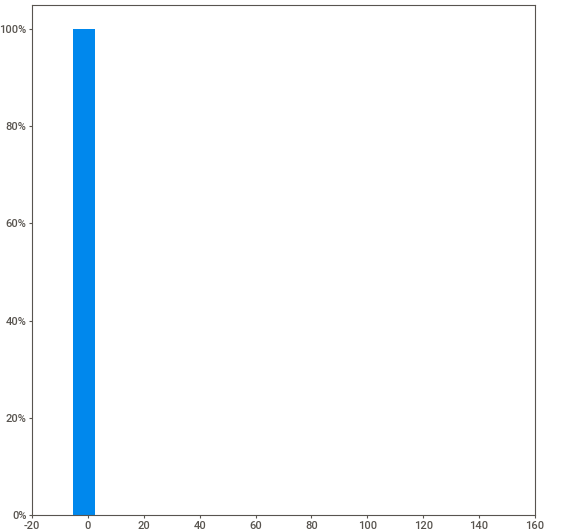
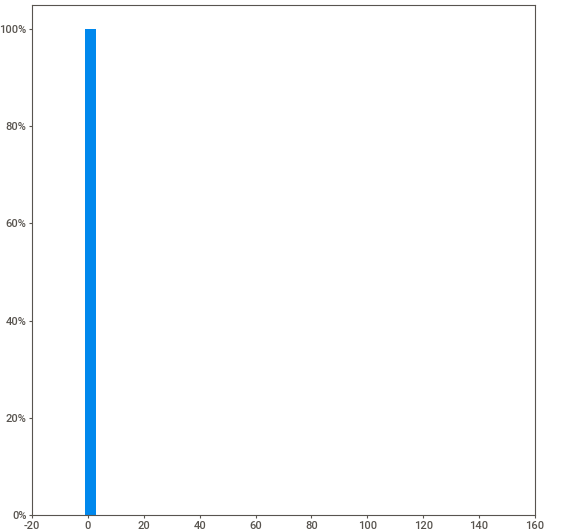
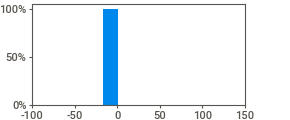
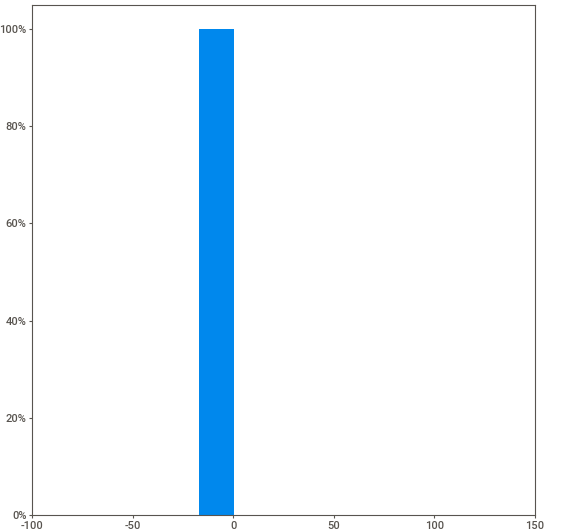
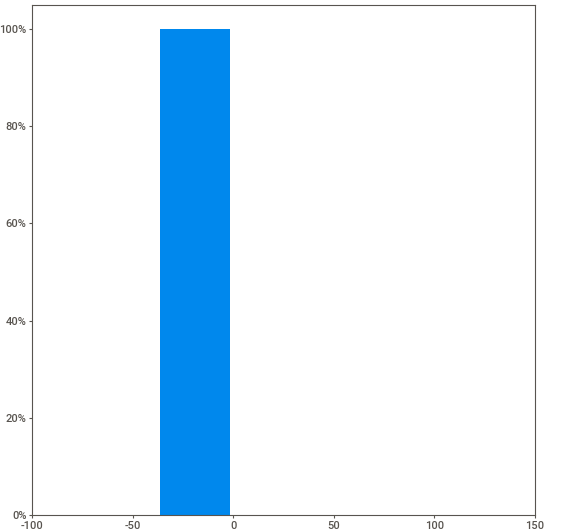
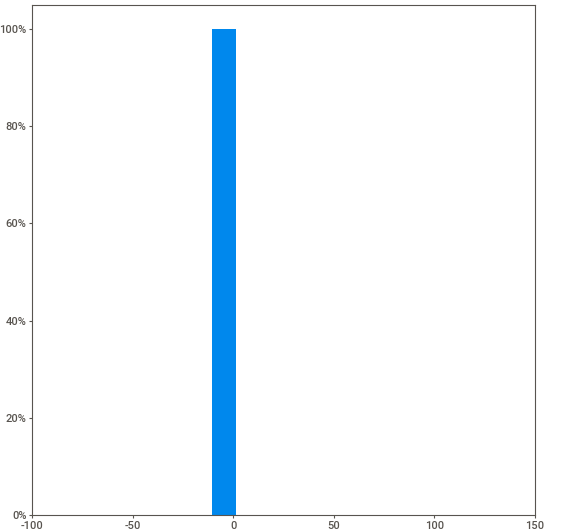
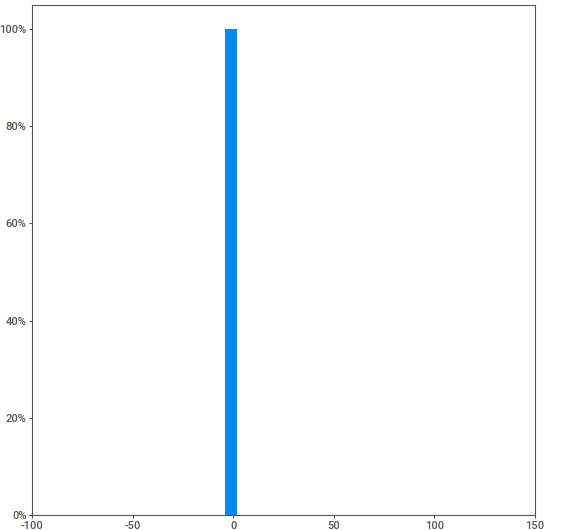
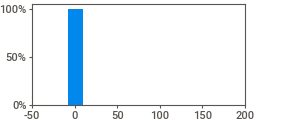
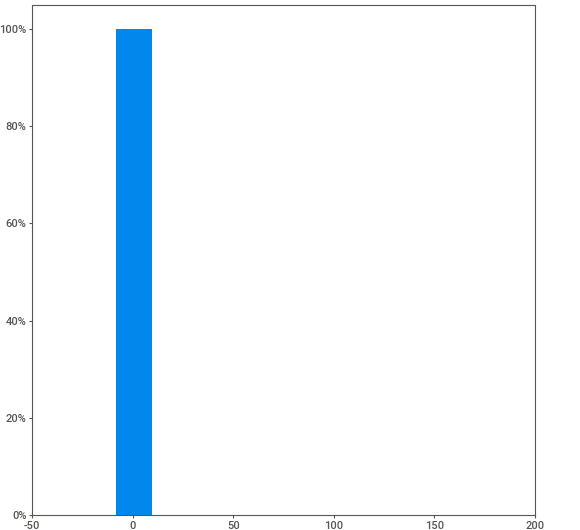
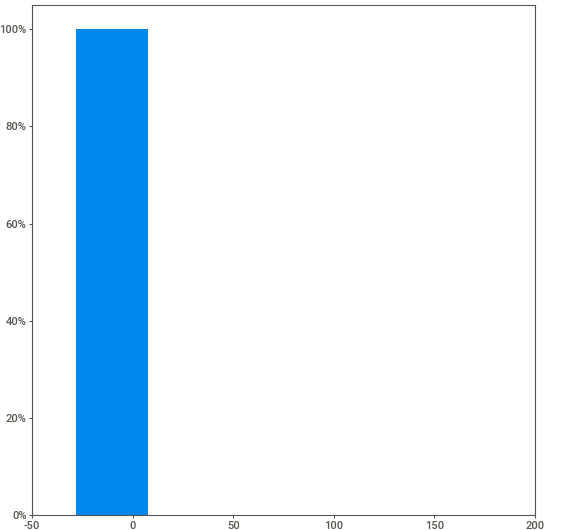
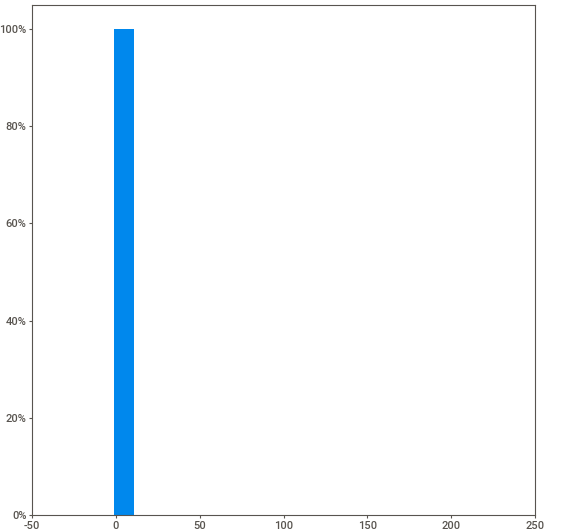
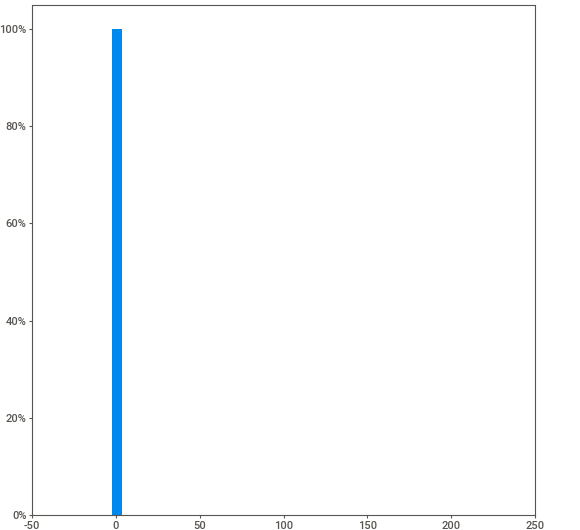
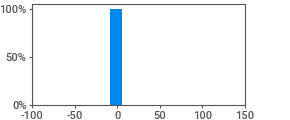
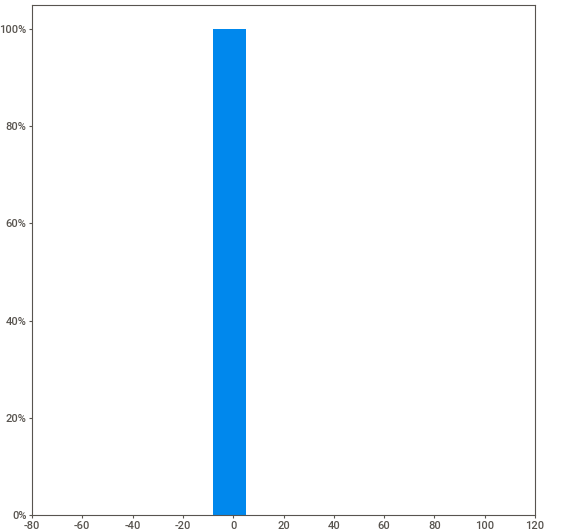
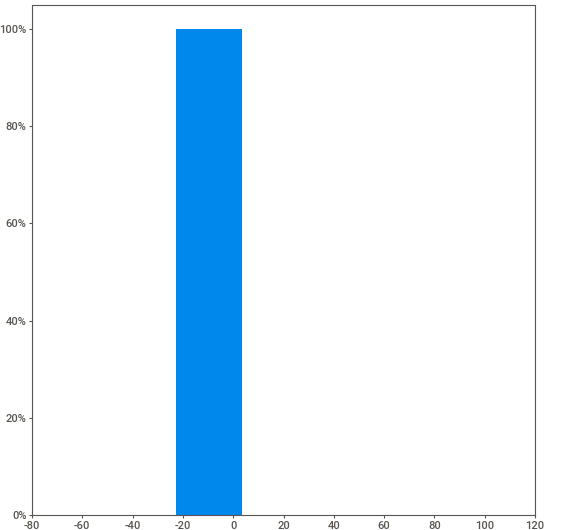
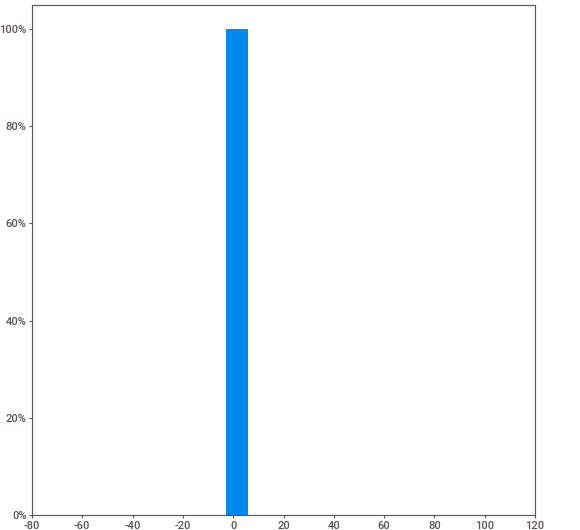
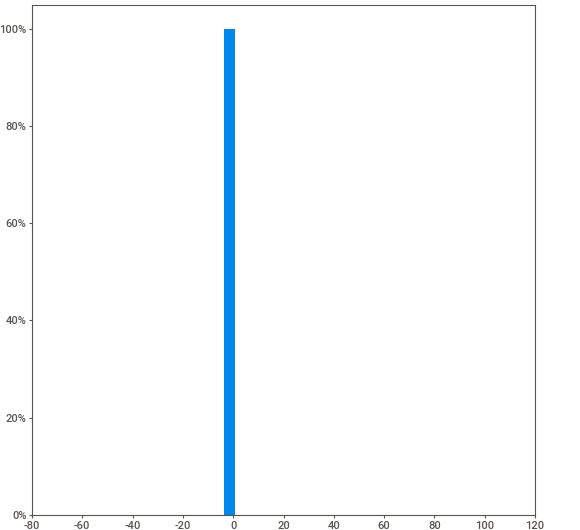
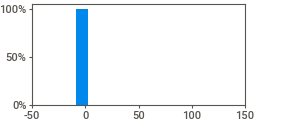
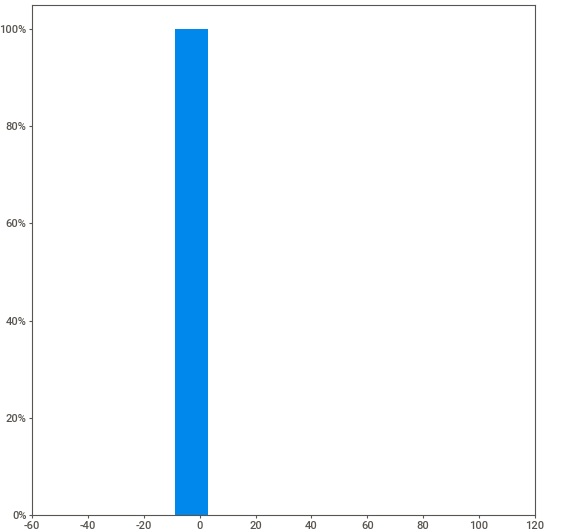
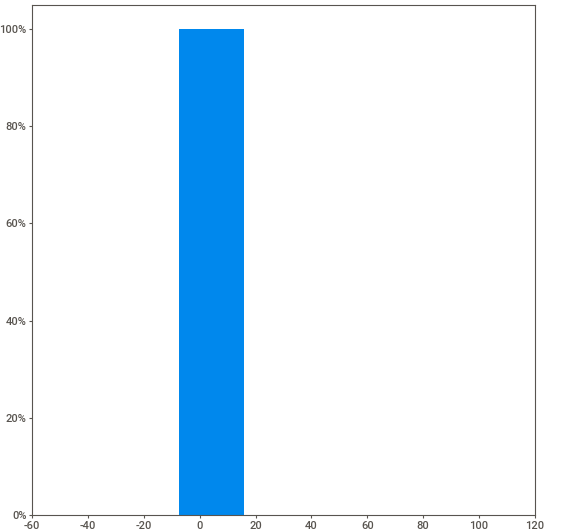
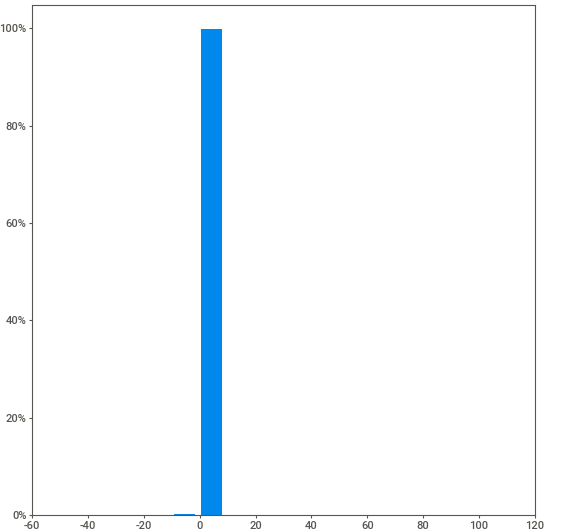
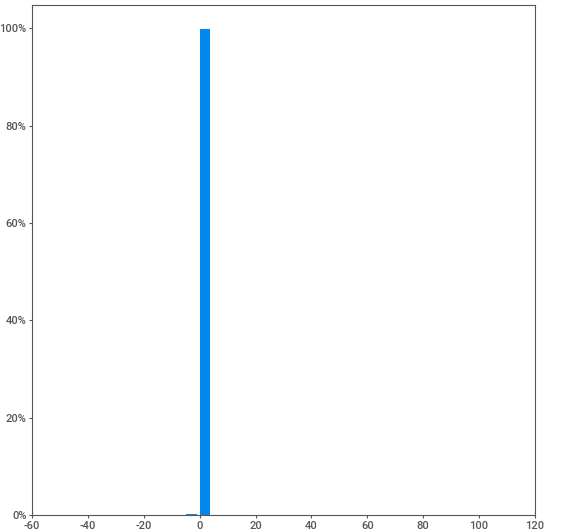
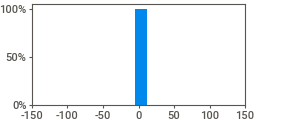
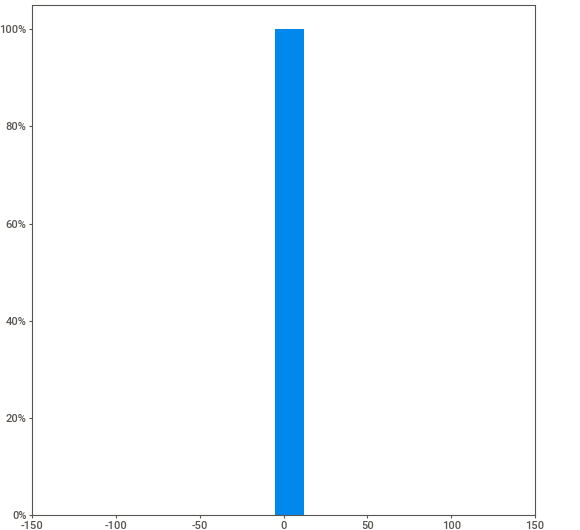
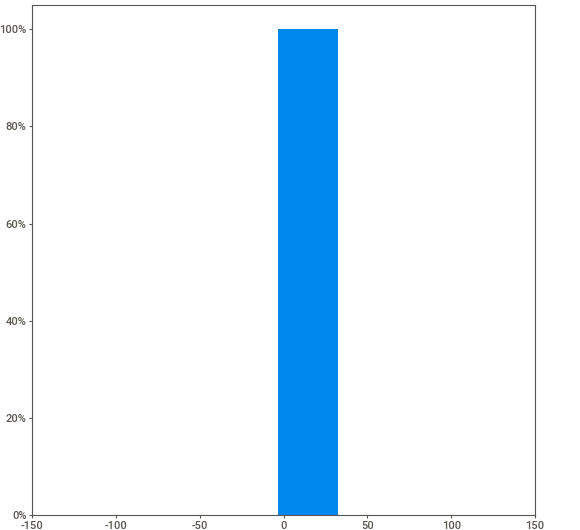
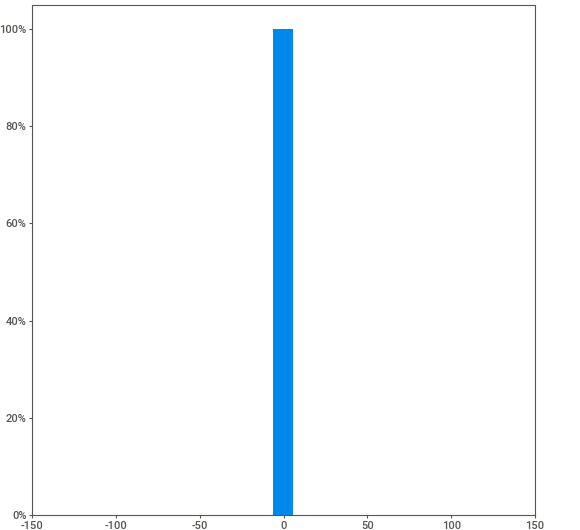
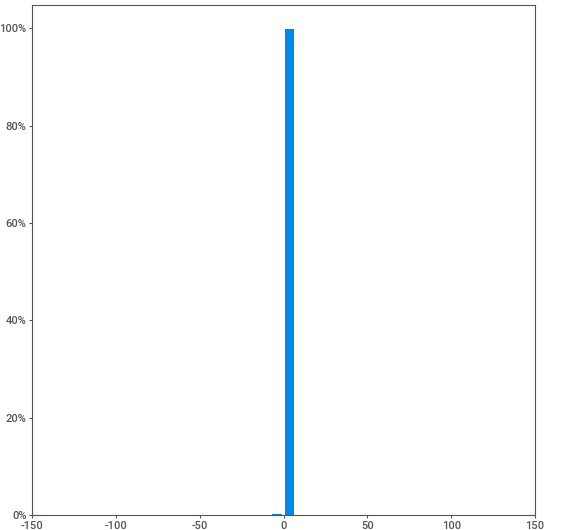
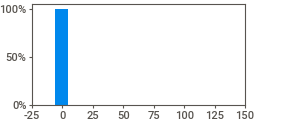
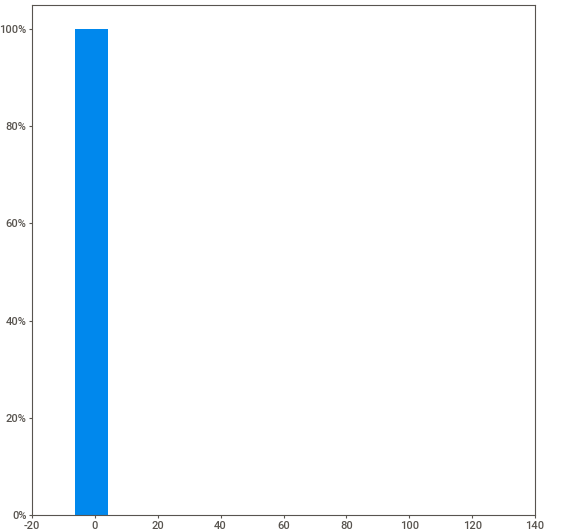
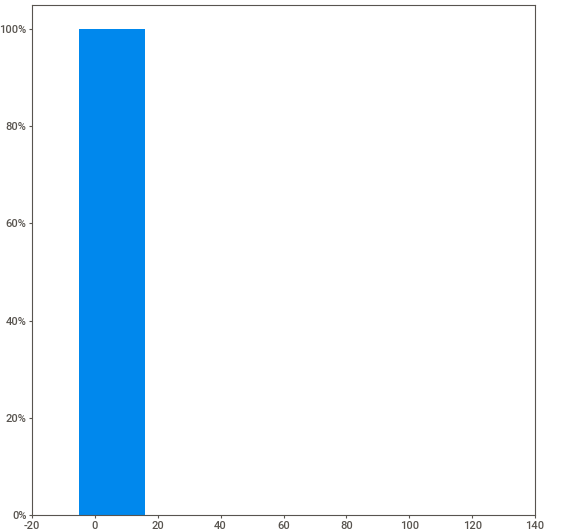
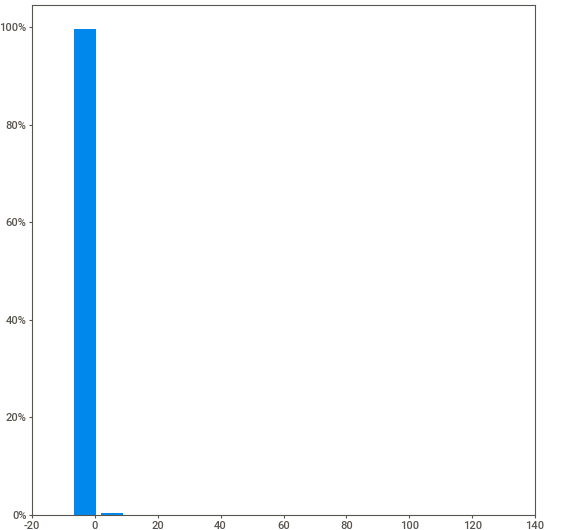
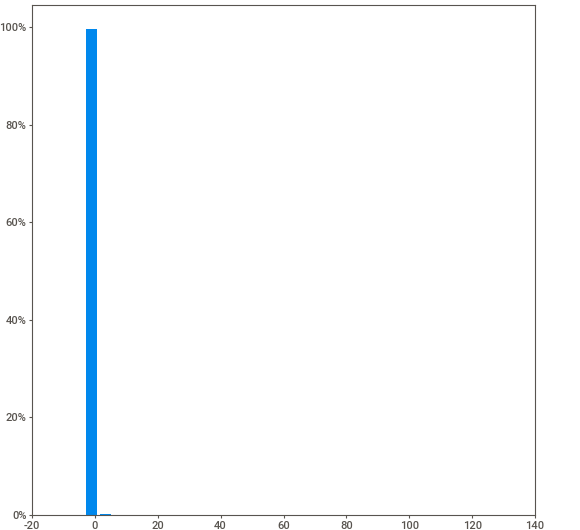
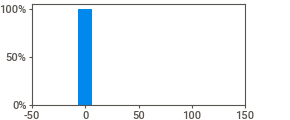
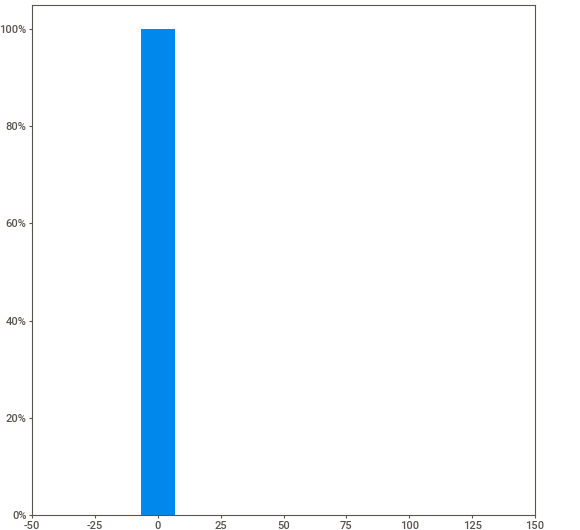
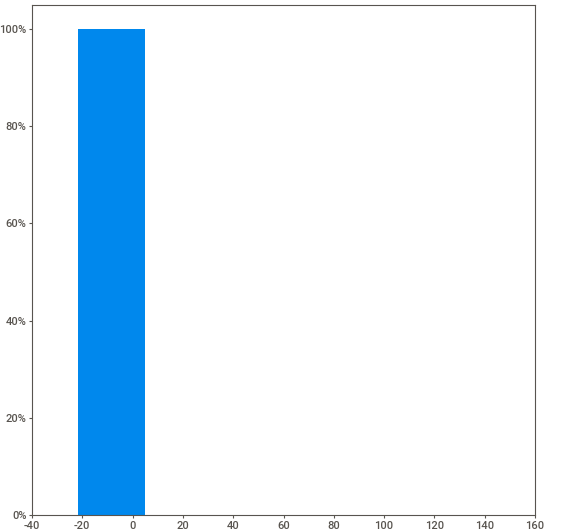
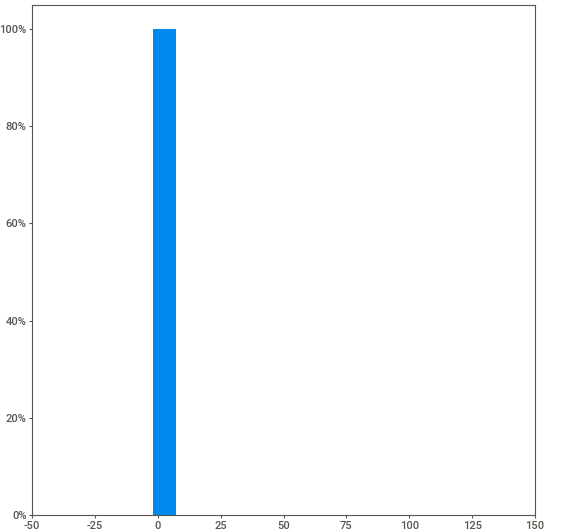
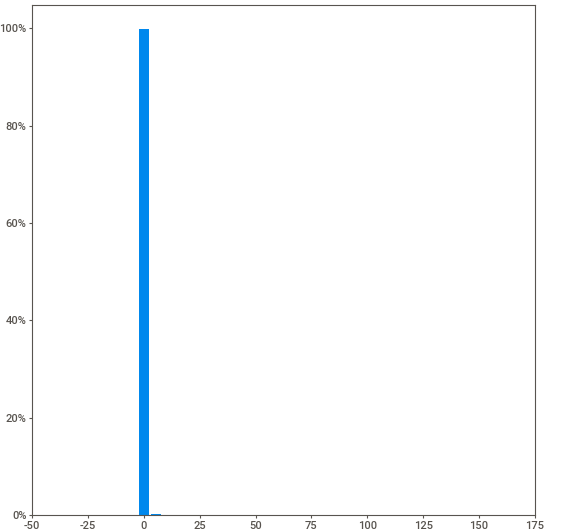
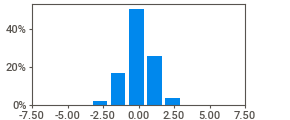
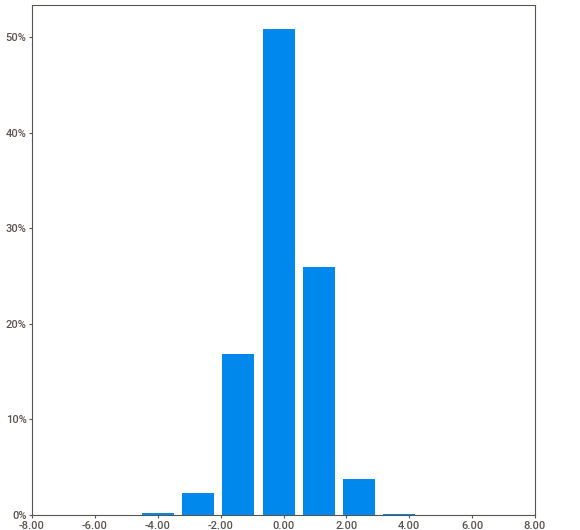
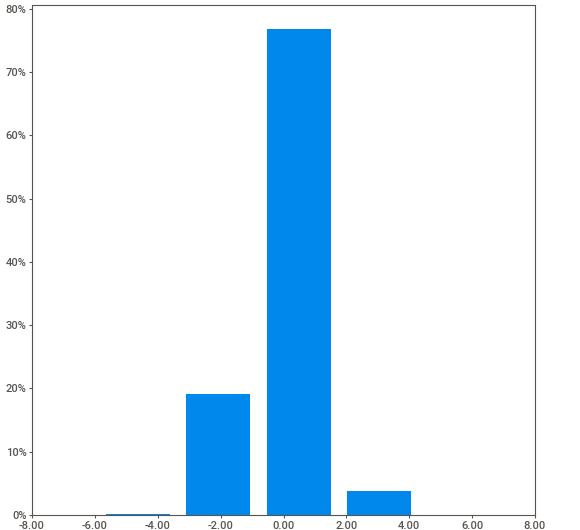
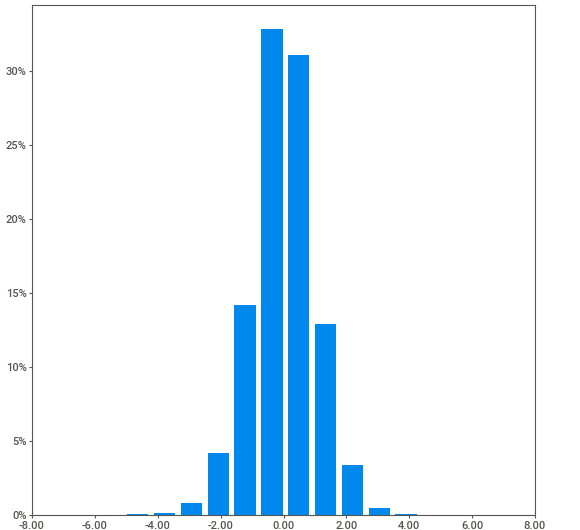
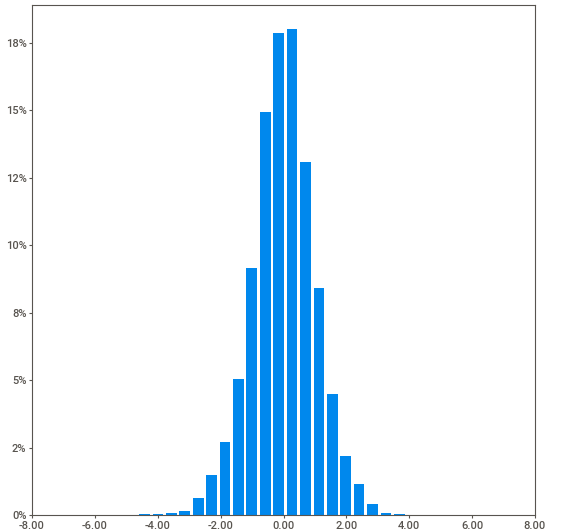
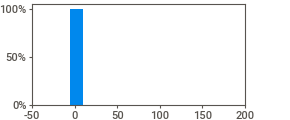
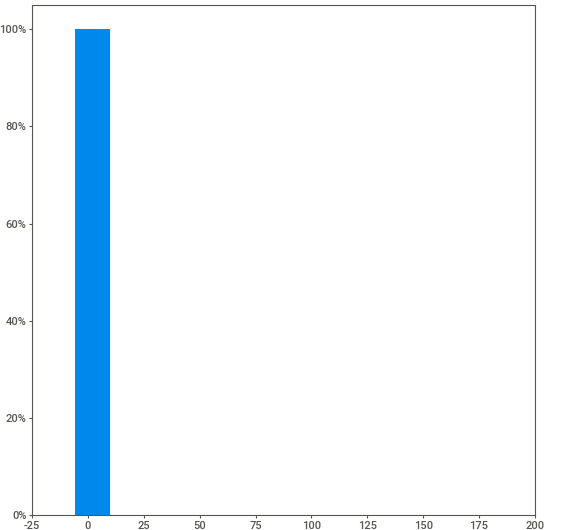
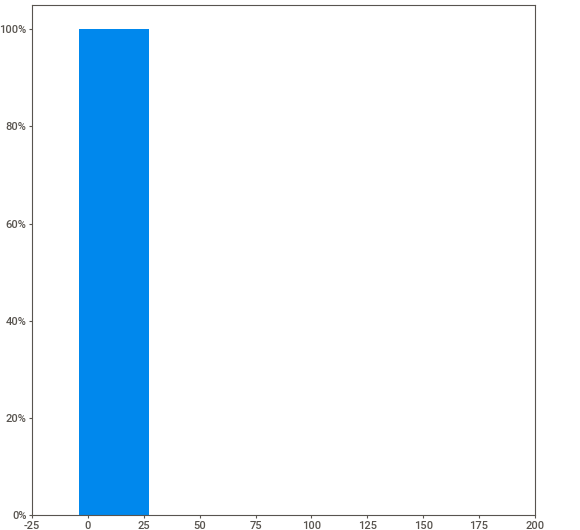
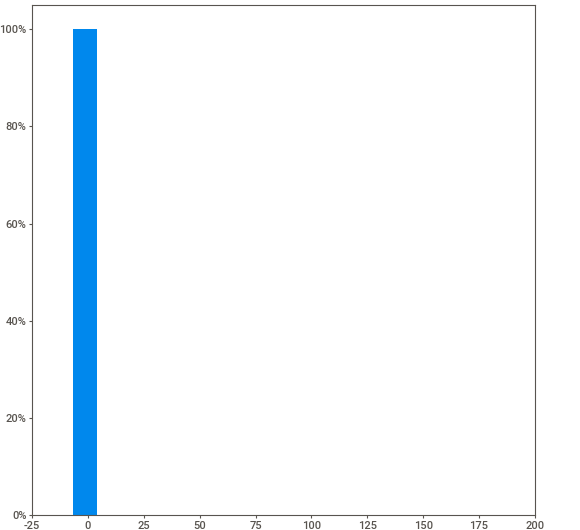
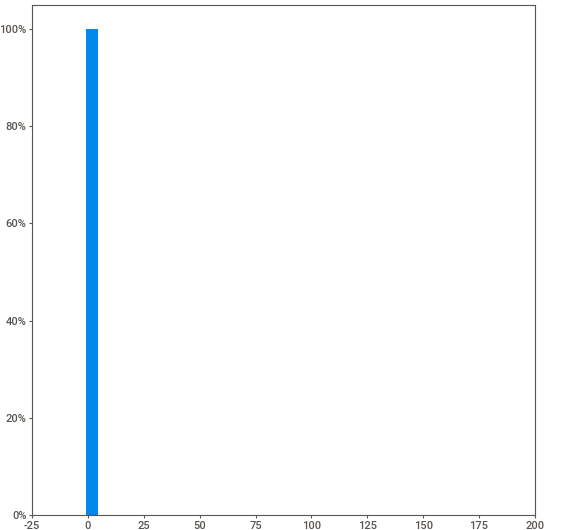
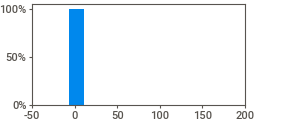
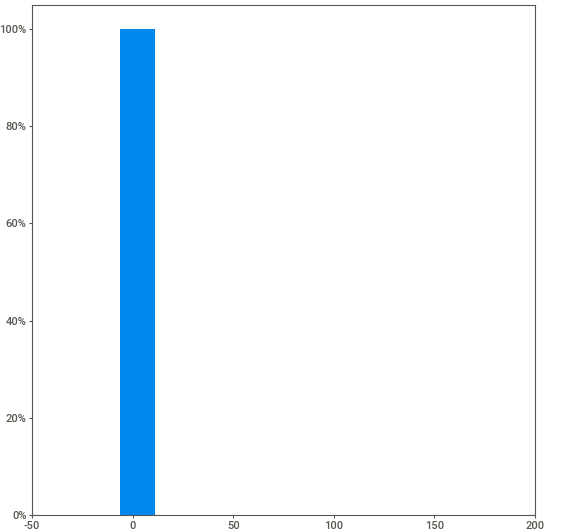
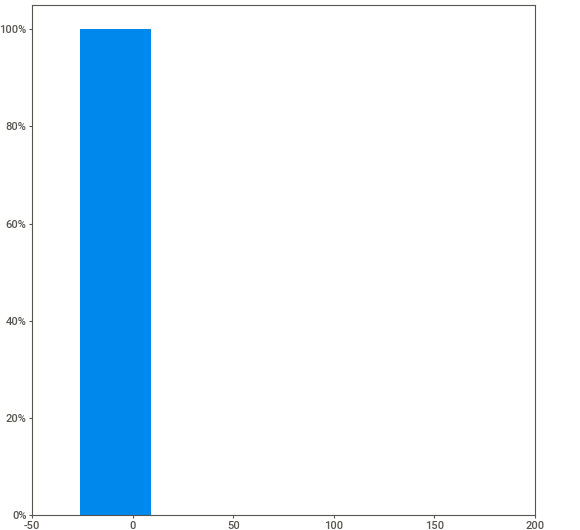
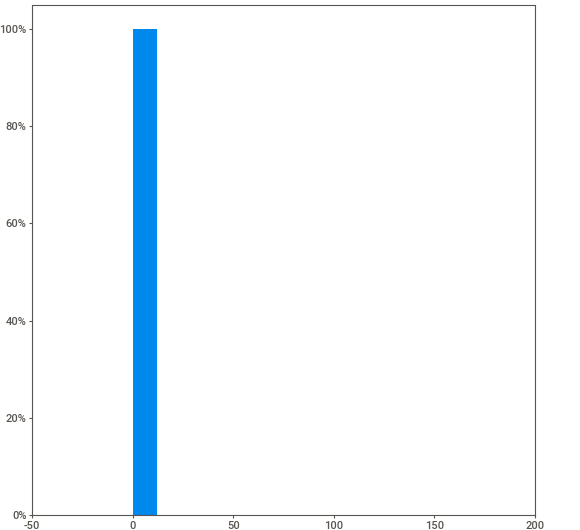
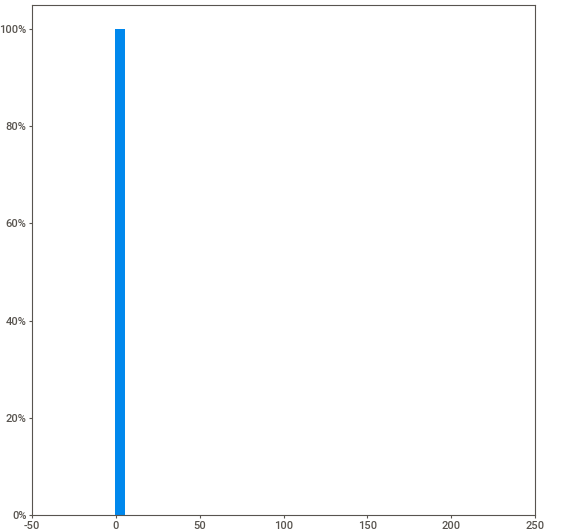
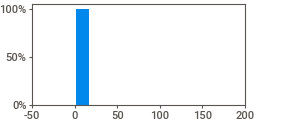
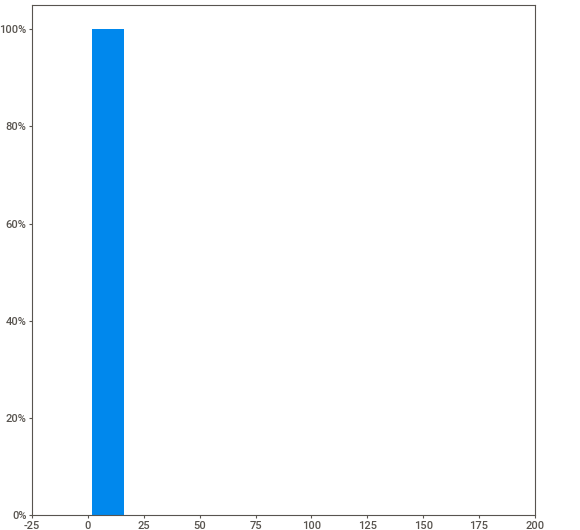
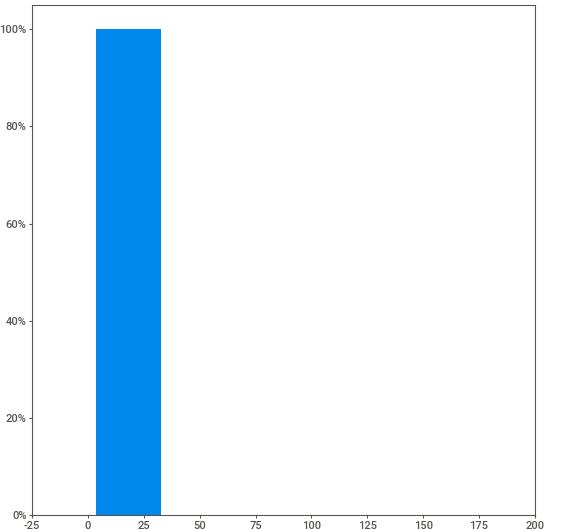
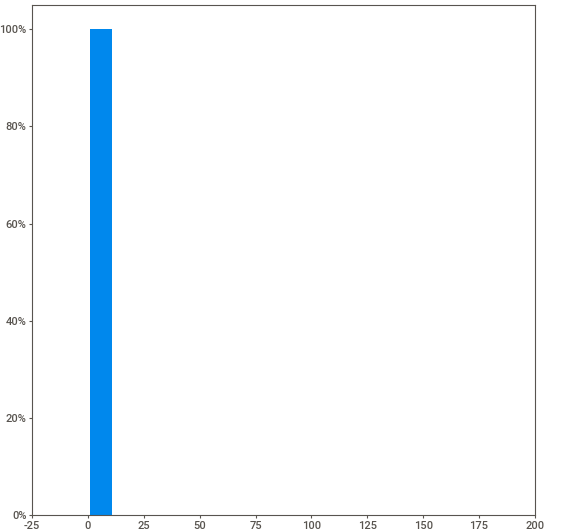
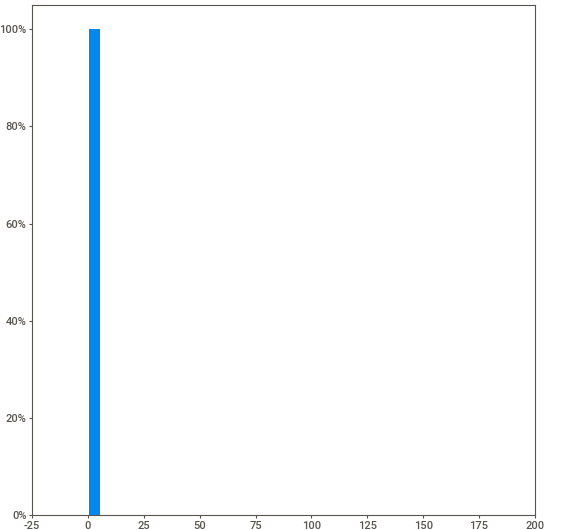
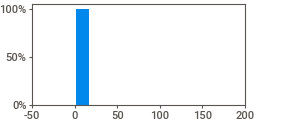
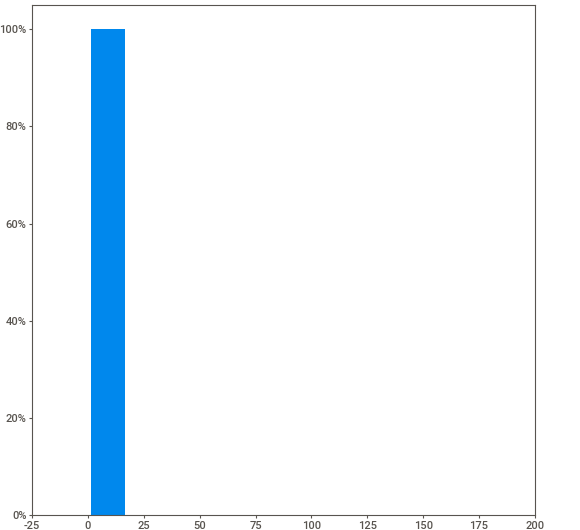
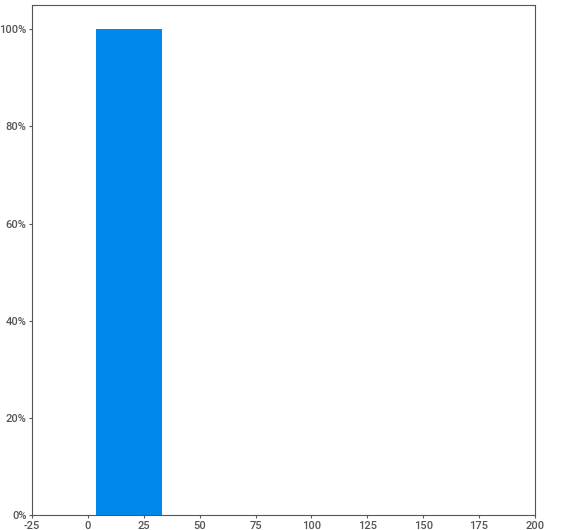
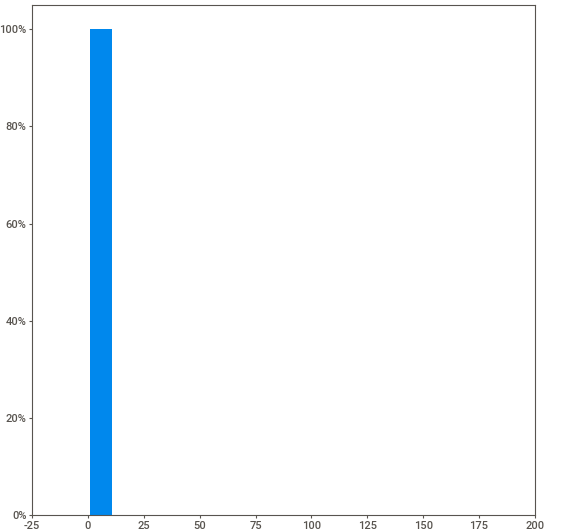
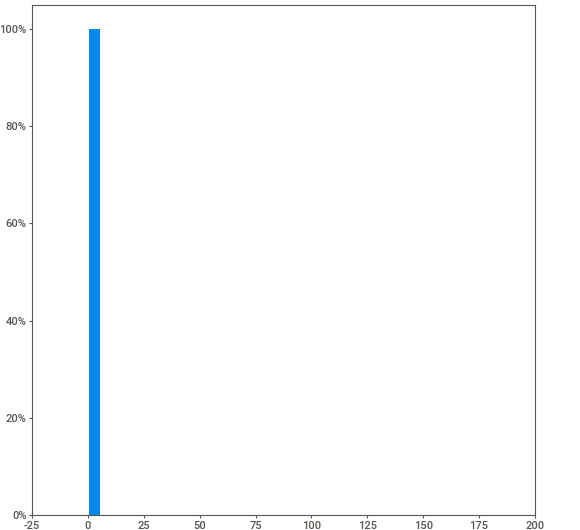
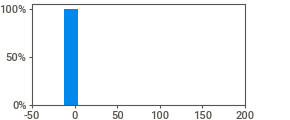
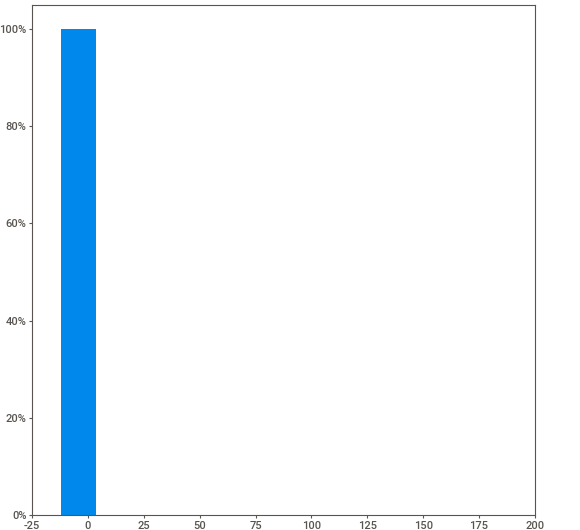
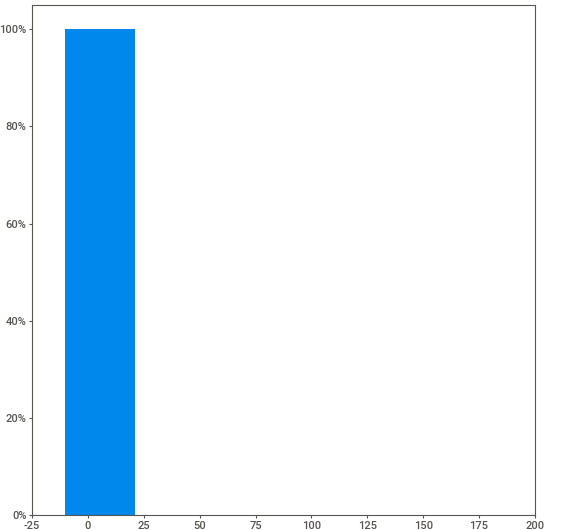
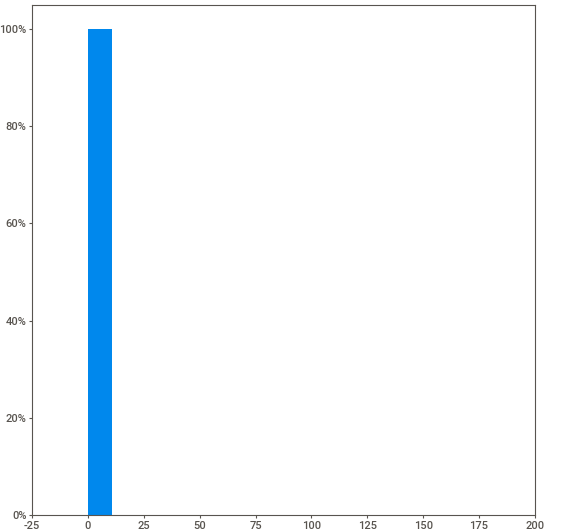
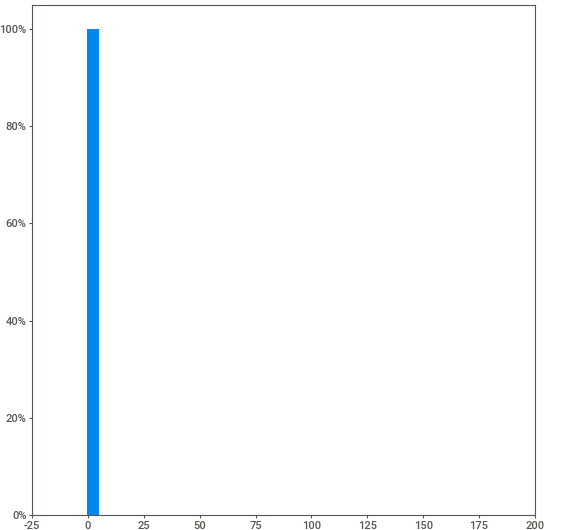
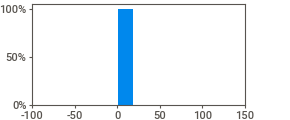
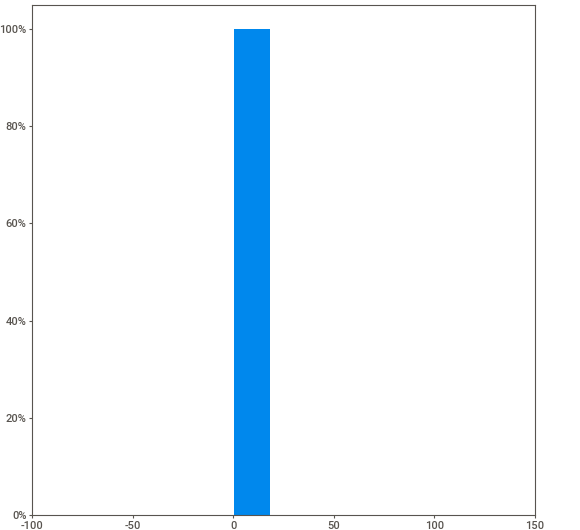
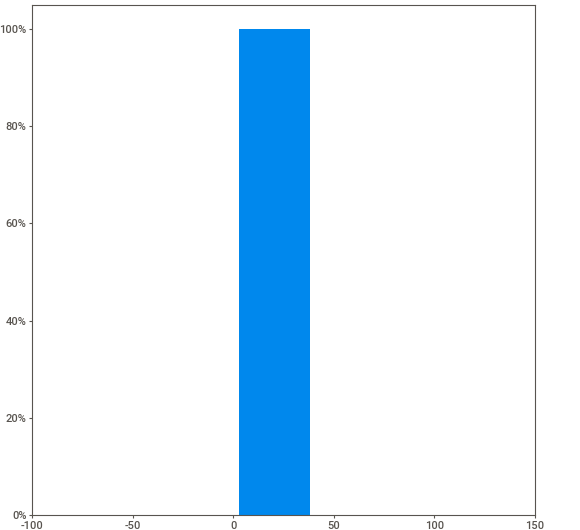
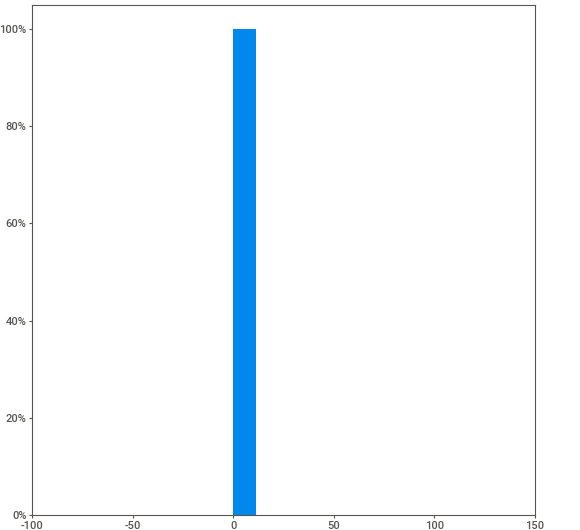
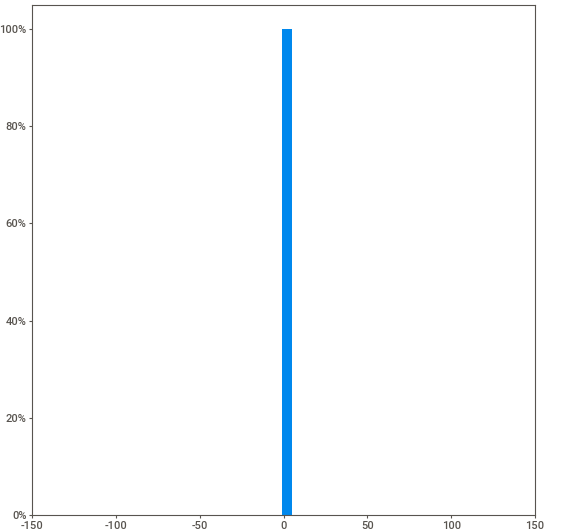
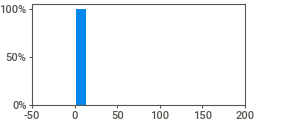
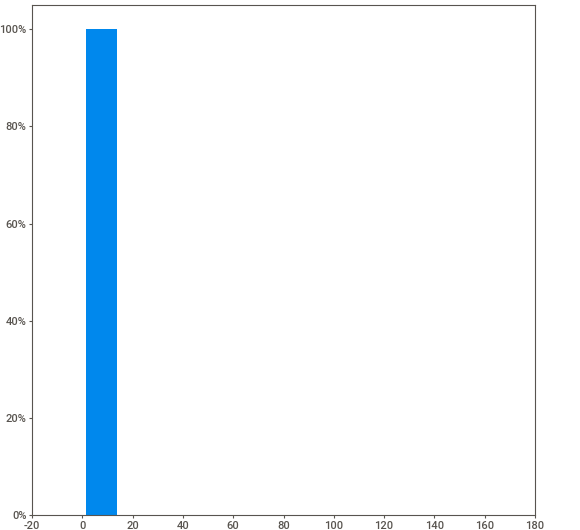
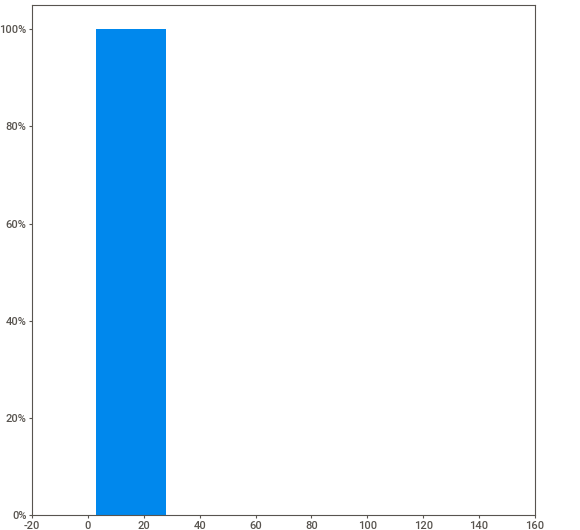
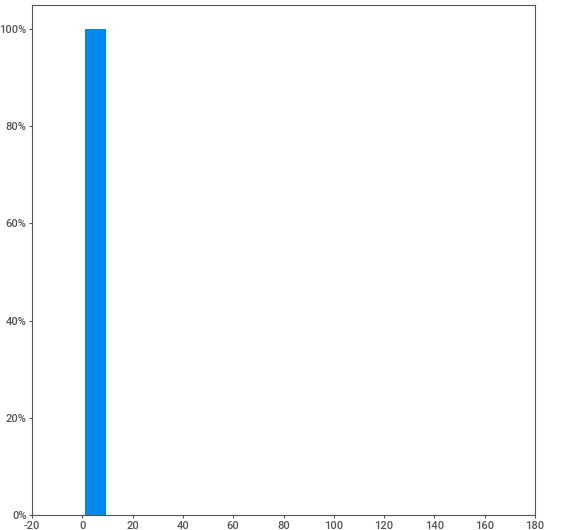
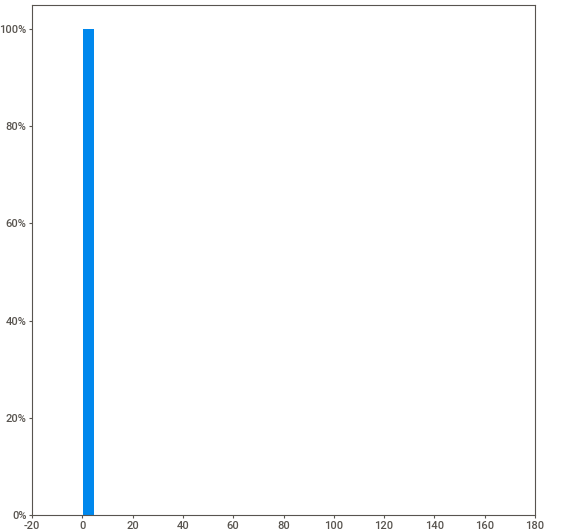
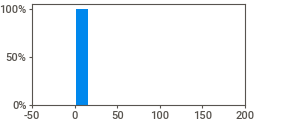
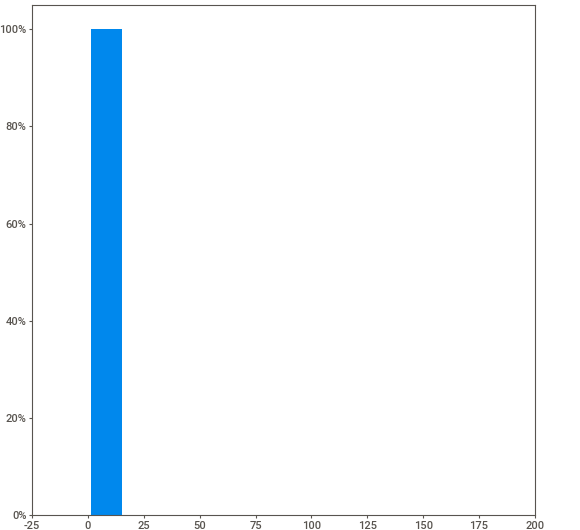
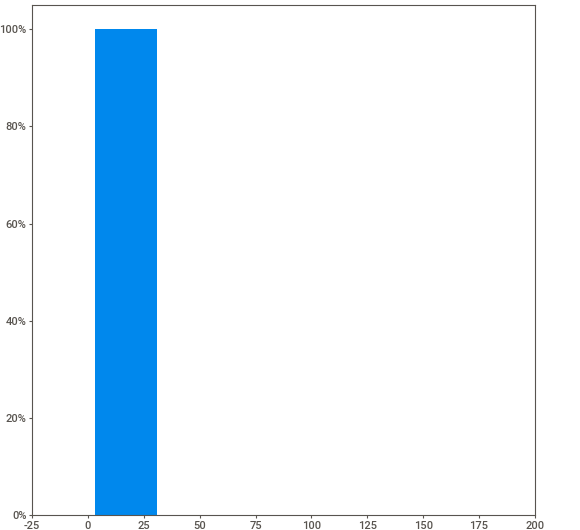
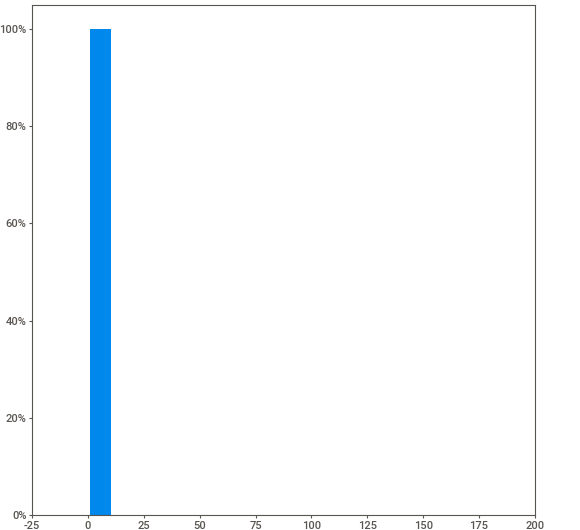
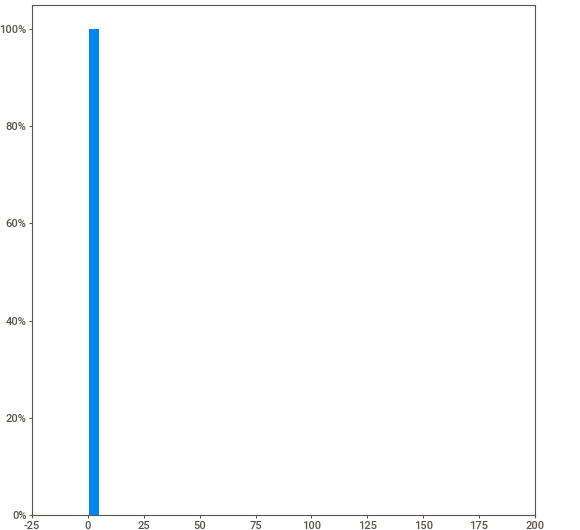
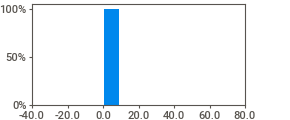
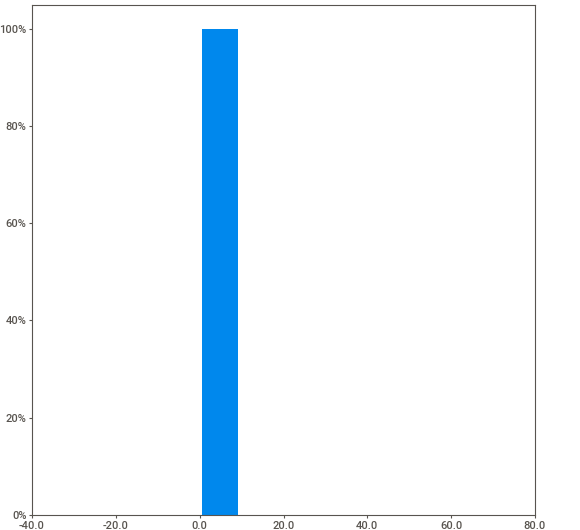
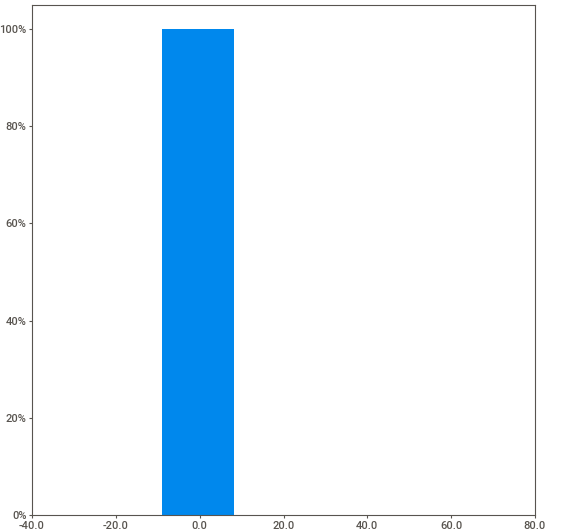
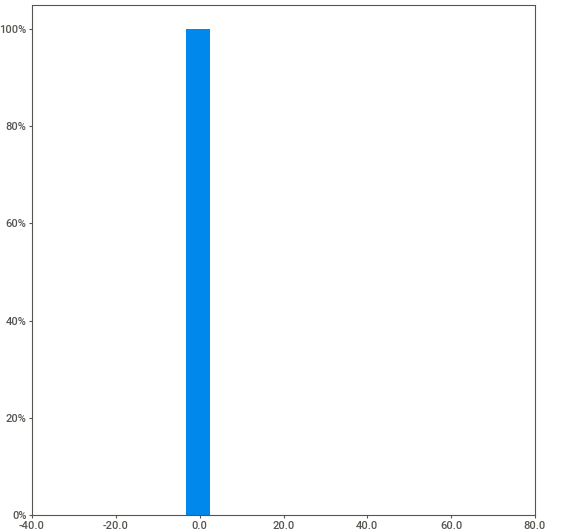
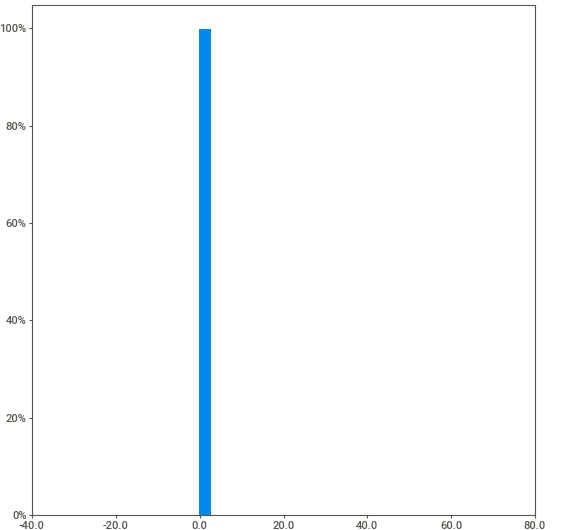
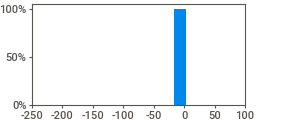
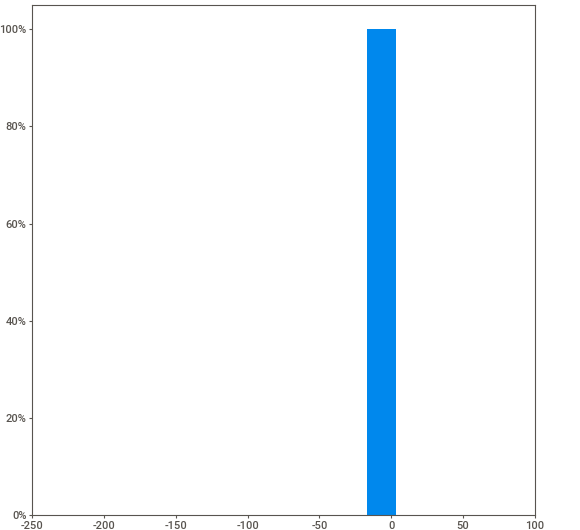
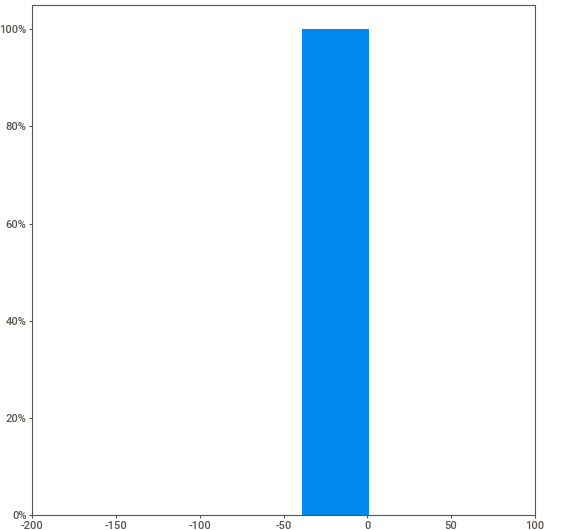
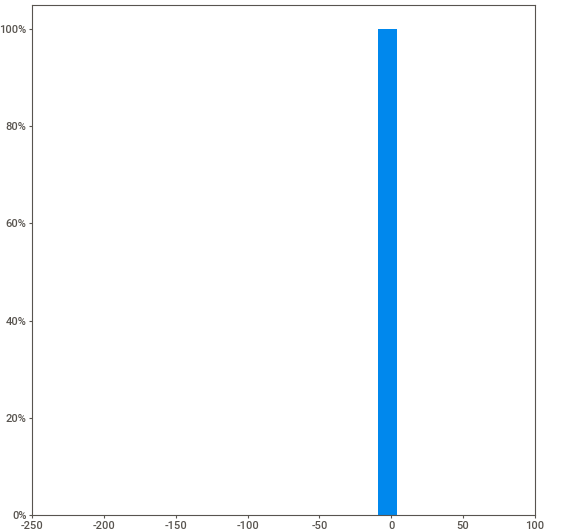
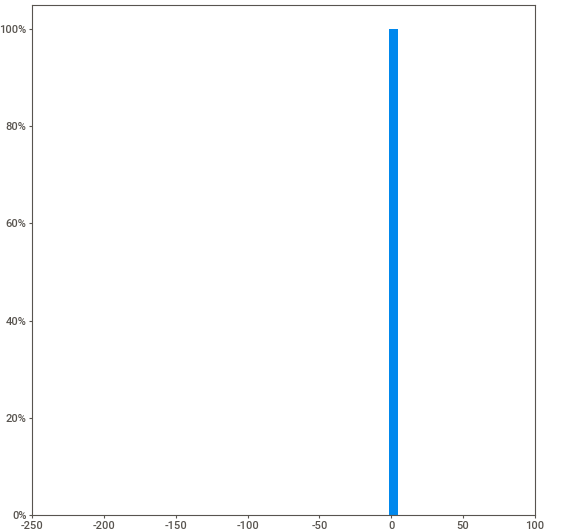
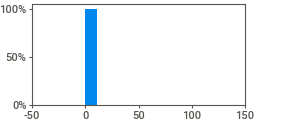
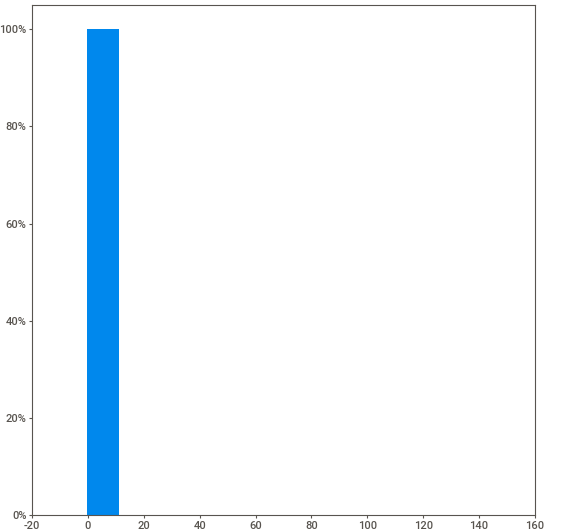
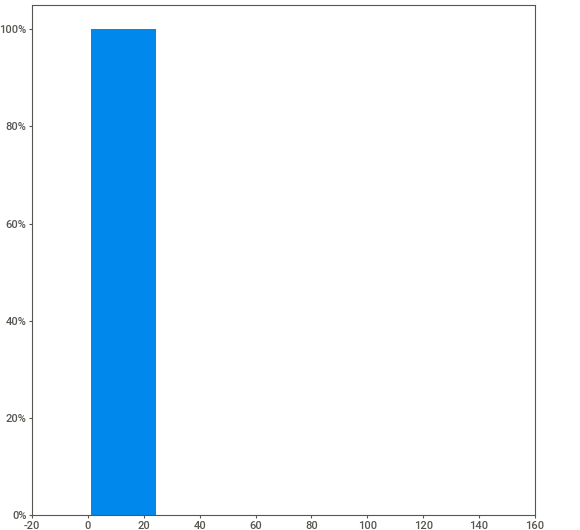
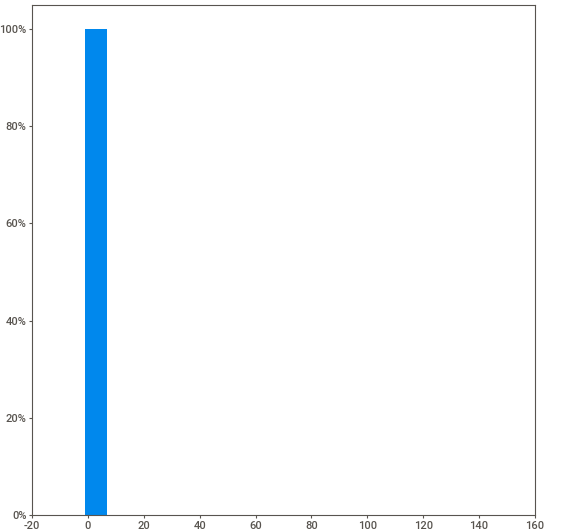
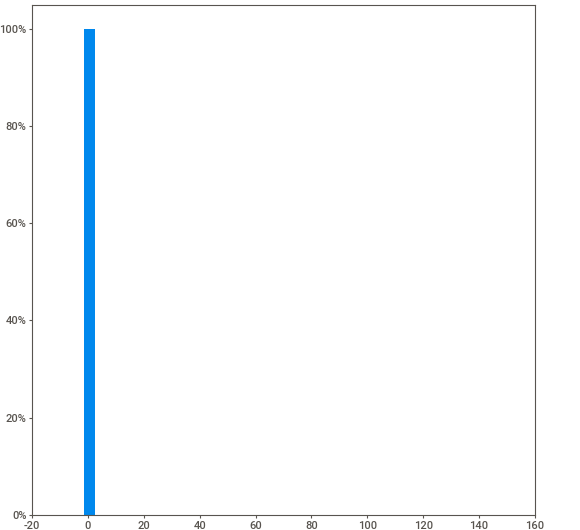
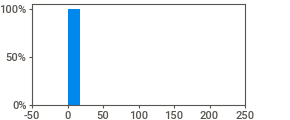
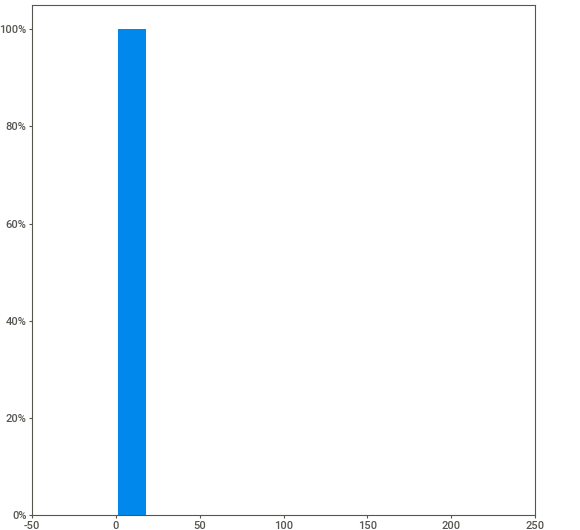
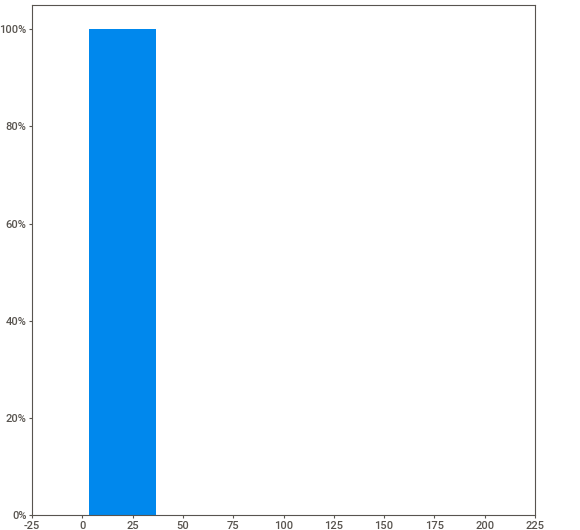
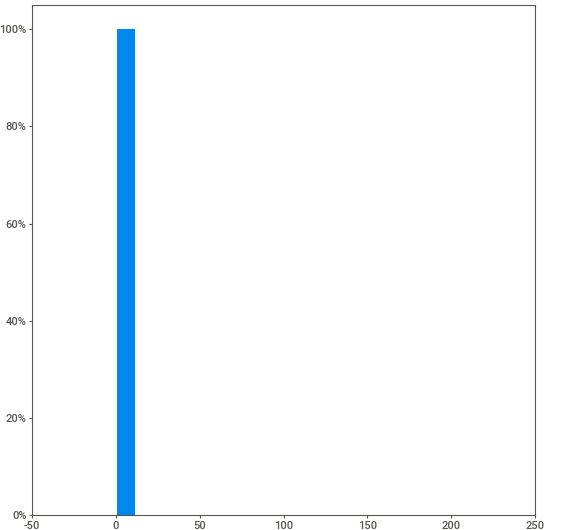
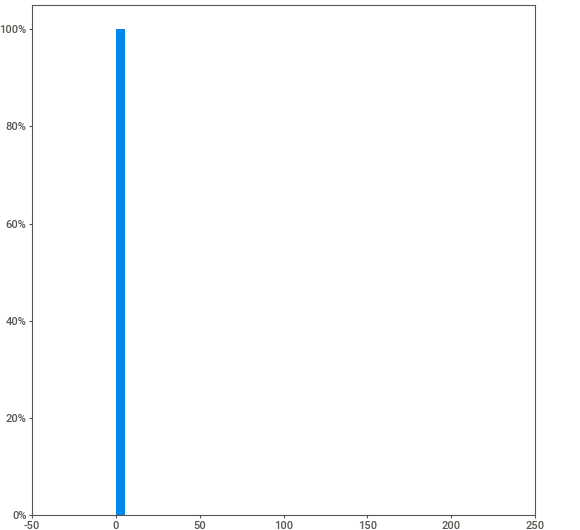
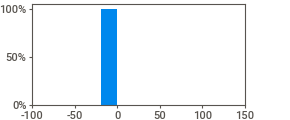
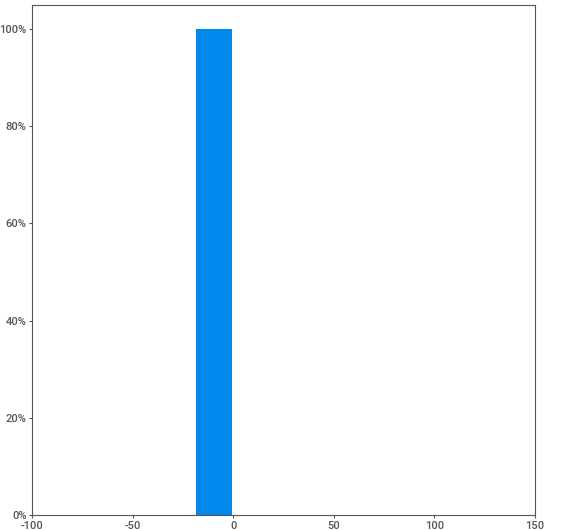
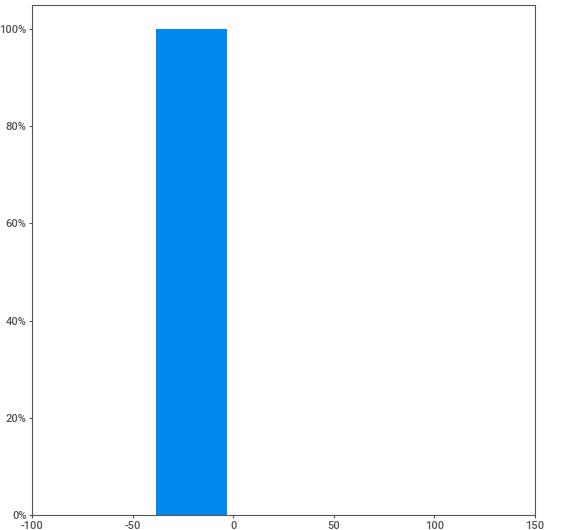
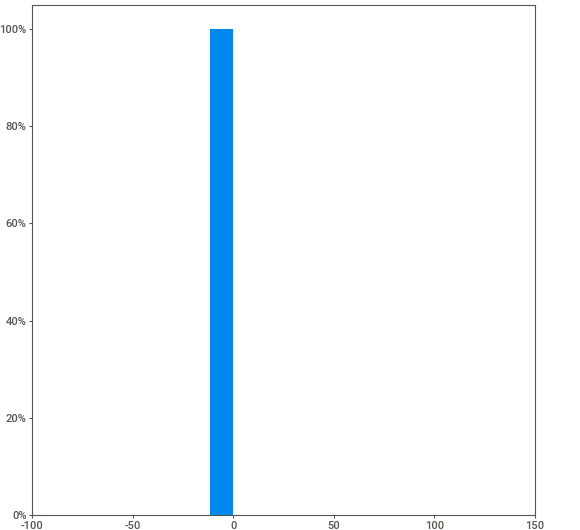
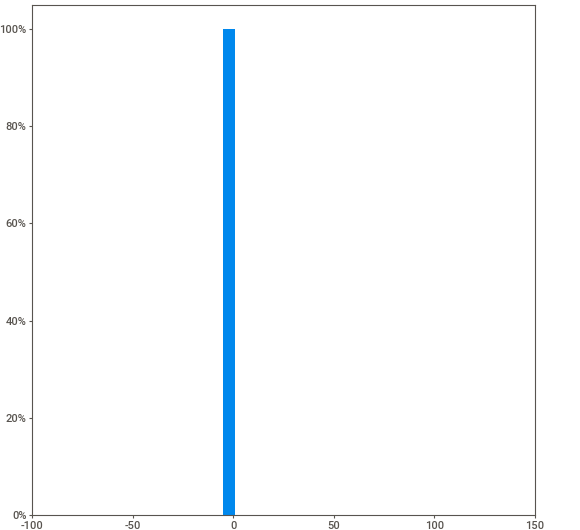
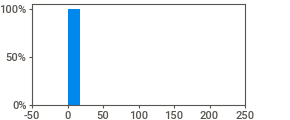
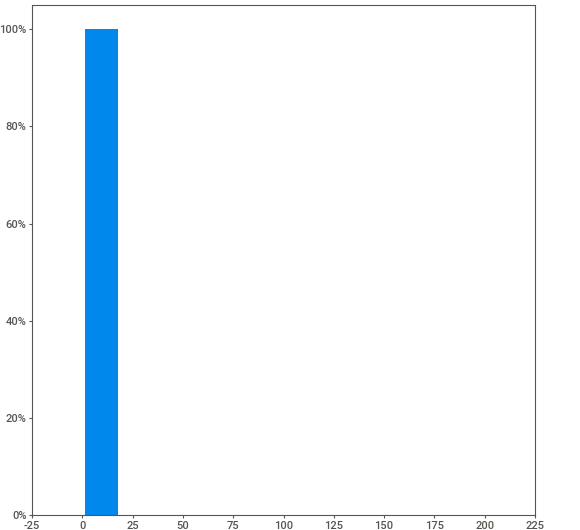
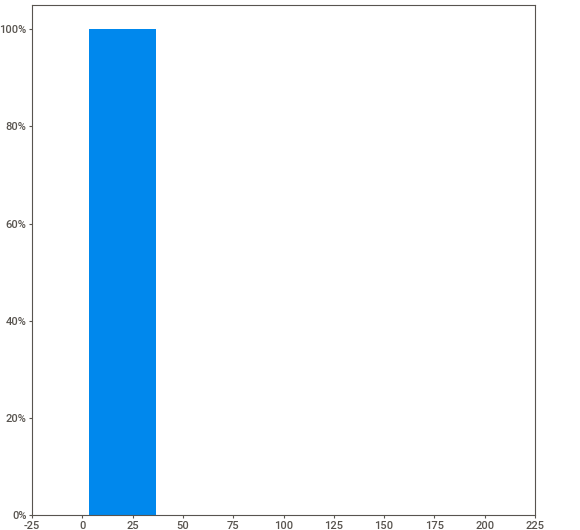
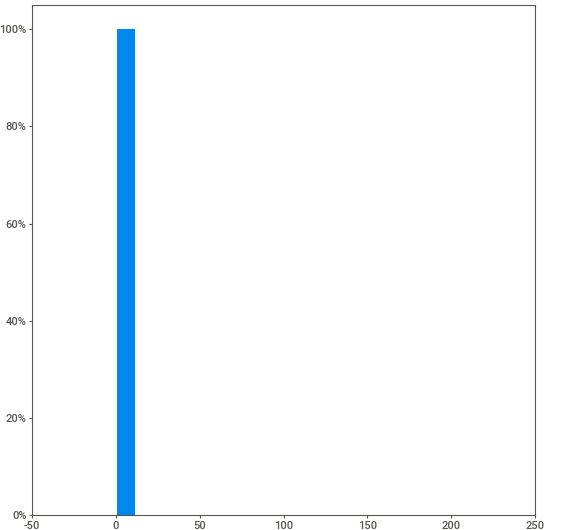
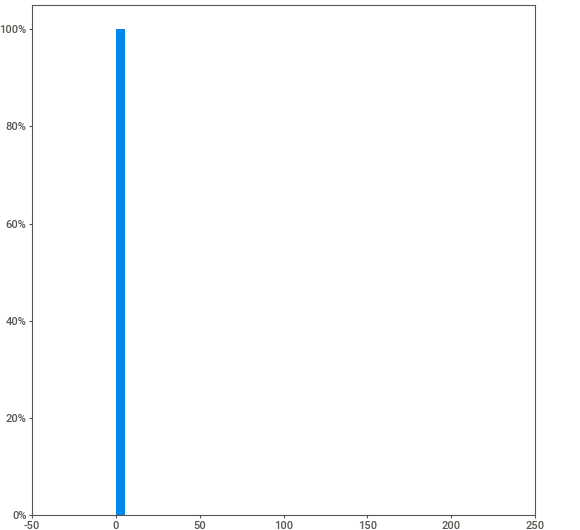
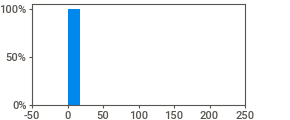
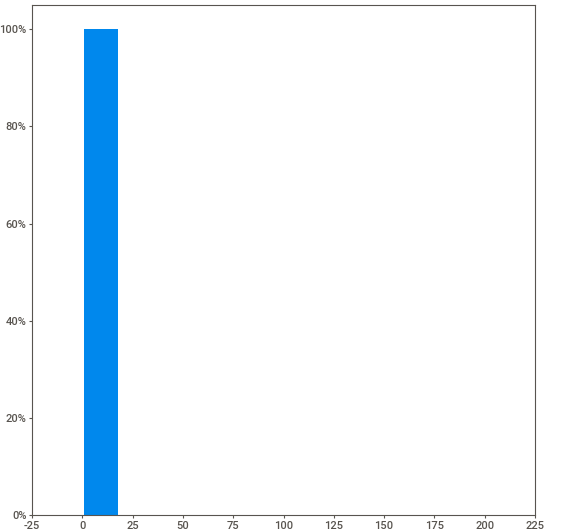
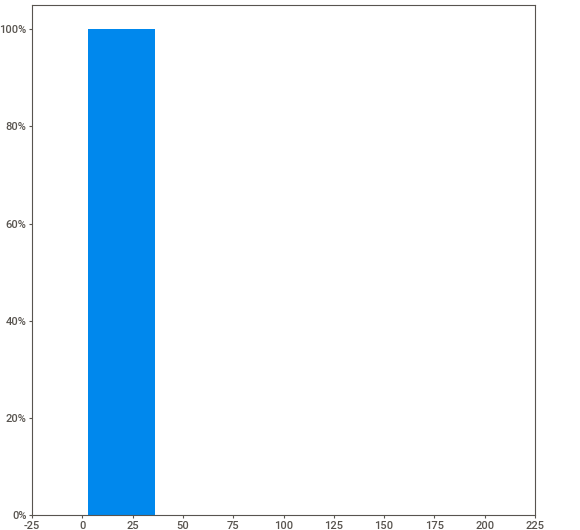
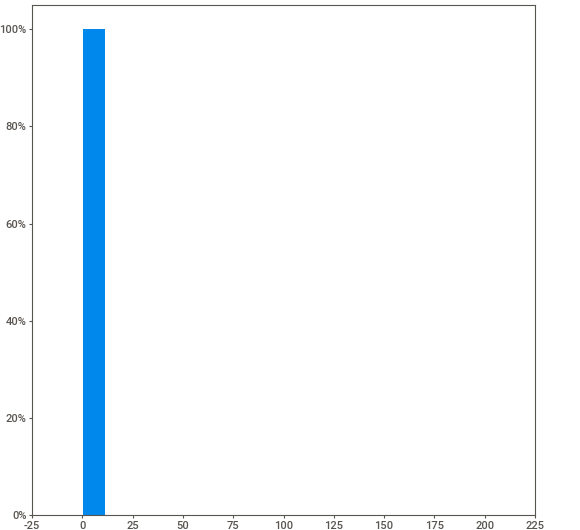
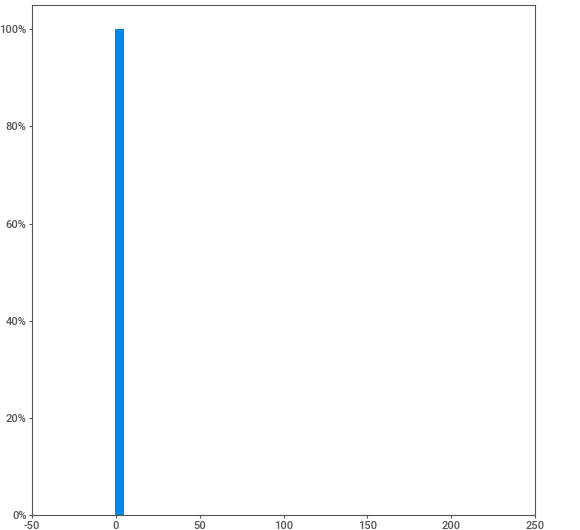
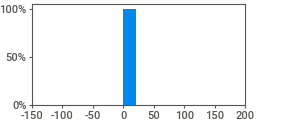
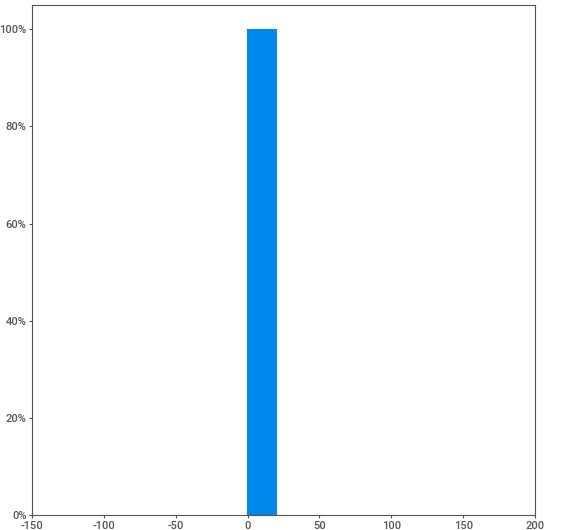
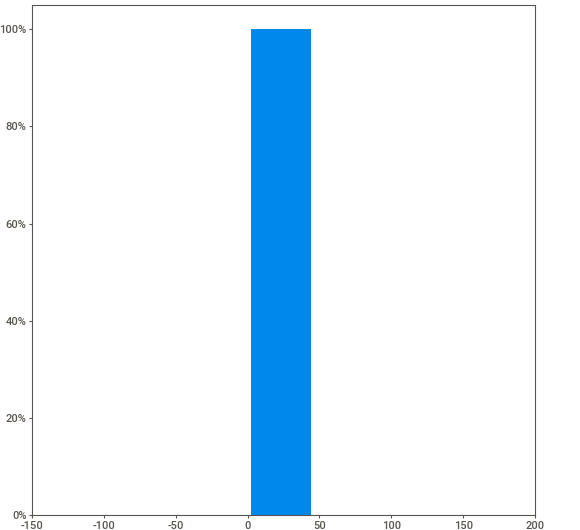
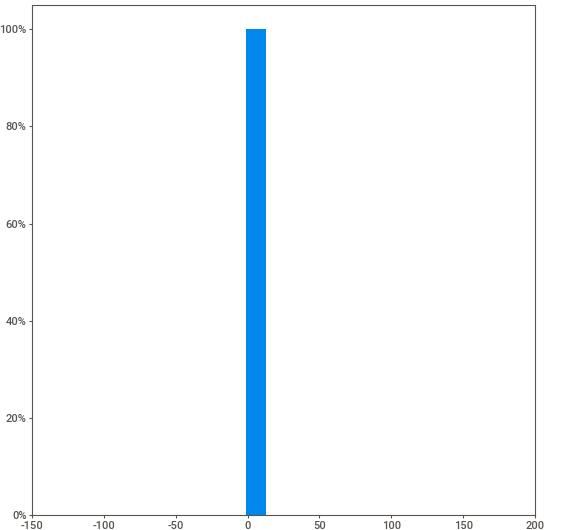
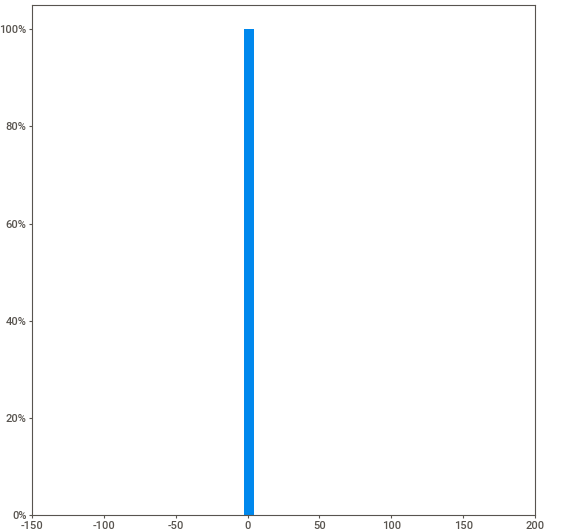
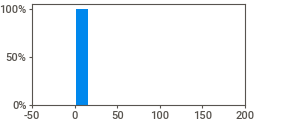
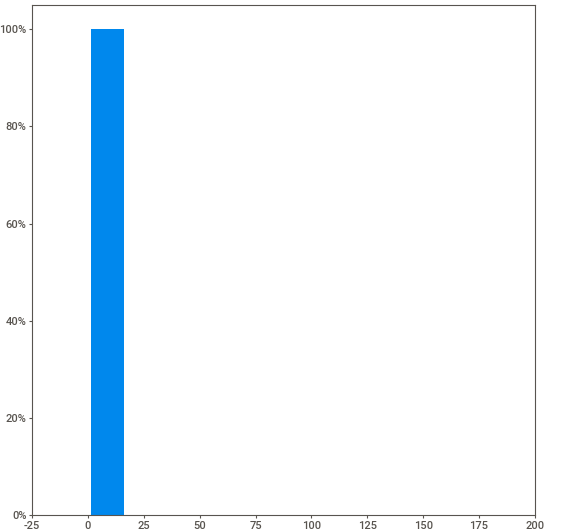
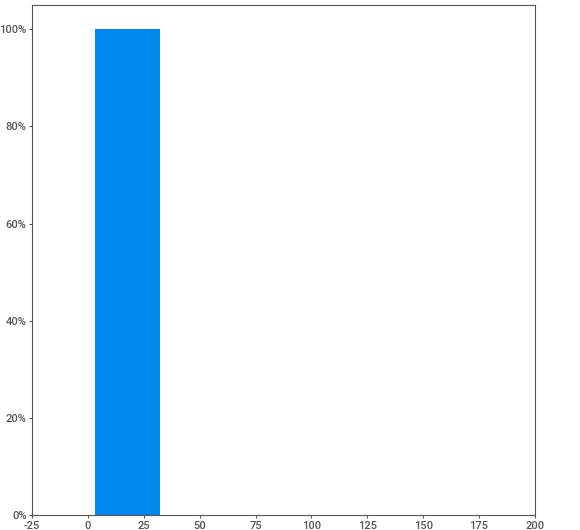
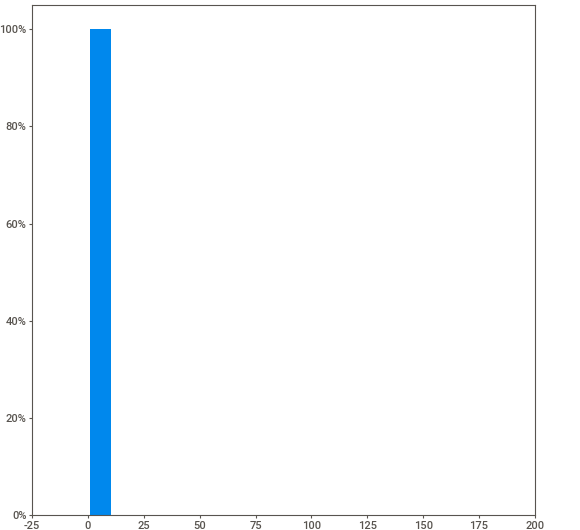
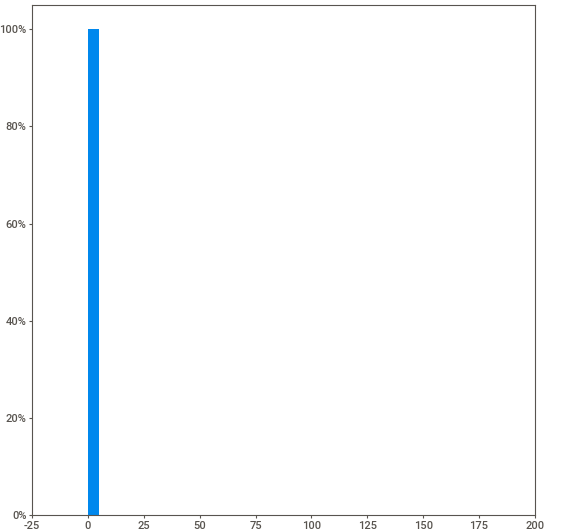
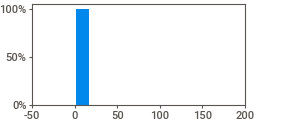
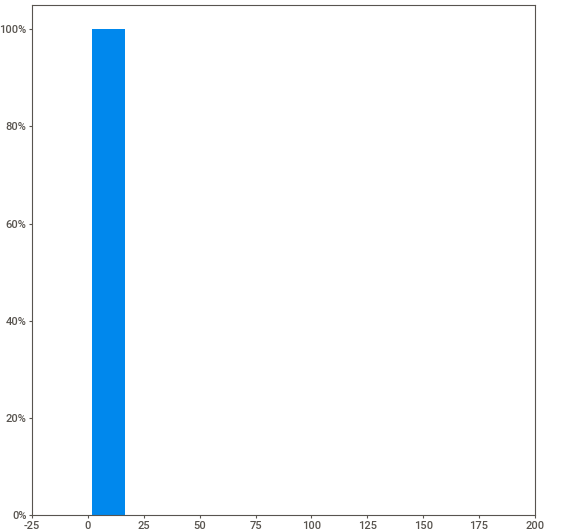
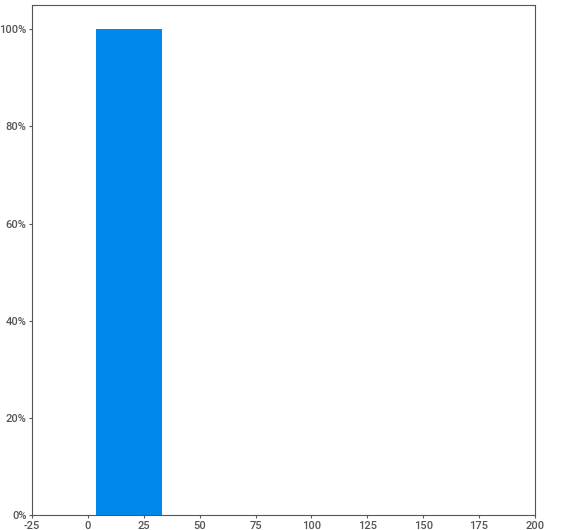
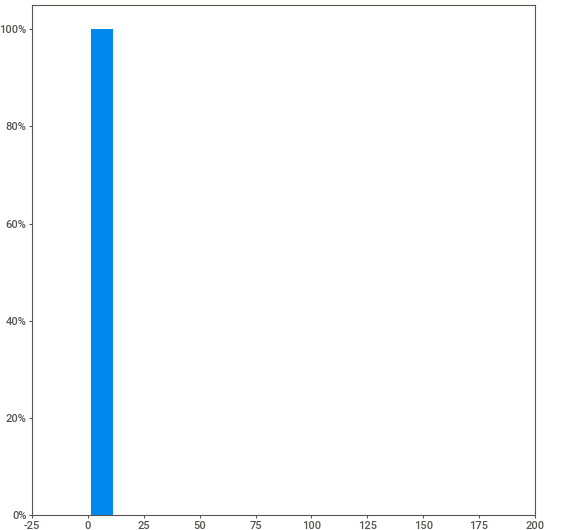
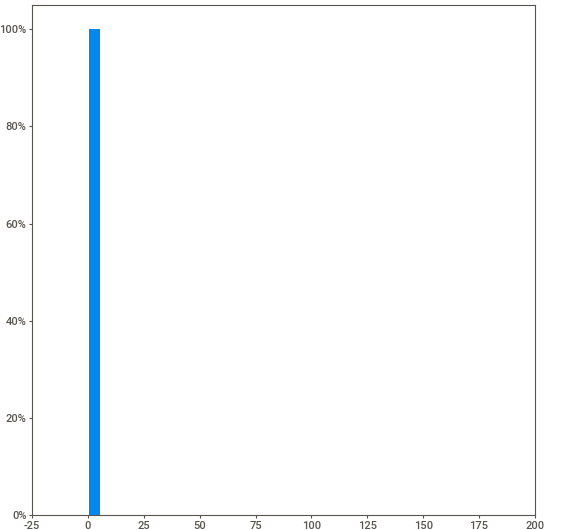
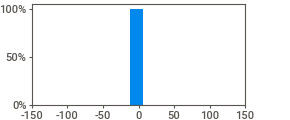
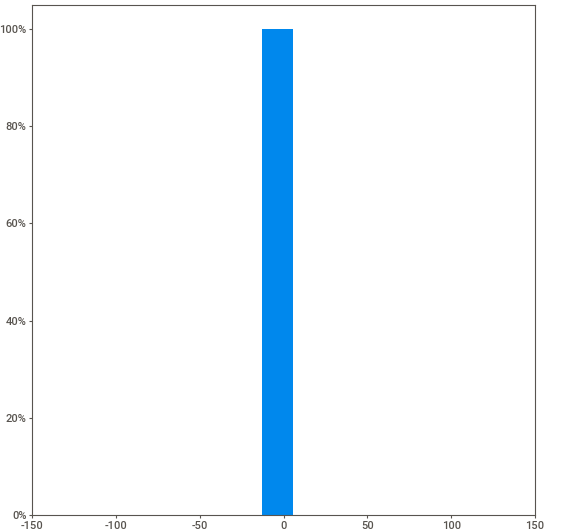
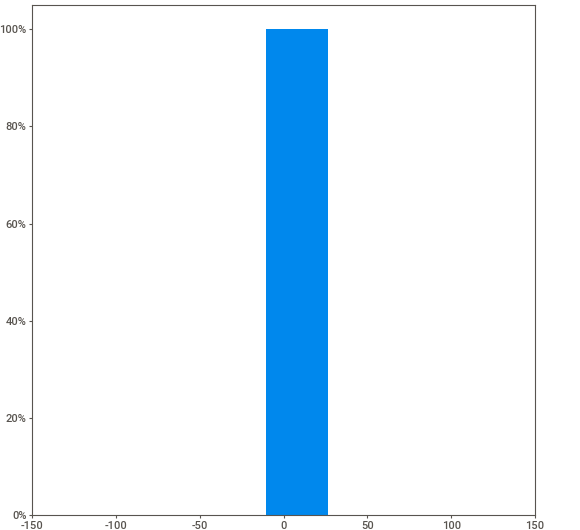
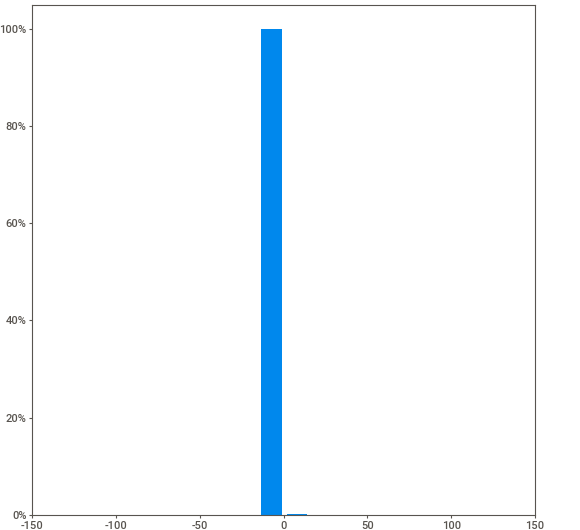
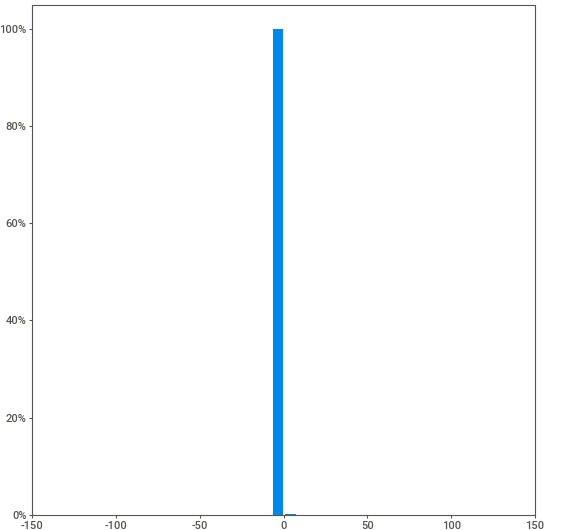
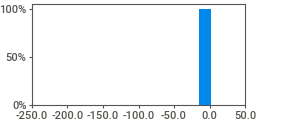
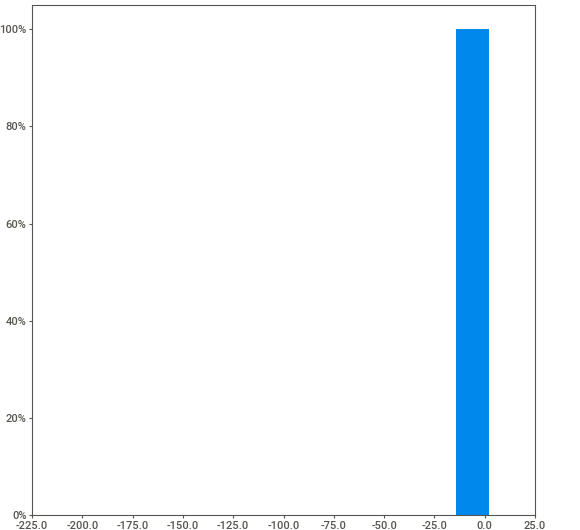
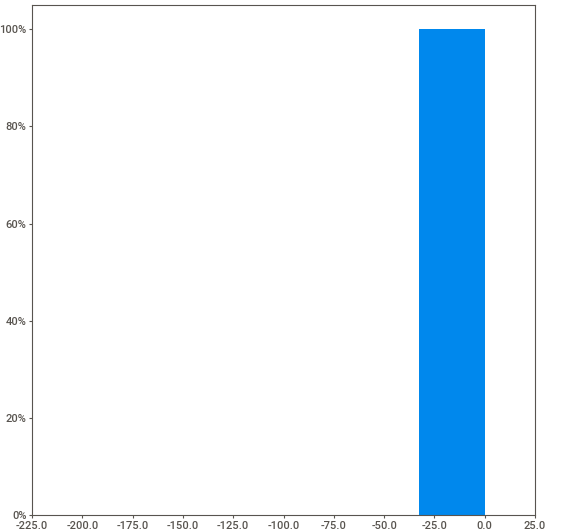
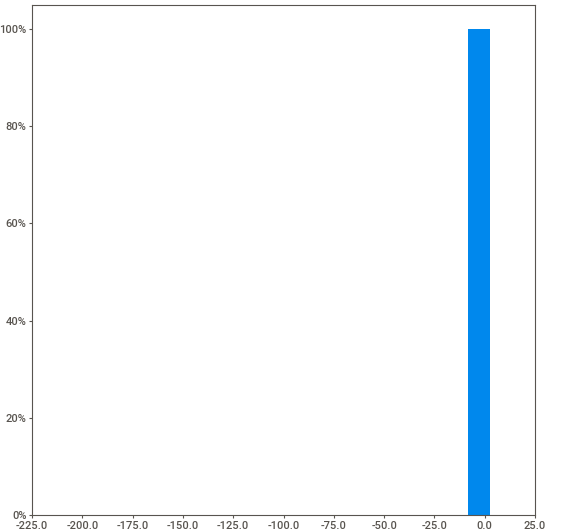
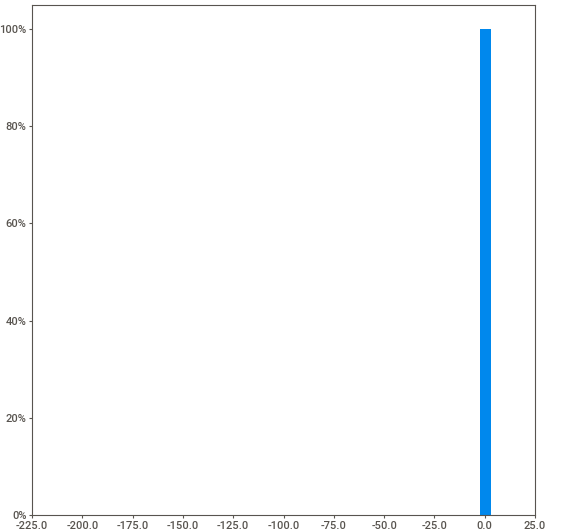
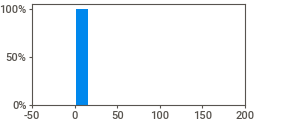
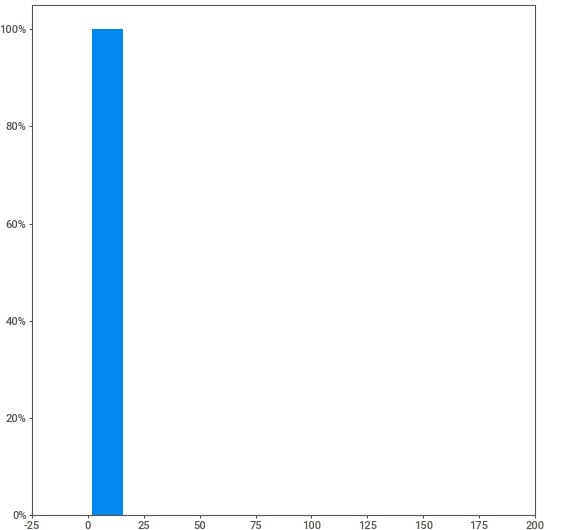
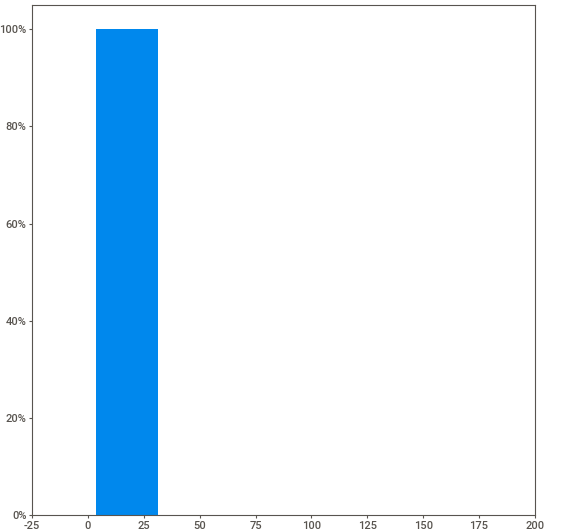
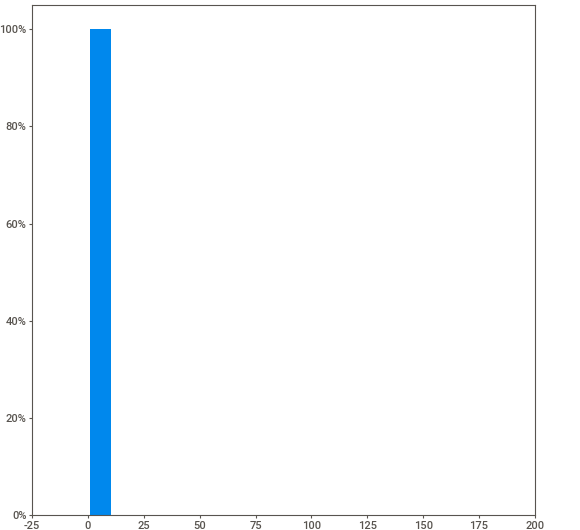
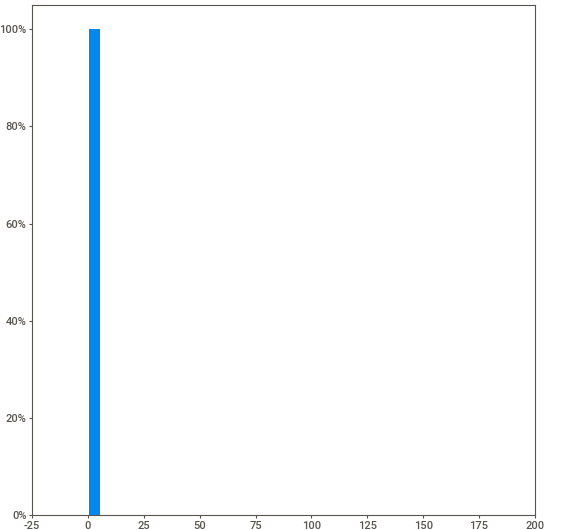
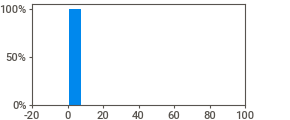
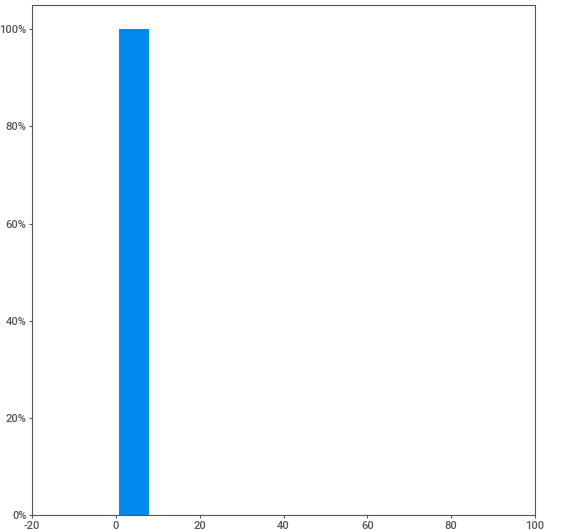
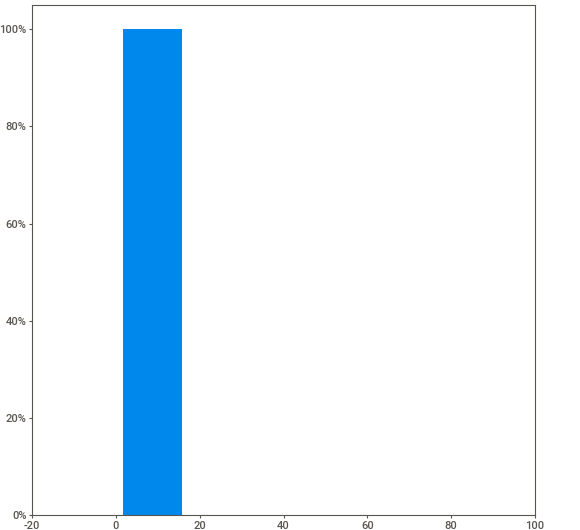
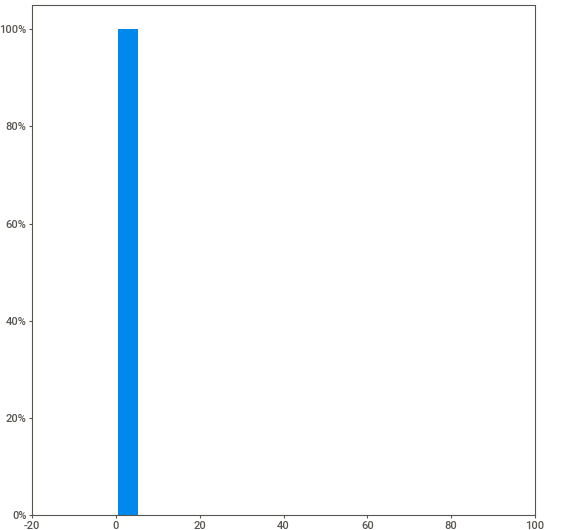
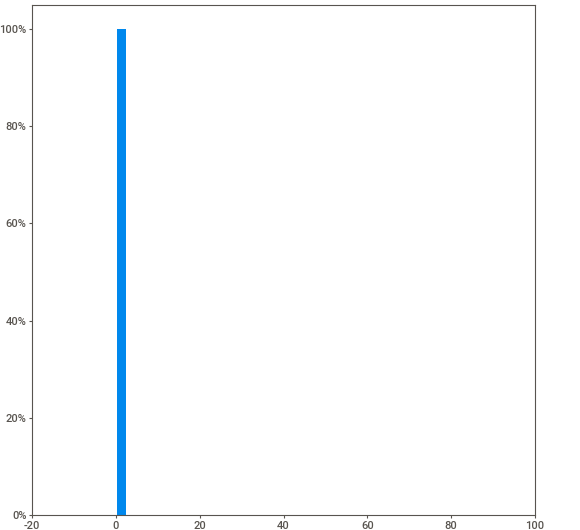
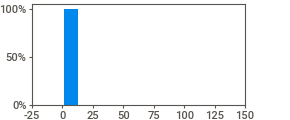
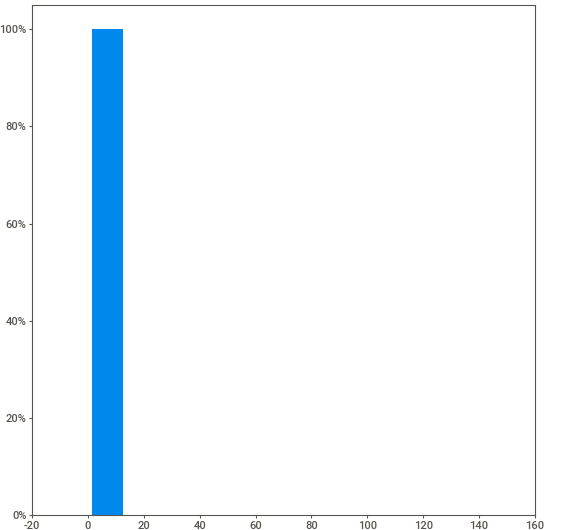
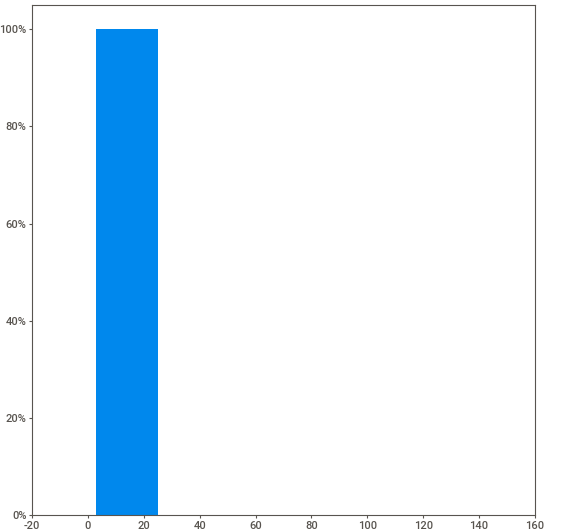
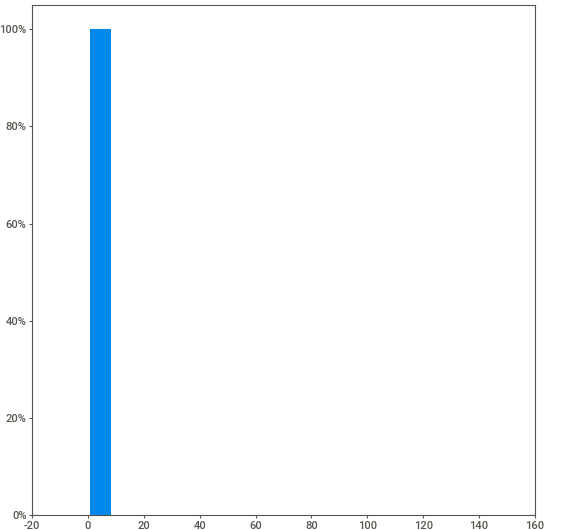
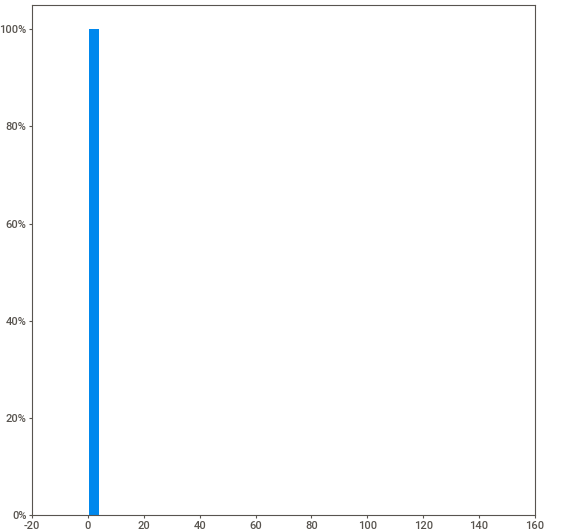
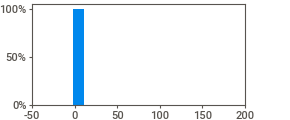
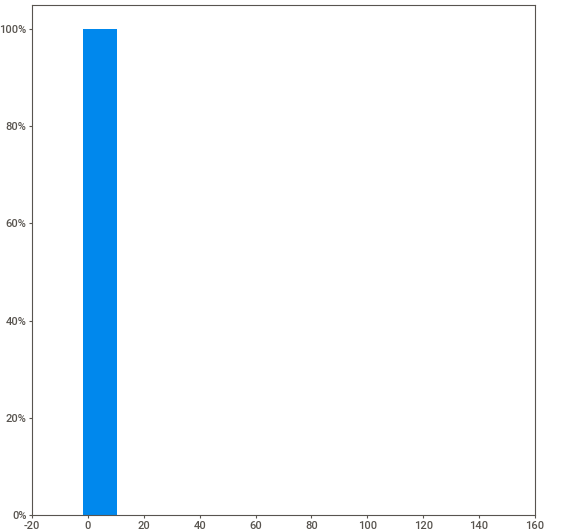
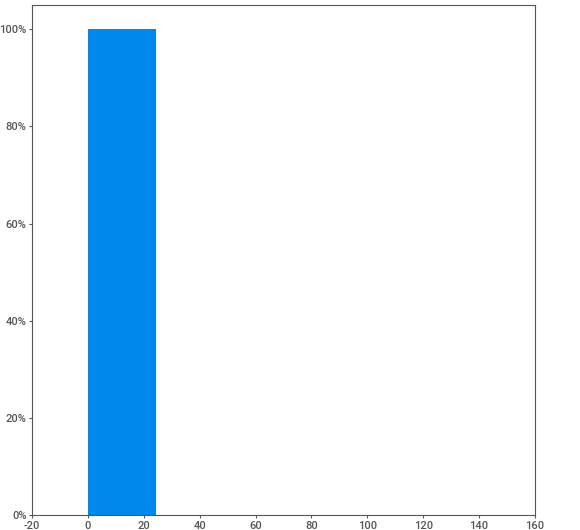
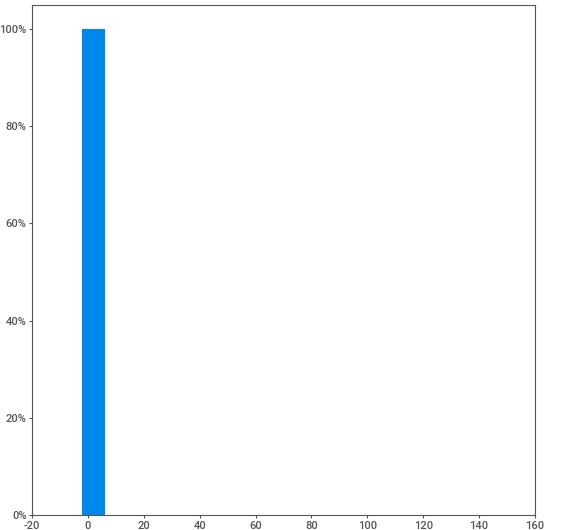
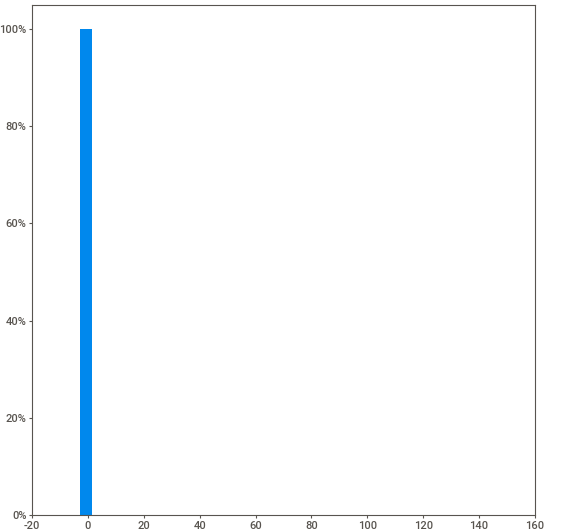
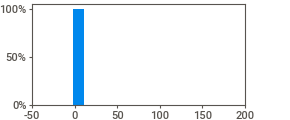
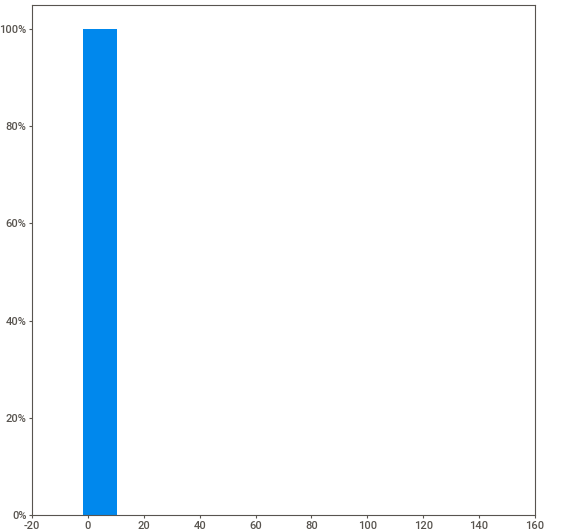
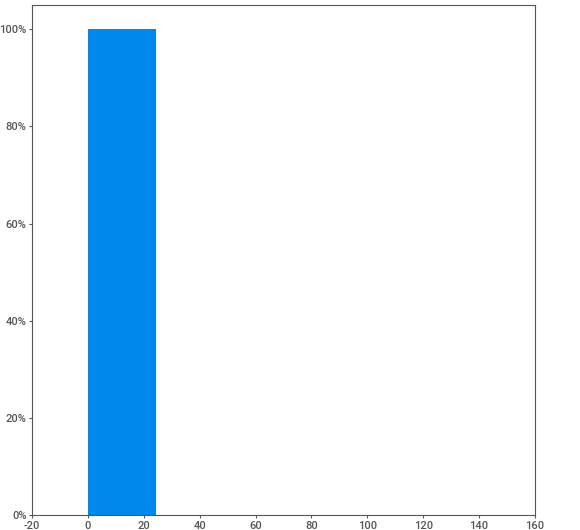
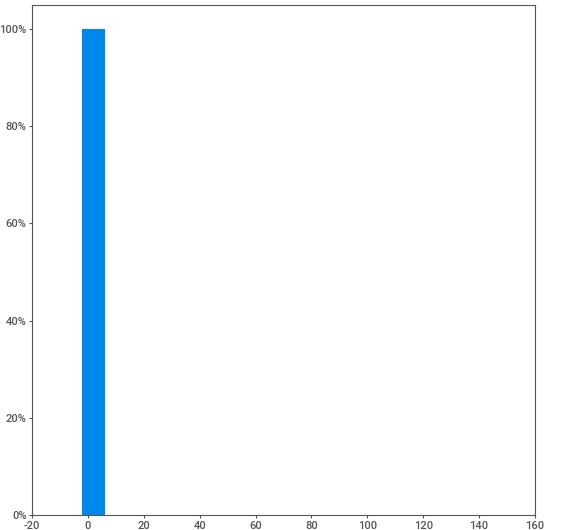
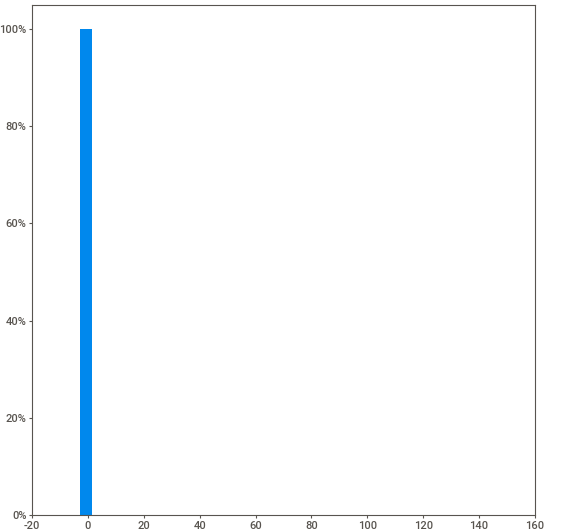
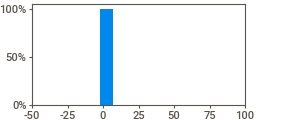
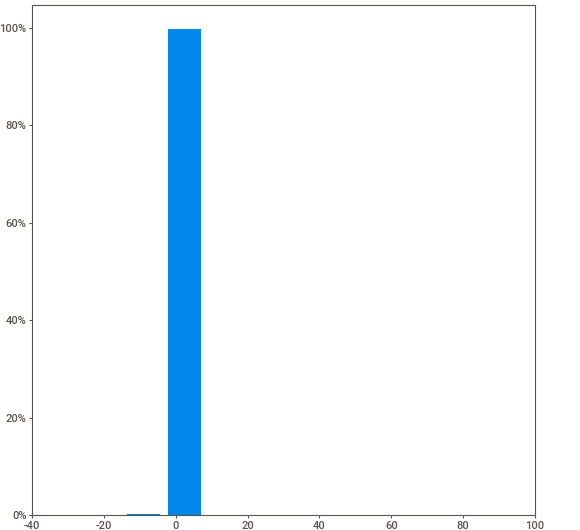
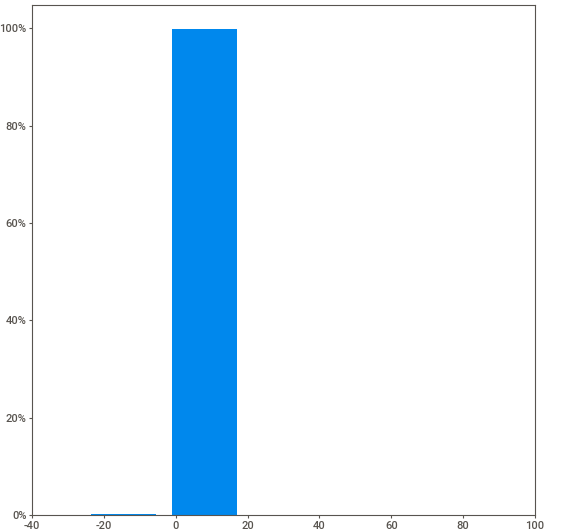
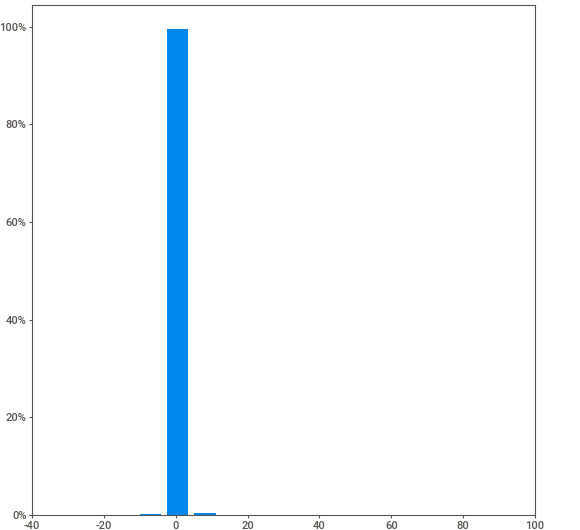
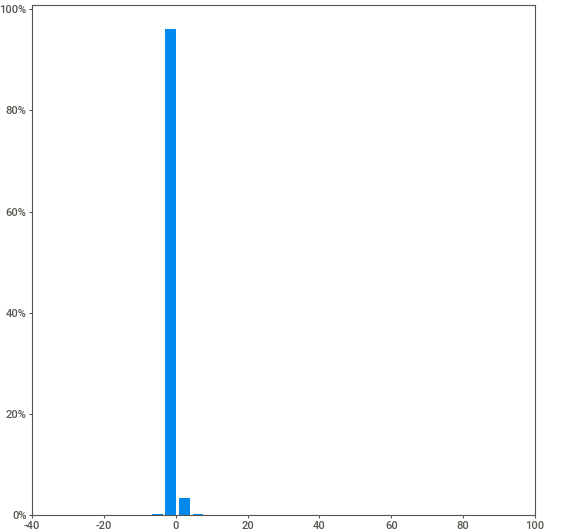
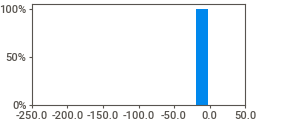
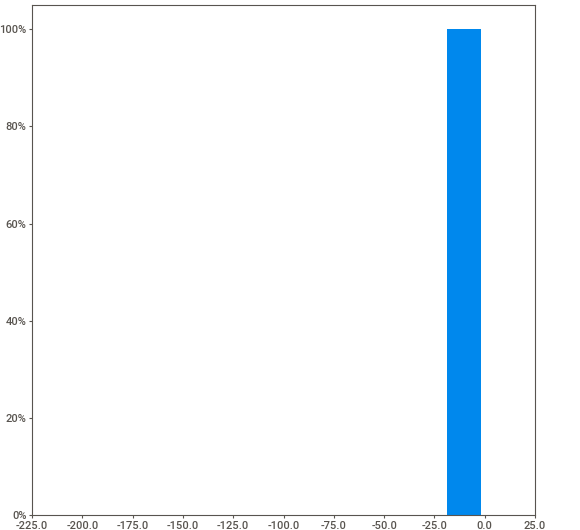
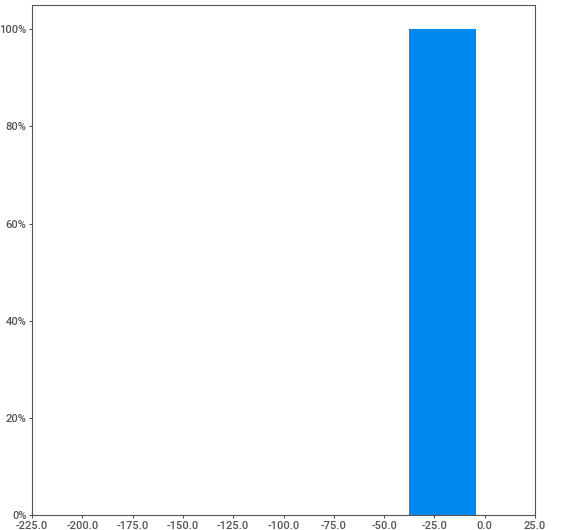
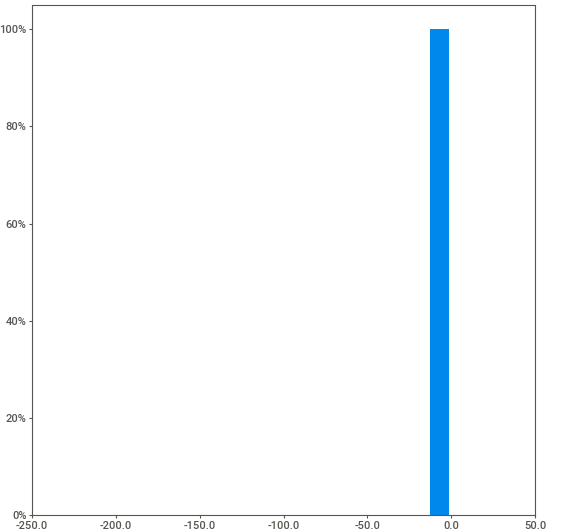
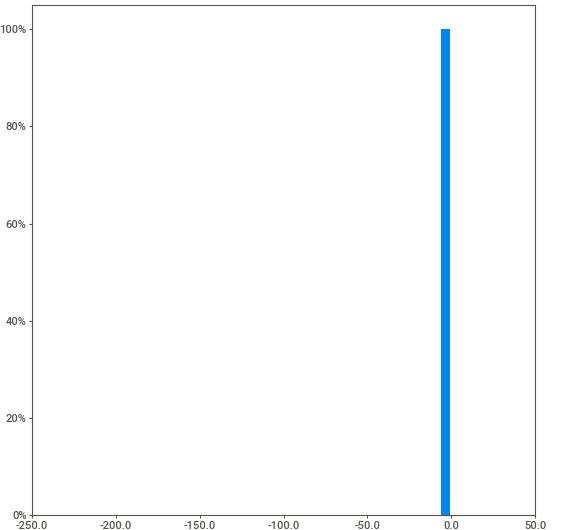
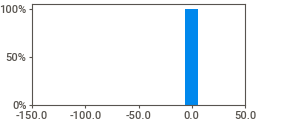
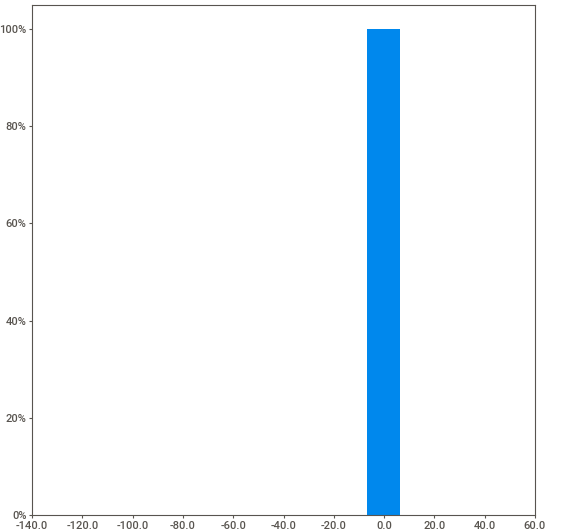
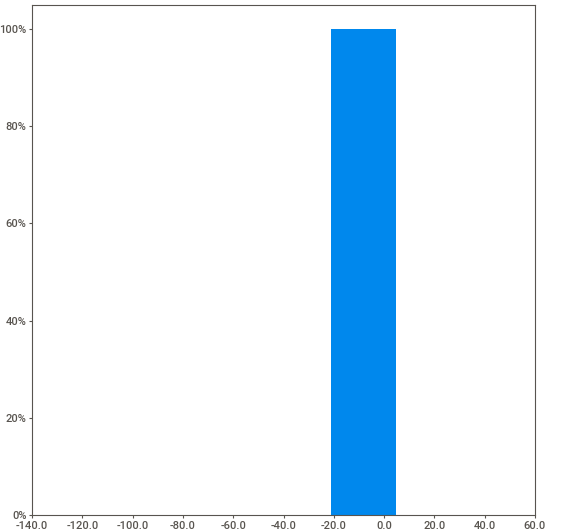
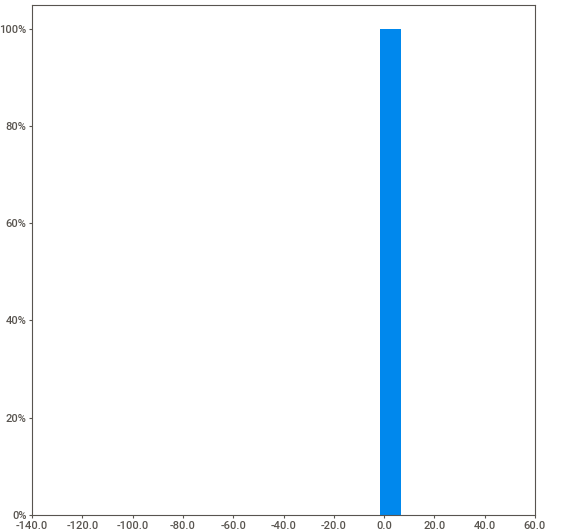
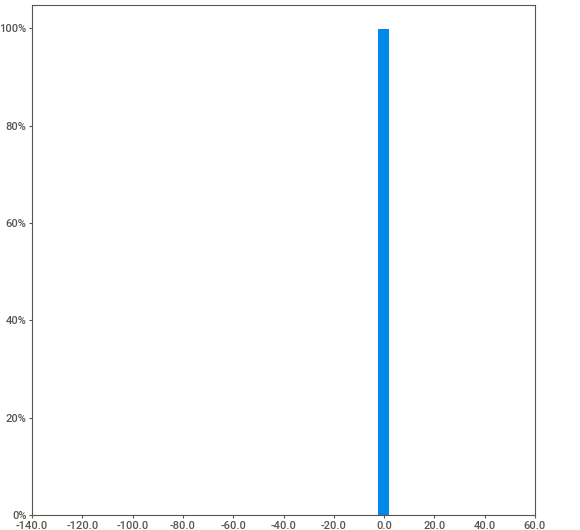
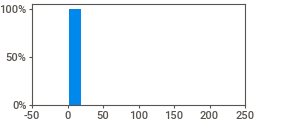
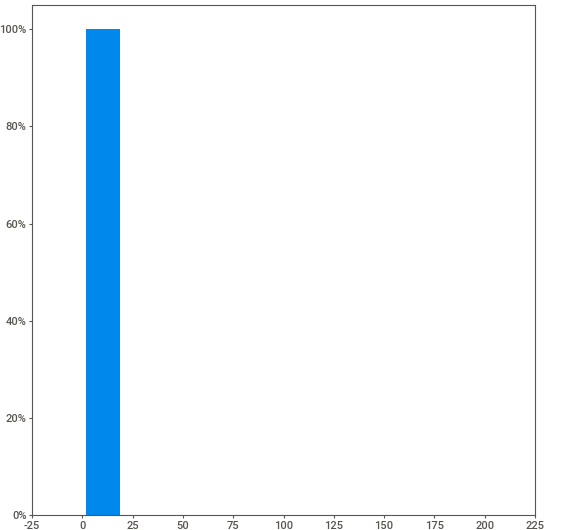
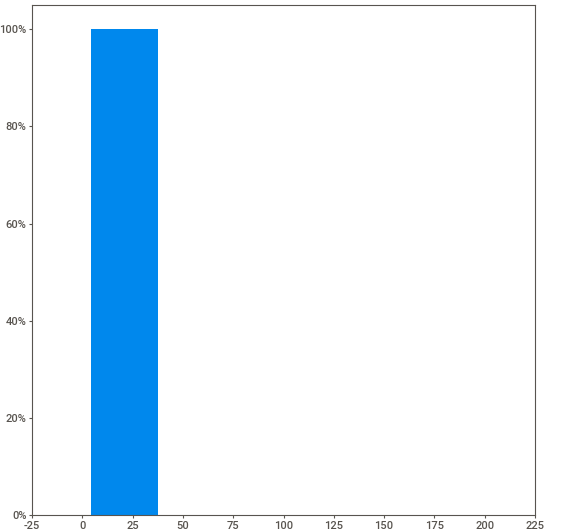
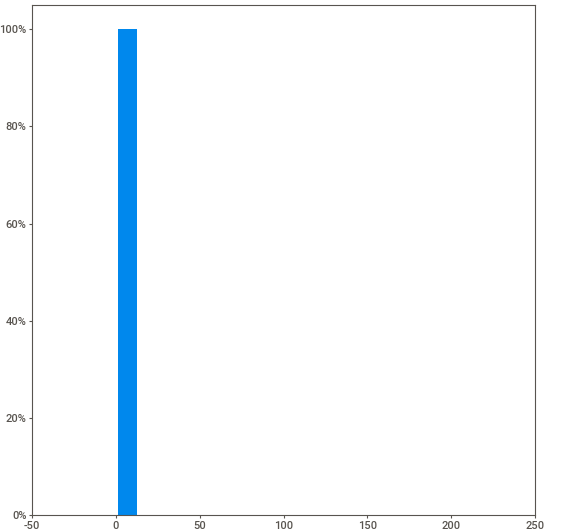
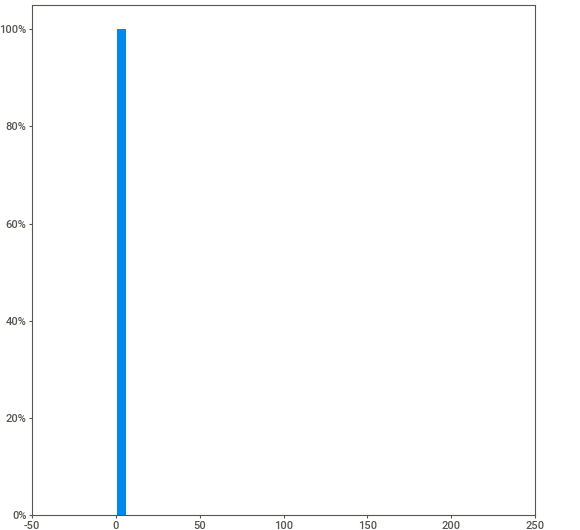
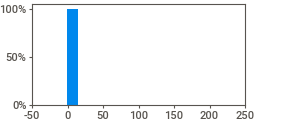
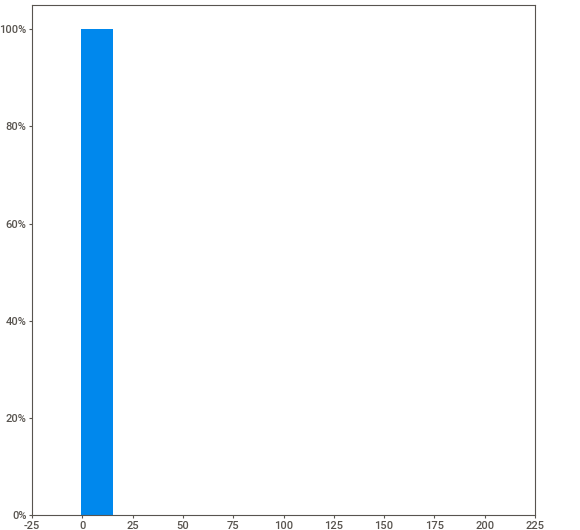
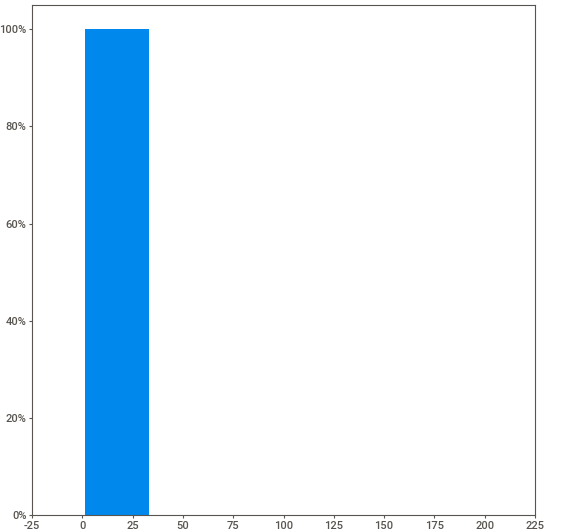
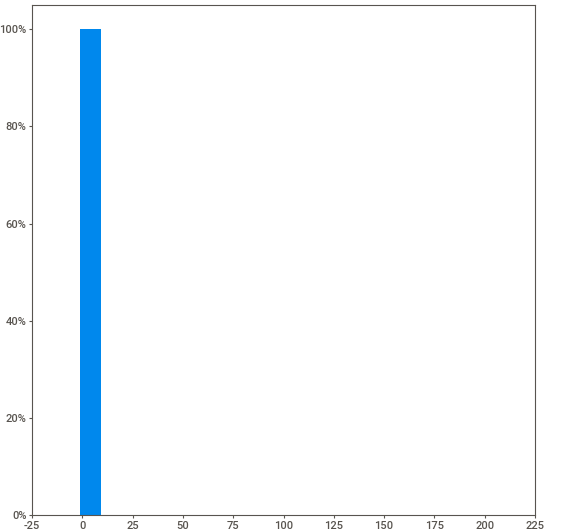
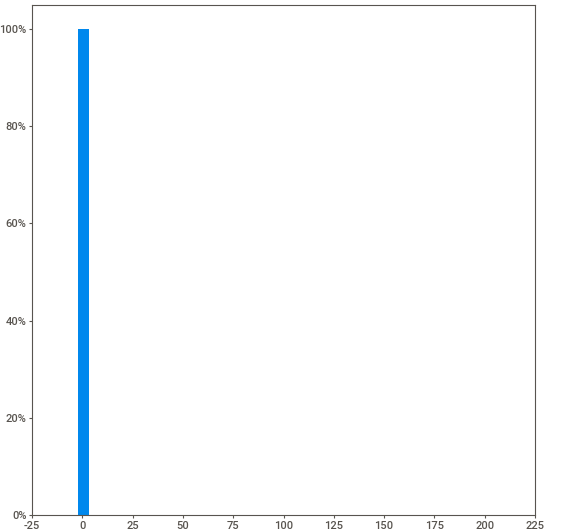
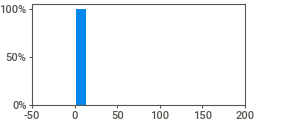
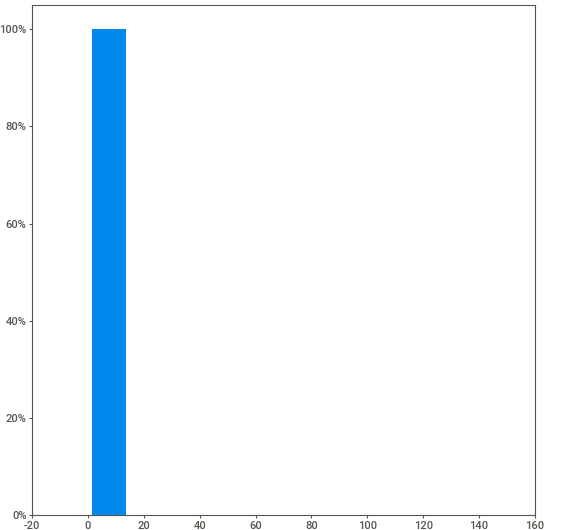
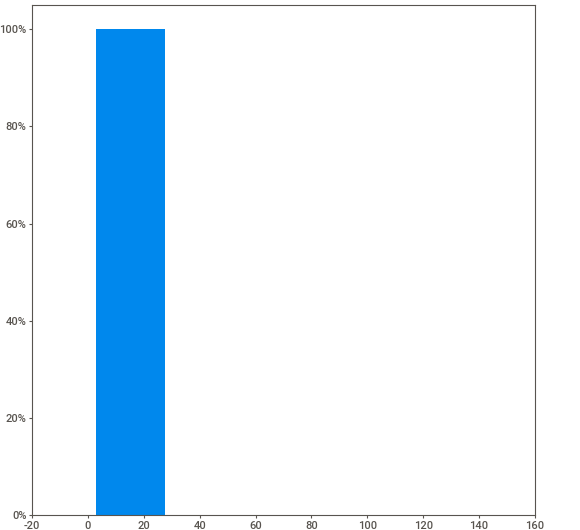
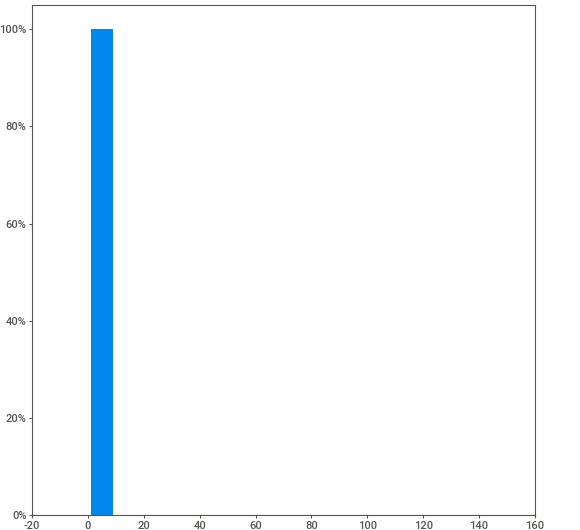
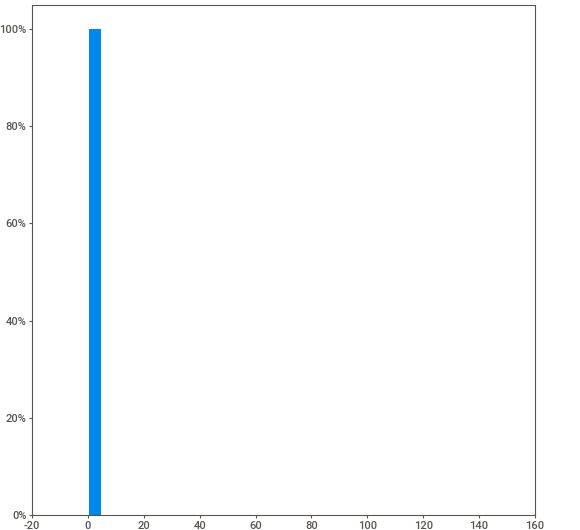
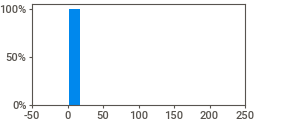
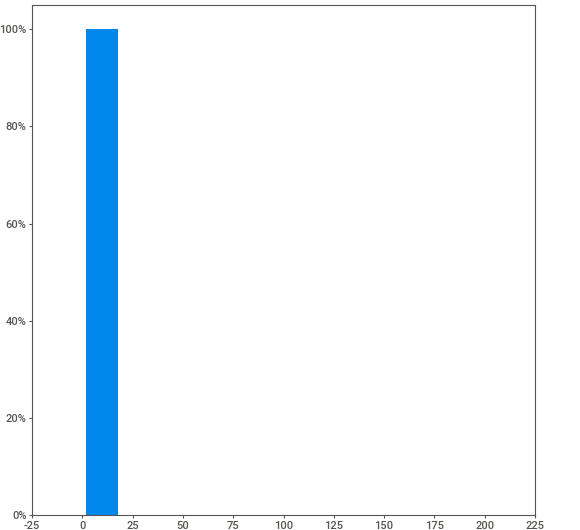
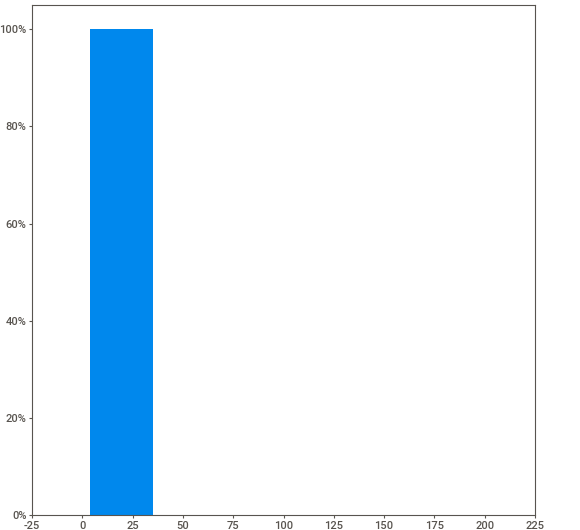
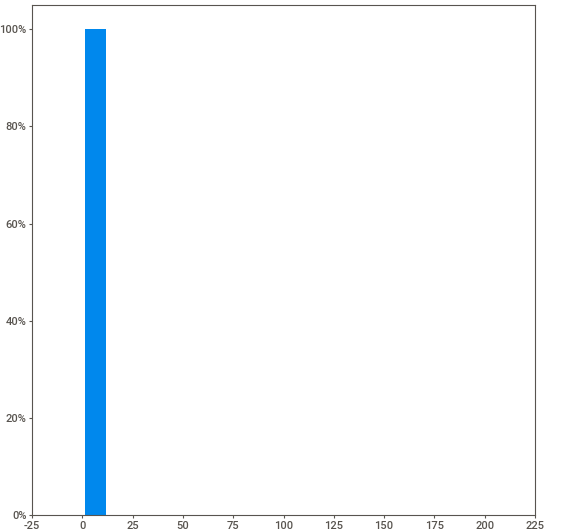
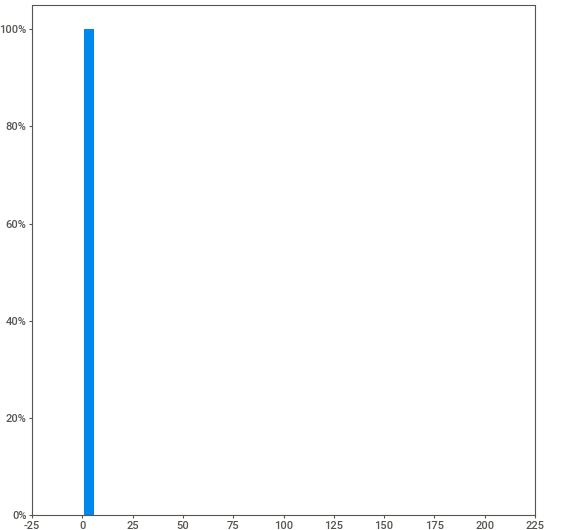
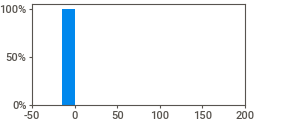
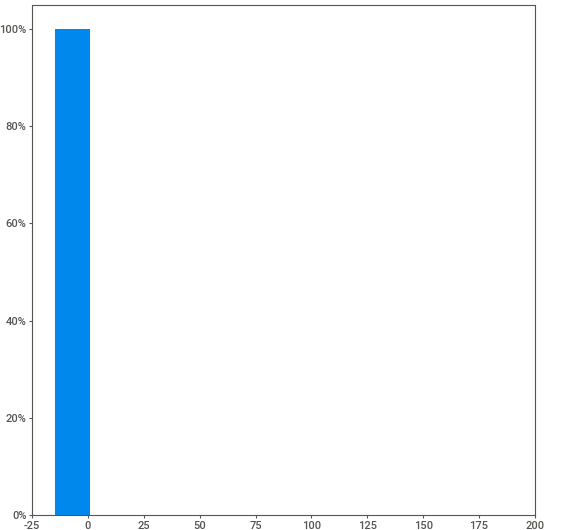
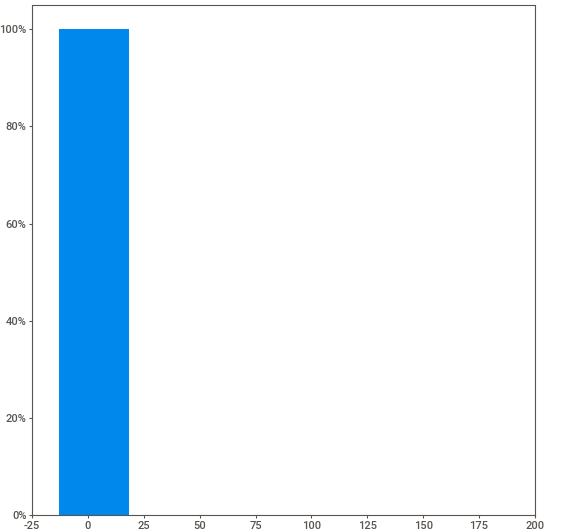
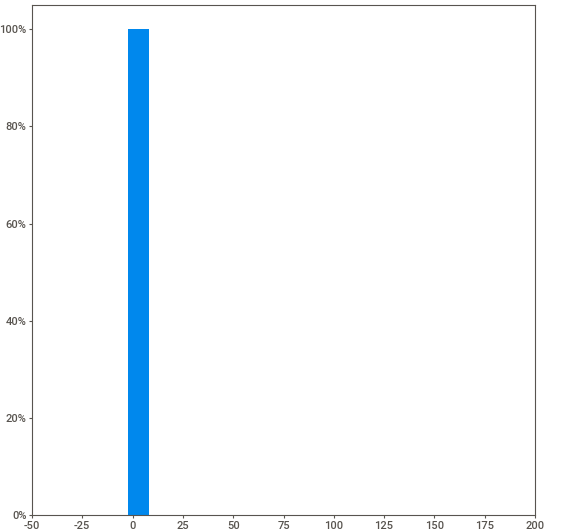
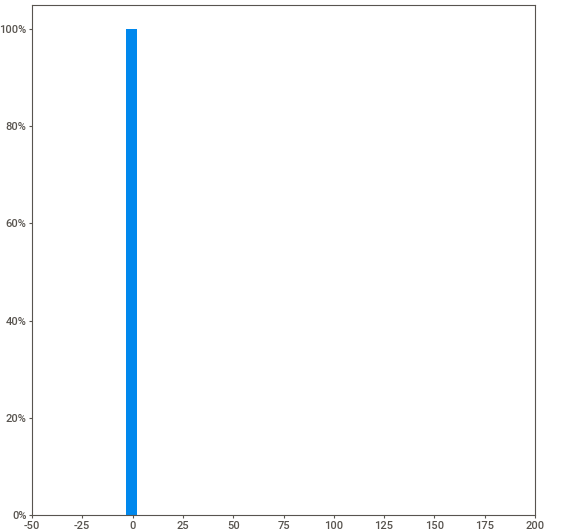
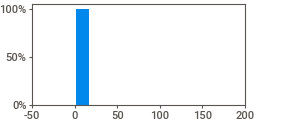
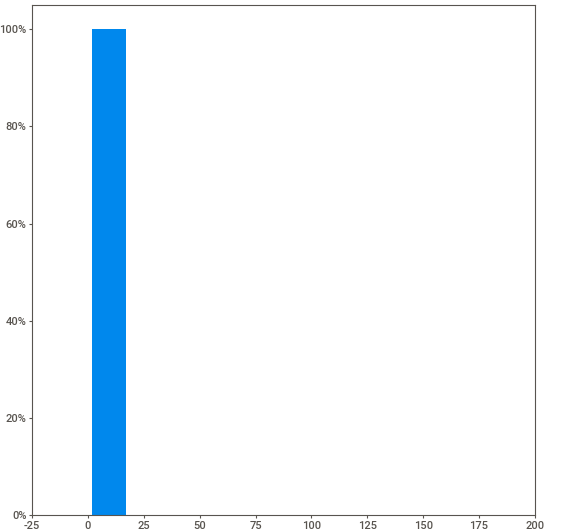
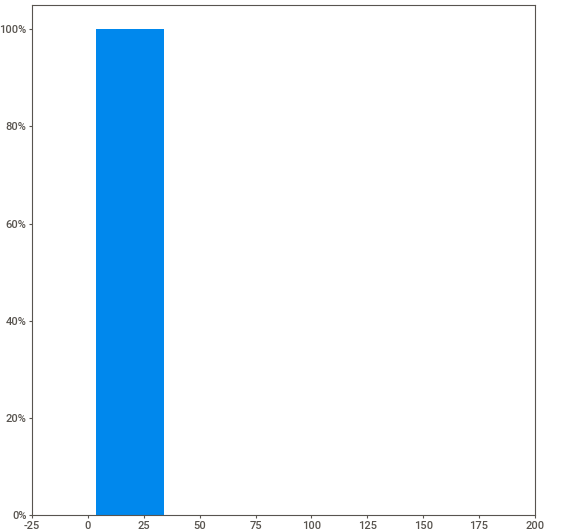
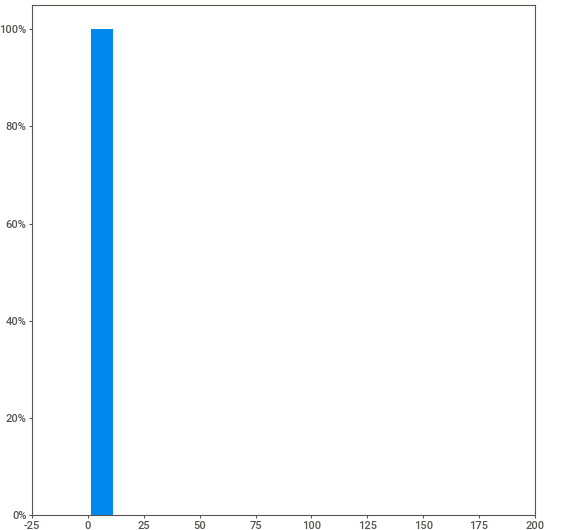
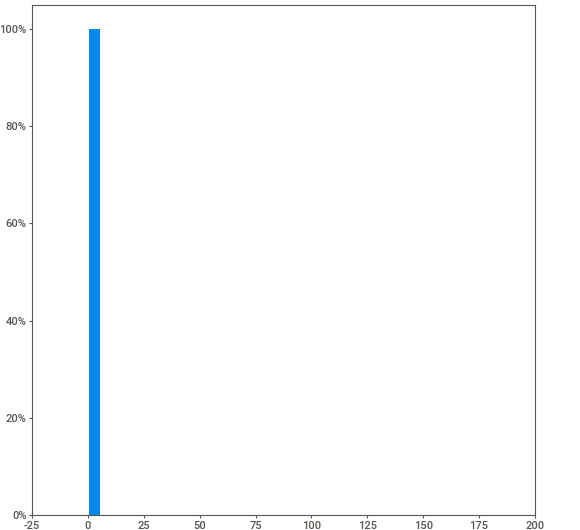
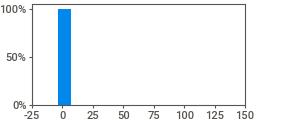
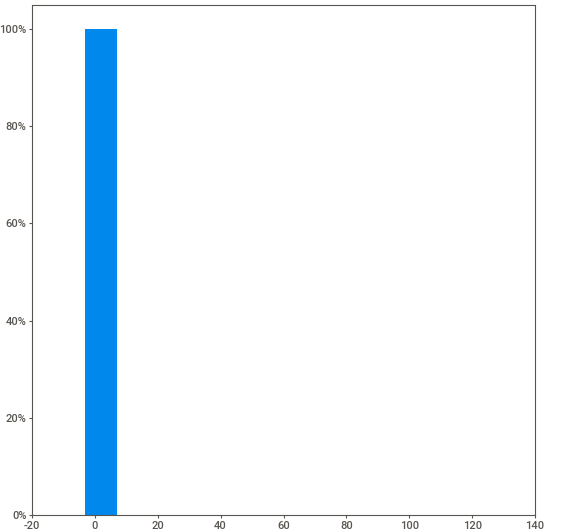
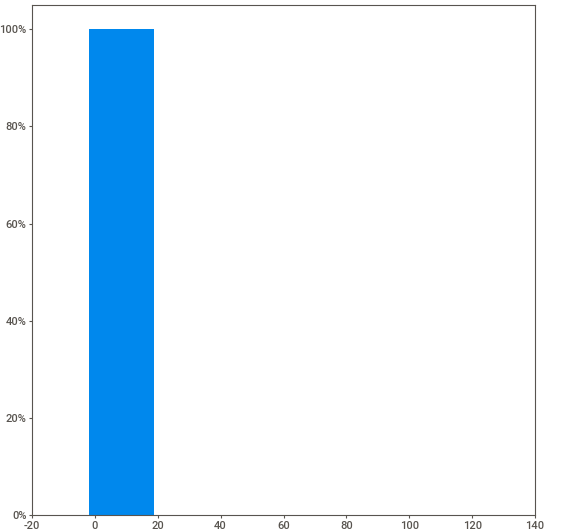
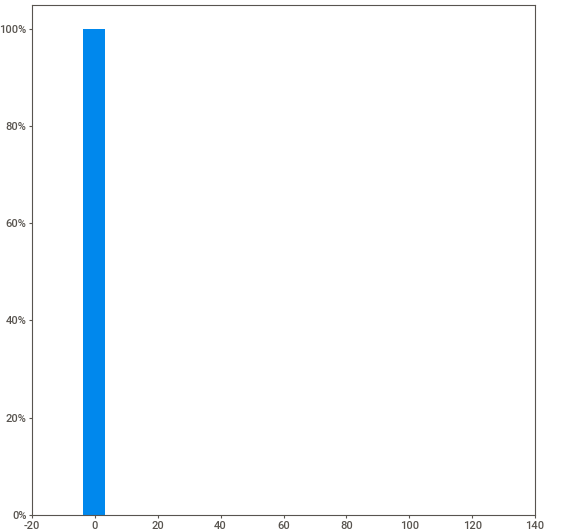
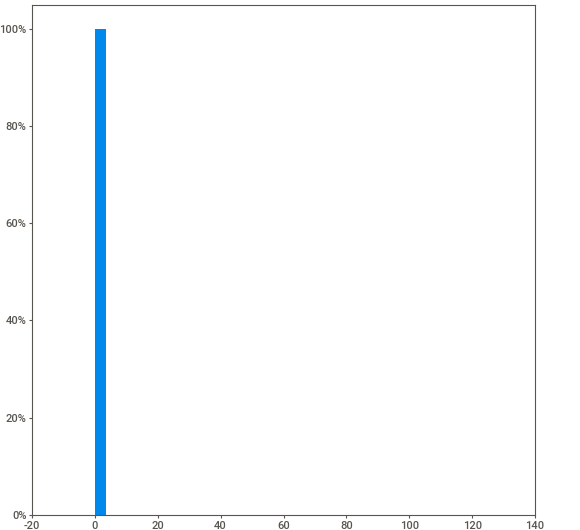
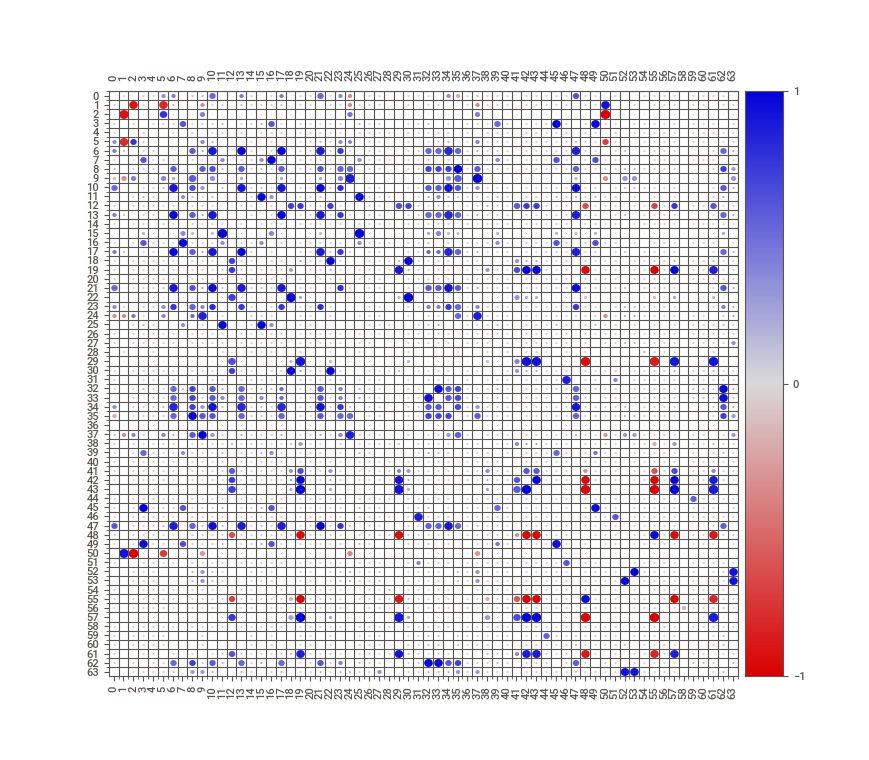
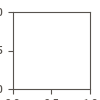

In [126]:
# Generate the report using SweetViz package, it takes a few minutes to run but provides a comprehensive report on the data
import sweetviz as sv

report = sv.analyze(X_scaled)
report.show_notebook()

## Modeling 

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score, make_scorer
from sklearn.exceptions import NotFittedError


In [66]:
# Define the parameter distributions to sample from (Your original code)
params = {
    'n_estimators': [100],# 'n_estimators': [50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4],  
    'min_samples_leaf': [2, 4, 5],
    'max_features': [ 1, 2, 'sqrt', None],
}

rf = RandomForestClassifier(random_state=42)


scoring = {
    'accuracy': make_scorer(accuracy_score), 
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score),
    'average_precision': make_scorer(average_precision_score)
}


random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=params, 
    n_iter=10, 
    scoring=scoring,  
    refit='accuracy',  
    n_jobs=-1, 
    cv=5, 
    random_state=42,
    error_score='raise',  
    return_train_score=True
)


In [67]:
try:
    random_search.fit(X_scaled, y)
except NotFittedError:
    print("Warning: Some hyperparameter combinations resulted in errors--skipped.")

/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tmc/opt/anaconda3/envs/PythonData/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [68]:
# Get the best parameters for each metric
best_params_per_metric = {}
for metric in scoring:
    best_index = np.argmax(random_search.cv_results_['mean_test_' + metric])
    best_params_per_metric[metric] = random_search.cv_results_['params'][best_index]


print("\nBest Parameters per Metric:")
for metric, params in best_params_per_metric.items():
    print(f"- {metric}: {params}")
    
results_df = pd.DataFrame(random_search.cv_results_)


for metric in scoring:
    mean_score = results_df['mean_test_' + metric].mean()
    std_score = results_df['std_test_' + metric].mean()
    print(f"\n{metric}: {mean_score:.4f} +/- {std_score:.4f}")


Best Parameters per Metric:
- accuracy: {'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 8, 'criterion': 'gini'}
- precision: {'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'}
- recall: {'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 8, 'criterion': 'gini'}
- roc_auc: {'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 8, 'criterion': 'gini'}
- average_precision: {'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 8, 'criterion': 'gini'}

accuracy: 0.9559 +/- 0.0005

precision: 0.2847 +/- 0.0193

recall: 0.0919 +/- 0.0060

roc_auc: 

# Final Random Model -- taking the highest accuracy scored model from the grid search and plotting the ROC-AUC curve using cross-validation on the random forest model with the best tuned hyperparameters 

In [69]:
# Can we create a classification report/ confusion matrix from this not sure but try if not dont worry cause he didnt say anything about it. 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Get the best model based on accuracy 
best_index = np.argmax(random_search.cv_results_['mean_test_accuracy'])
best_params = random_search.cv_results_['params'][best_index]

# Retrain the best model on the full training set
# - accuracy: {'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 8, 'criterion': 'gini'}

best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_scaled, y)

# Cross-validate the final model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

y_pred = cross_val_predict(best_rf_model, X_scaled, y, cv=5)


print("Classification Report:\n", classification_report(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))




Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     41314
           1       0.91      0.38      0.54      2091

    accuracy                           0.97     43405
   macro avg       0.94      0.69      0.76     43405
weighted avg       0.97      0.97      0.96     43405

Confusion Matrix:
 [[41231    83]
 [ 1295   796]]


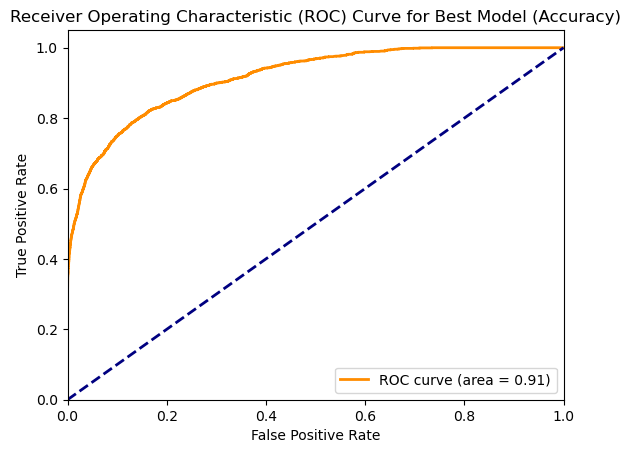

In [70]:
# Calculate the ROC curve and AUC
y_scores = cross_val_predict(best_rf_model, X_scaled, y, cv=5, method="predict_proba")[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Best Model (Accuracy)')
plt.legend(loc="lower right")
plt.show()

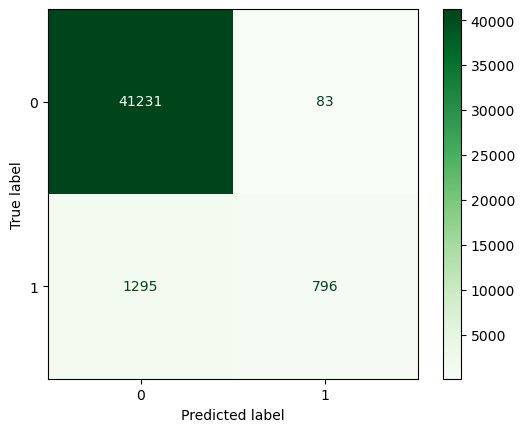

In [71]:

ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Greens')
plt.show()

## XGBOOST Random Grid Search 
## Best model crossvalidated 50 estimators and 500 estimators for final comparison

In [17]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score, make_scorer
from sklearn.exceptions import NotFittedError


In [18]:
y.shape
X_scaled.shape

(43405, 64)

In [19]:
# DMatrix Required for XGBoost
dmat_data = xgb.DMatrix(X_scaled, label = y.ravel()) # convert to a 1D array so that we can select the number of classes to be 2 - hence bianaary classification
# dmat_data = xgb.DMatrix(X_scaled, label=y, num_class=2) 


In [76]:
# 1. Grid Search for XGBoost works ! 

params = {
    'booster': 'gbtree',
    'objective':'binary:logistic', #,'binary:hinge' this will turn to a binary 0 or 1
    # 'num_class': 2, not necessary for binary classification in XGBoost
    "eta": 0.1, # you can go as high as 0.3 and as low as 0.01 but requires more trees 
    "subsample": 0.8,
    "colsample_bytree": 0.5, # lower to prevent overfitting
    # "max_depth": 6, # you will need to increase to 1000, 6 is default, use early stopping greater than 50 
    'reg_lambda': 2, # L2 regularization term on weights, values between 1 and 3 
}

max_depth = [50, 100, 500]
sub_s = np.random.random(10)
cols = np.random.random(10)
md = np.random.randint(0,3,10)

results = []  # Store results here

for i in range(10):
    params['subsample']=sub_s[i]
    params['colsample_bytree']=cols[i]
    params['max_depth']=max_depth[md[i]]    # FIX for final model num_boost_round=1000
    tmp = xgb.cv(params, dmat_data, num_boost_round=1000, nfold=5, stratified=False,metrics=(['auc']),verbose_eval=False,early_stopping_rounds=5,show_stdv=True, seed=0)
    print("_______________done_______________")
    print(params)
    print(tmp.loc[tmp.shape[0]-1:,:])
    print("=====================================")
    results.append((params.copy(), tmp.loc[tmp.shape[0]-1,:]))  # Store params and result
    tmp = 0 # for some reason if I don't zero this out it causes issues.
    
out = xgb.cv(params, dmat_data, num_boost_round=5000, nfold=5, stratified=False,metrics=(['auc', 'log_loss']),verbose_eval=True,early_stopping_rounds=5,show_stdv=True, seed=0)




_______________done_______________
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eta': 0.1, 'subsample': 0.5726045094068731, 'colsample_bytree': 0.8142795758435973, 'reg_lambda': 2, 'max_depth': 100}
    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
99        0.999995   8.814561e-07       0.969544      0.001277
_______________done_______________
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eta': 0.1, 'subsample': 0.7681758783608563, 'colsample_bytree': 0.24444474667436922, 'reg_lambda': 2, 'max_depth': 500}
    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
23        0.996676       0.000682       0.919715      0.004095
_______________done_______________
{'booster': 'gbtree', 'objective': 'binary:logistic', 'eta': 0.1, 'subsample': 0.7683539192401541, 'colsample_bytree': 0.20800709143314888, 'reg_lambda': 2, 'max_depth': 500}
    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
39        0.999471        0.00006       0.919356      0.

In [25]:
import xgboost as xgb
import numpy as np

params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic', 
    "eta": 0.1, 
    "subsample": None,  # Placeholder to be filled in the loop
    "colsample_bytree": None,  # Placeholder to be filled in the loop
    "max_depth": None,       # Placeholder to be filled in the loop
    'reg_lambda': 2, 
}

max_depth = [50, 100, 500]
sub_s = np.random.random(10)
cols = np.random.random(10)
md = np.random.randint(0, 3, 10)

results = []

for i in range(10):
    temp_params = params.copy()  # Copy params before modification
    temp_params['subsample'] = sub_s[i]
    temp_params['colsample_bytree'] = cols[i]
    temp_params['max_depth'] = max_depth[md[i]]

    cv_result = xgb.cv(
        temp_params, 
        dmat_data, 
        num_boost_round=1000, 
        nfold=5, 
        stratified=False,
        metrics=['auc'],
        early_stopping_rounds=5,
        verbose_eval=False, 
        seed=0
    )

    best_iteration = cv_result['test-auc-mean'].idxmax()
    best_auc = cv_result['test-auc-mean'][best_iteration]

    results.append({
        'params': temp_params,  # Use the modified copy of params
        'best_iteration': best_iteration,
        'best_auc': best_auc
    })
# Find best hyperparameters
best_params = max(results, key=lambda x: x['best_auc'])

# Display Results
print("\nXGBoost Grid Search Results:")
for result in results:
    print("\nHyperparameters:", result['params'])
    print("Best Iteration:", result['best_iteration'])
    print(f"Test AUC Mean: {result['best_auc']:.4f}")

print("\nBest Hyperparameters:", best_params['params'])
print(f"Best Test AUC Mean: {best_params['best_auc']:.4f}")


final_cv = xgb.cv(
    best_params['params'], 
    dmat_data, 
    num_boost_round=5000, 
    nfold=5, 
    stratified=False,
    metrics=['auc', 'logloss'],
    verbose_eval=True, 
    early_stopping_rounds=5,
    seed=0, 
)



XGBoost Grid Search Results:

Hyperparameters: {'booster': 'gbtree', 'objective': 'binary:logistic', 'eta': 0.1, 'subsample': 0.5726045094068731, 'colsample_bytree': 0.8142795758435973, 'max_depth': 100, 'reg_lambda': 2}
Best Iteration: 99
Test AUC Mean: 0.9695

Hyperparameters: {'booster': 'gbtree', 'objective': 'binary:logistic', 'eta': 0.1, 'subsample': 0.7681758783608563, 'colsample_bytree': 0.24444474667436922, 'max_depth': 500, 'reg_lambda': 2}
Best Iteration: 23
Test AUC Mean: 0.9197

Hyperparameters: {'booster': 'gbtree', 'objective': 'binary:logistic', 'eta': 0.1, 'subsample': 0.7683539192401541, 'colsample_bytree': 0.20800709143314888, 'max_depth': 500, 'reg_lambda': 2}
Best Iteration: 39
Test AUC Mean: 0.9194

Hyperparameters: {'booster': 'gbtree', 'objective': 'binary:logistic', 'eta': 0.1, 'subsample': 0.2776862767856838, 'colsample_bytree': 0.3458268234615236, 'max_depth': 500, 'reg_lambda': 2}
Best Iteration: 102
Test AUC Mean: 0.9532

Hyperparameters: {'booster': 'gbtr

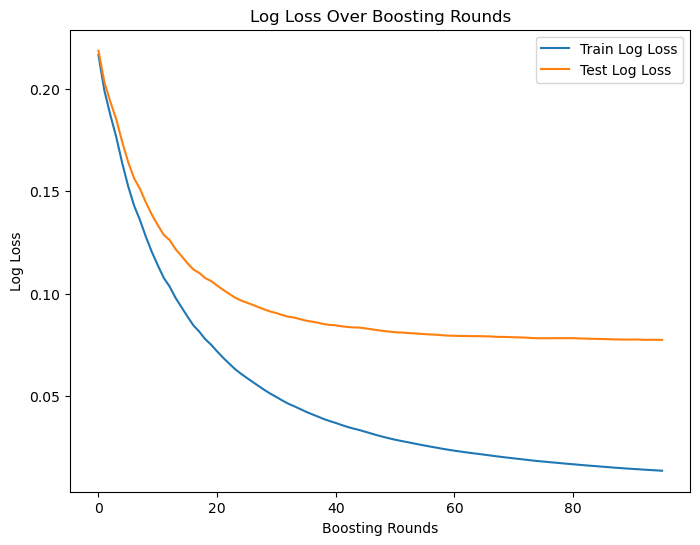

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(final_cv['train-logloss-mean'], label='Train Log Loss')
plt.plot(final_cv['test-logloss-mean'], label='Test Log Loss')  # 
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Log Loss Over Boosting Rounds')
plt.legend()
plt.show()

In [31]:
# Model using best hyperparameters from xgboost.cv grid search
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# best tuned hyperparamter 
model = xgb.XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    eta=0.1,
    subsample=0.5726045094068731,
    colsample_bytree=0.8142795758435973,
    max_depth=100,
    reg_lambda=2,
    n_estimators= 99, 
    use_label_encoder=False,  
    eval_metric='logloss'  
)

# train
model.fit(X_train, y_train)

# preds
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

ROC-AUC: 0.9692
Accuracy: 0.9730
F1 Score: 0.6528
Precision: 0.9442
Recall: 0.4989


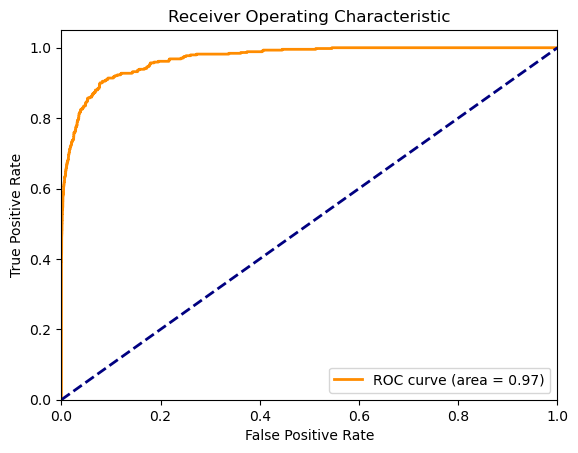

In [30]:
from sklearn.metrics import roc_curve, auc
# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# USE PROBABILITIES FOR ROC CURVE !!!
# plot 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      8240
           1       0.94      0.50      0.65       441

    accuracy                           0.97      8681
   macro avg       0.96      0.75      0.82      8681
weighted avg       0.97      0.97      0.97      8681



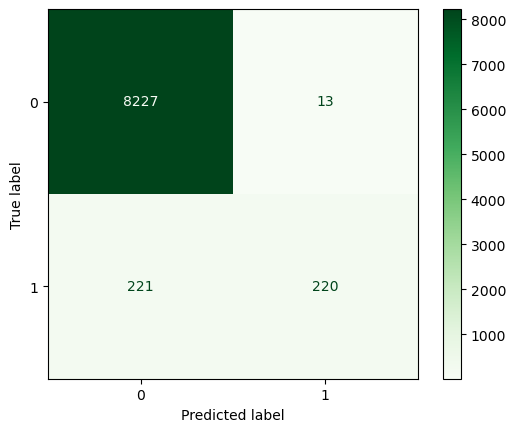

In [42]:
cls_report = classification_report(y_test, y_pred)
print(cls_report)
# get classificaiotn confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens')
plt.show()

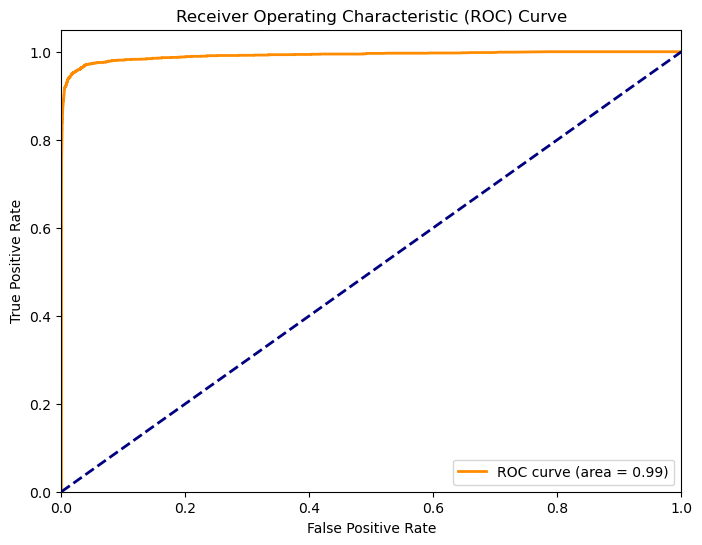

In [69]:
# y_pred_proba = best_xgb_model.predict(dmat_data)  # Predicted probabilities
# y_pred = (y_pred_proba >= 0.5).astype(int)       # Convert to binary predictions
# accuracy = accuracy_score(y, y_pred)

# print(f"\nFinal Accuracy on Training Set: {accuracy:.4f}")
# # Get true labels from DMatrix
# y_true = dmat_data.get_label()

# # Calculate ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()